In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [ ]:
df = pd.read_csv('HUAMI_SPO2_SAMPLE_202510311139.csv')

# Basic info
print(f"Dataset Shape: {df.shape}")
print(f"Total measurements: {len(df):,}")
print(f"Unique users: {df['USER_ID'].nunique()}")

Dataset Shape: (12426, 5)
Total measurements: 12,426
Unique users: 18


In [ ]:
df.head()

,TIMESTAMP,DEVICE_ID,USER_ID,TYPE_NUM,SPO2
0,1.750000e+12,1,1.0,0,99
1,1.750000e+12,1,1.0,0,99
2,1.750000e+12,1,1.0,0,99
3,1.750000e+12,1,1.0,0,96
4,1.750000e+12,1,1.0,0,96


In [ ]:
# Convert timestamp from milliseconds to datetime
df['datetime'] = pd.to_datetime(df['TIMESTAMP'], unit='ms')

# Add date column (without time)
df['date'] = df['datetime'].dt.date

print(f"Time Coverage:")
print(f"Start: {df['datetime'].min()}")
print(f"End: {df['datetime'].max()}")
print(f"Duration: {(df['datetime'].max() - df['datetime'].min()).days} days")

print("\n")

print(f"SpO2 Statistics:")
print(f"Range: {df['SPO2'].min()}% - {df['SPO2'].max()}%")
print(f"Mean: {df['SPO2'].mean():.2f}%")
print(f"Median: {df['SPO2'].median():.0f}%")
print(f"Std Dev: {df['SPO2'].std():.2f}%")

print("\n")

below_90 = (df['SPO2'] < 90).sum()
below_95 = (df['SPO2'] < 95).sum()
print(f"Clinical Threshold Analysis:")
print(f"Readings below 90%: {below_90:,} ({below_90/len(df)*100:.2f}%)")
print(f"Readings below 95%: {below_95:,} ({below_95/len(df)*100:.2f}%)")

print("\n")

print(f"Per-User Statistics:")
user_counts = df.groupby('USER_ID').size()
print(f"Avg readings per user: {user_counts.mean():.0f}")
print(f"Min readings: {user_counts.min()}")
print(f"Max readings: {user_counts.max()}")

print("\n")

sample_user = df['USER_ID'].value_counts().index[10]
user_data = df[df['USER_ID'] == sample_user].sort_values('datetime')

print(f"Sample User {sample_user} Analysis:")
print(f"Total readings: {len(user_data)}")
print(f"Date range: {user_data['datetime'].min().date()} to {user_data['datetime'].max().date()}")
print(f"Days of data: {user_data['date'].nunique()}")

Time Coverage:
Start: 2025-06-15 15:06:40
End: 2025-10-09 08:53:20
Duration: 115 days


SpO2 Statistics:
Range: 80% - 99%
Mean: 96.05%
Median: 96%
Std Dev: 2.77%


Clinical Threshold Analysis:
Readings below 90%: 368 (2.96%)
Readings below 95%: 2,709 (21.80%)


Per-User Statistics:
Avg readings per user: 690
Min readings: 152
Max readings: 1257


Sample User 19.0 Analysis:
Total readings: 664
Date range: 2025-10-09 to 2025-10-09
Days of data: 1


Calculating Hypoxic Burden

In [ ]:
def calculate_hypoxic_burden(spo2_readings, threshold=95, method='duration'):
    """
    Calculate hypoxic burden from daily SpO2 readings.

    Parameters:
    -----------
    spo2_readings : array-like
        SpO2 values for a single day
    threshold : int, default=95
        SpO2 threshold below which oxygen debt accumulates (%)
    method : str, default='duration'
        'simple' - frequency-weighted (treats each reading equally)
        'duration' - assumes uniform time distribution across 24h

    Returns:
    --------
    dict with calculated metrics
    """

    spo2_array = np.array(spo2_readings)

    # Basic metrics
    n_readings = len(spo2_array)
    min_spo2 = spo2_array.min()
    mean_spo2 = spo2_array.mean()

    # Find readings below threshold
    below_threshold_mask = spo2_array < threshold
    readings_below = below_threshold_mask.sum()

    # Calculate oxygen deficit for each reading
    oxygen_deficits = np.maximum(0, threshold - spo2_array)

    if method == 'simple':
        oxygen_debt = oxygen_deficits.sum() / n_readings
    elif method == 'duration':
        time_per_reading = 24.0 / n_readings
        oxygen_debt = oxygen_deficits.sum() * time_per_reading

    # Risk categorization
    if oxygen_debt == 0:
        severity = 'None'
    elif oxygen_debt < 2:
        severity = 'Low'
    elif oxygen_debt < 10:
        severity = 'Medium'
    else:
        severity = 'High'

    return {
        'oxygen_debt': round(oxygen_debt, 2),
        'readings_below_threshold': int(readings_below),
        'pct_below_threshold': round(100 * readings_below / n_readings, 2),
        'min_spo2': int(min_spo2),
        'mean_spo2': round(mean_spo2, 2),
        'severity_score': severity,
        'total_readings': n_readings
    }

In [ ]:
# Extract patient ID (the integer part before the decimal)
df['patient_id'] = df['USER_ID'].apply(lambda x: int(x))

# Extract visit number (0 or 1)
df['visit'] = df['USER_ID'].apply(lambda x: int(round((x - int(x)) * 10)))

In [ ]:
results = []

for (patient_id, visit, date), group in df.groupby(['patient_id', 'visit', 'date']):

    spo2_values = group['SPO2'].values

    # Calculate using duration-weighted method (clinically meaningful)
    result = calculate_hypoxic_burden(spo2_values, threshold=95, method='duration')

    results.append({
        'patient_id': patient_id,
        'visit': visit,
        'user_id': group['USER_ID'].iloc[0],  # Original USER_ID
        'date': date,
        'oxygen_debt': result['oxygen_debt'],
        'readings_below_95': result['readings_below_threshold'],
        'pct_below_95': result['pct_below_threshold'],
        'min_spo2': result['min_spo2'],
        'mean_spo2': result['mean_spo2'],
        'severity': result['severity_score'],
        'total_readings': result['total_readings']
    })

In [ ]:
results_df = pd.DataFrame(results)

# Sort by patient_id and visit for clarity
results_df = results_df.sort_values(['patient_id', 'visit', 'date']).reset_index(drop=True)

print("\n3. Results (All patient-visit-days):")
print("=" * 100)
print(results_df.to_string(index=False))

print("\n\n" + "=" * 70)
print("SUMMARY STATISTICS")
print("=" * 70)

print(f"\n1. Dataset Overview:")
print(f"   - Total unique patients: {results_df['patient_id'].nunique()}")
print(f"   - Total patient-visit-days: {len(results_df)}")
print(f"   - Patients with multiple visits: {results_df.groupby('patient_id')['visit'].nunique().gt(1).sum()}")

print("\n2. Oxygen Debt Distribution (%-hours):")
print(f"   - Mean: {results_df['oxygen_debt'].mean():.2f}")
print(f"   - Median: {results_df['oxygen_debt'].median():.2f}")
print(f"   - Std Dev: {results_df['oxygen_debt'].std():.2f}")
print(f"   - Min: {results_df['oxygen_debt'].min():.2f}")
print(f"   - Max: {results_df['oxygen_debt'].max():.2f}")

print("\n3. Severity Distribution:")
severity_counts = results_df['severity'].value_counts()
for severity in ['None', 'Low', 'Medium', 'High']:
    count = severity_counts.get(severity, 0)
    pct = 100 * count / len(results_df)
    print(f"   - {severity}: {count} ({pct:.1f}%)")

print("\n4. Per-Patient Summary (aggregated across visits):")
print("-" * 70)
patient_summary = results_df.groupby('patient_id').agg({
    'oxygen_debt': ['mean', 'min', 'max'],
    'visit': 'nunique',
    'date': 'count'
}).round(2)
patient_summary.columns = ['avg_oxygen_debt', 'min_oxygen_debt', 'max_oxygen_debt', 'num_visits', 'num_days']
print(patient_summary.to_string())

print("\n5. Visit Comparison (Visit 0 vs Visit 1):")
print("-" * 70)
visit_comparison = results_df.groupby('visit').agg({
    'oxygen_debt': ['mean', 'median', 'std'],
    'patient_id': 'count'
}).round(2)
visit_comparison.columns = ['mean_oxygen_debt', 'median_oxygen_debt', 'std_oxygen_debt', 'num_records']
print(visit_comparison.to_string())

# Check if there are patients with data from both visits
patients_both_visits = results_df.groupby('patient_id')['visit'].nunique()
patients_with_both = patients_both_visits[patients_both_visits == 2].index.tolist()

if len(patients_with_both) > 0:
    print(f"\n6. Patients with Both Visits (n={len(patients_with_both)}):")
    print("-" * 70)
    for patient in sorted(patients_with_both):
        visit0_debt = results_df[(results_df['patient_id'] == patient) & (results_df['visit'] == 0)]['oxygen_debt'].mean()
        visit1_debt = results_df[(results_df['patient_id'] == patient) & (results_df['visit'] == 1)]['oxygen_debt'].mean()
        change = visit1_debt - visit0_debt
        print(f"   Patient {patient}: Visit 0 = {visit0_debt:.2f}, Visit 1 = {visit1_debt:.2f}, Change = {change:+.2f} %-hours")


3. Results (All patient-visit-days):
 patient_id  visit  user_id       date  oxygen_debt  readings_below_95  pct_below_95  min_spo2  mean_spo2 severity  total_readings
          1      0      1.0 2025-06-15         6.73                161         17.11        84      95.92   Medium             941
          1      1      1.1 2025-10-09         3.99                164         13.05        86      96.26   Medium            1257
          2      0      2.0 2025-06-15         8.23                 92         12.57        85      97.10   Medium             732
          2      1      2.1 2025-10-09         6.21                 76          8.78        82      97.39   Medium             866
          3      1      3.1 2025-10-09        15.18                 75         13.51        80      96.90     High             555
          5      1      5.1 2025-10-09        10.63                111         26.88        87      95.59     High             413
          9      0      9.0 2025-06-15       

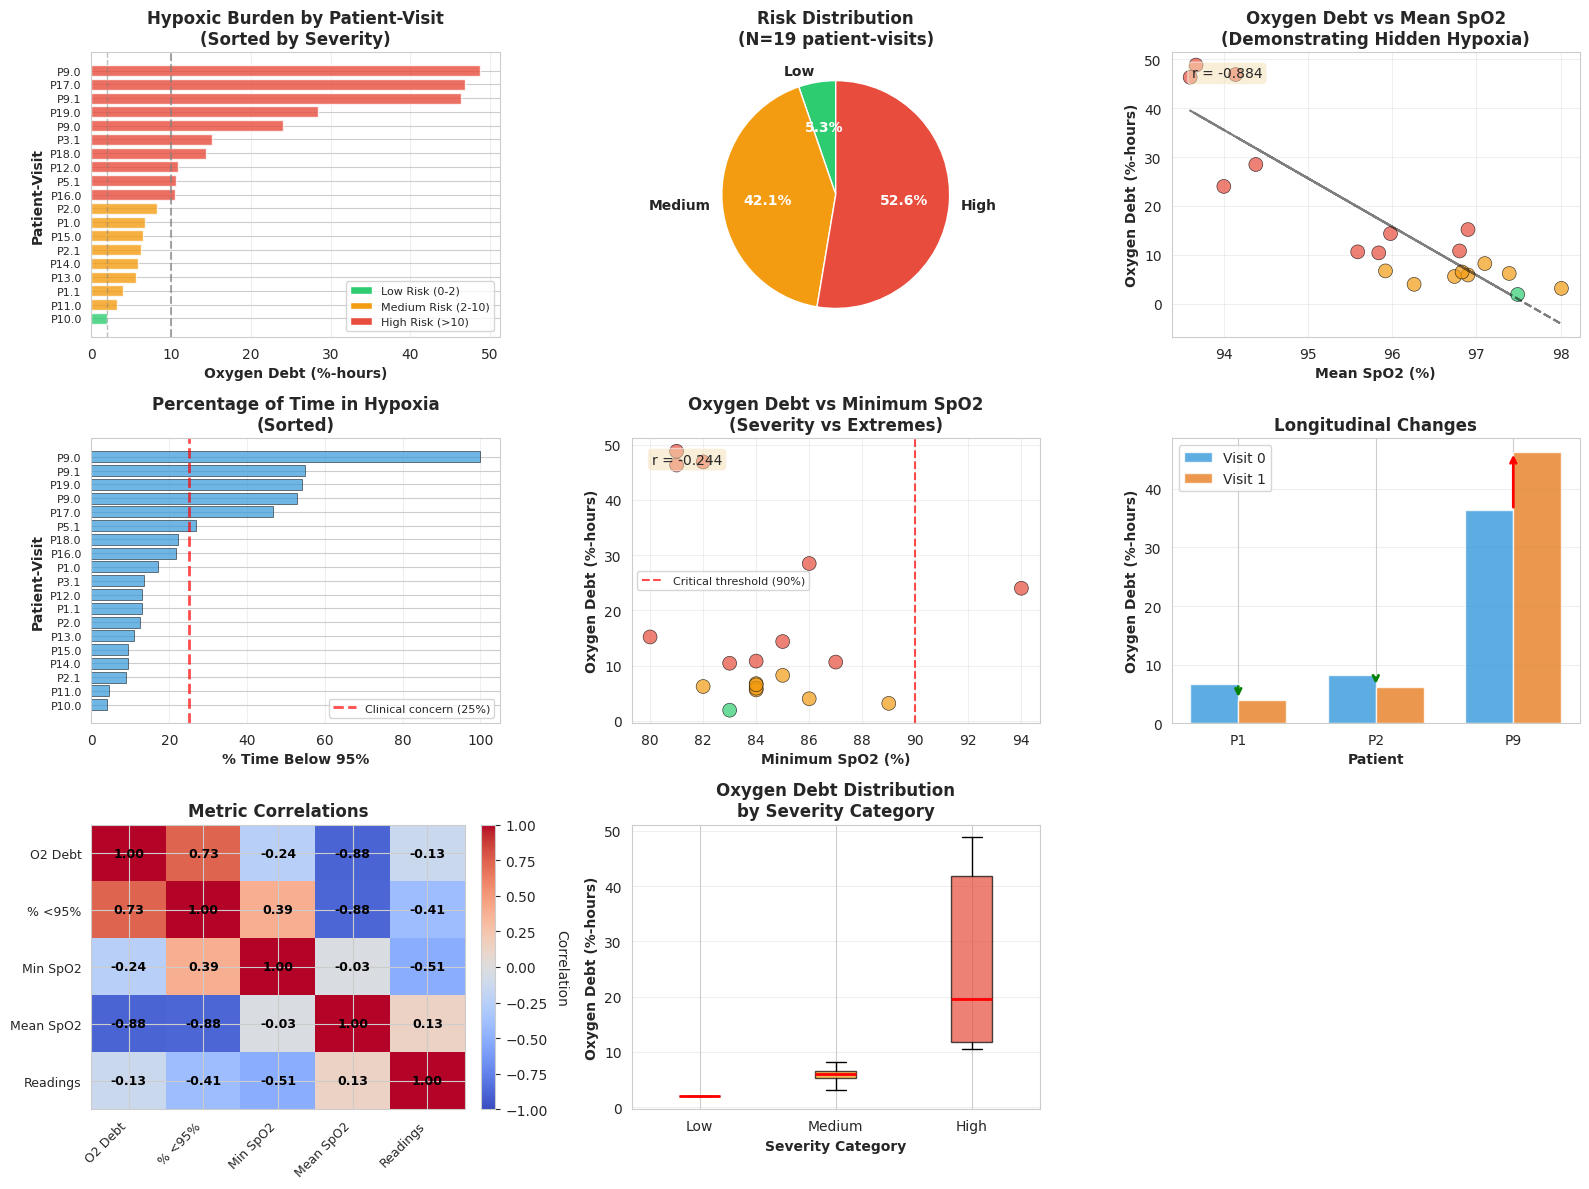

In [ ]:
import seaborn as sns

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (16, 12)
plt.rcParams['font.size'] = 10

# Create comprehensive dashboard
fig = plt.figure(figsize=(16, 12))

# Define colors for severity levels
def get_severity_color(severity):
    if severity == 'Low':
        return '#2ecc71'  # Green
    elif severity == 'Medium':
        return '#f39c12'  # Orange
    else:
        return '#e74c3c'  # Red

# ============================================================================
# PLOT 1: Hypoxic Burden Distribution with Risk Zones
# ============================================================================
ax1 = plt.subplot(3, 3, 1)

df_sorted = results_df.sort_values('oxygen_debt')
colors = [get_severity_color(s) for s in df_sorted['severity']]

bars = ax1.barh(range(len(df_sorted)), df_sorted['oxygen_debt'], color=colors, alpha=0.8)
ax1.set_yticks(range(len(df_sorted)))
ax1.set_yticklabels([f"P{int(p)}.{v}" for p, v in zip(df_sorted['patient_id'], df_sorted['visit'])], fontsize=8)
ax1.set_xlabel('Oxygen Debt (%-hours)', fontweight='bold')
ax1.set_ylabel('Patient-Visit', fontweight='bold')
ax1.set_title('Hypoxic Burden by Patient-Visit\n(Sorted by Severity)', fontweight='bold', fontsize=12)

# Risk zone lines
ax1.axvline(x=2, color='gray', linestyle='--', linewidth=1, alpha=0.5)
ax1.axvline(x=10, color='gray', linestyle='--', linewidth=1.5, alpha=0.7)

from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#2ecc71', label='Low Risk (0-2)'),
    Patch(facecolor='#f39c12', label='Medium Risk (2-10)'),
    Patch(facecolor='#e74c3c', label='High Risk (>10)')
]
ax1.legend(handles=legend_elements, loc='lower right', fontsize=8)
ax1.grid(axis='x', alpha=0.3)

# ============================================================================
# PLOT 2: Severity Distribution Pie Chart
# ============================================================================
ax2 = plt.subplot(3, 3, 2)

severity_counts = results_df['severity'].value_counts()
colors_pie = ['#2ecc71', '#f39c12', '#e74c3c']
severity_order = ['Low', 'Medium', 'High']
counts_ordered = [severity_counts.get(s, 0) for s in severity_order]

wedges, texts, autotexts = ax2.pie(counts_ordered, labels=severity_order, autopct='%1.1f%%',
                                     colors=colors_pie, startangle=90,
                                     textprops={'fontsize': 10, 'fontweight': 'bold'})
ax2.set_title(f'Risk Distribution\n(N={len(results_df)} patient-visits)', fontweight='bold', fontsize=12)

for autotext in autotexts:
    autotext.set_color('white')

# ============================================================================
# PLOT 3: Oxygen Debt vs Mean SpO2 Scatter
# ============================================================================
ax3 = plt.subplot(3, 3, 3)

scatter_colors = [get_severity_color(s) for s in results_df['severity']]
ax3.scatter(results_df['mean_spo2'], results_df['oxygen_debt'],
            c=scatter_colors, s=100, alpha=0.7, edgecolors='black', linewidth=0.5)

ax3.set_xlabel('Mean SpO2 (%)', fontweight='bold')
ax3.set_ylabel('Oxygen Debt (%-hours)', fontweight='bold')
ax3.set_title('Oxygen Debt vs Mean SpO2\n(Demonstrating Hidden Hypoxia)', fontweight='bold', fontsize=12)

# Correlation line
z = np.polyfit(results_df['mean_spo2'], results_df['oxygen_debt'], 1)
p = np.poly1d(z)
ax3.plot(results_df['mean_spo2'], p(results_df['mean_spo2']), "k--", alpha=0.5, linewidth=1.5)

corr = results_df['oxygen_debt'].corr(results_df['mean_spo2'])
ax3.text(0.05, 0.95, f'r = {corr:.3f}', transform=ax3.transAxes,
         fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
ax3.grid(alpha=0.3)

# ============================================================================
# PLOT 4: Time Below Threshold Distribution
# ============================================================================
ax4 = plt.subplot(3, 3, 4)

df_sorted_pct = results_df.sort_values('pct_below_95')
bars = ax4.barh(range(len(df_sorted_pct)), df_sorted_pct['pct_below_95'],
                color='#3498db', alpha=0.7, edgecolor='black', linewidth=0.5)

ax4.set_yticks(range(len(df_sorted_pct)))
ax4.set_yticklabels([f"P{int(p)}.{v}" for p, v in zip(df_sorted_pct['patient_id'], df_sorted_pct['visit'])], fontsize=8)
ax4.set_xlabel('% Time Below 95%', fontweight='bold')
ax4.set_ylabel('Patient-Visit', fontweight='bold')
ax4.set_title('Percentage of Time in Hypoxia\n(Sorted)', fontweight='bold', fontsize=12)

ax4.axvline(x=25, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Clinical concern (25%)')
ax4.legend(fontsize=8)
ax4.grid(axis='x', alpha=0.3)

# ============================================================================
# PLOT 5: Min SpO2 vs Oxygen Debt
# ============================================================================
ax5 = plt.subplot(3, 3, 5)

ax5.scatter(results_df['min_spo2'], results_df['oxygen_debt'],
            c=scatter_colors, s=100, alpha=0.7, edgecolors='black', linewidth=0.5)

ax5.set_xlabel('Minimum SpO2 (%)', fontweight='bold')
ax5.set_ylabel('Oxygen Debt (%-hours)', fontweight='bold')
ax5.set_title('Oxygen Debt vs Minimum SpO2\n(Severity vs Extremes)', fontweight='bold', fontsize=12)

ax5.axvline(x=90, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label='Critical threshold (90%)')
ax5.legend(fontsize=8)

corr = results_df['oxygen_debt'].corr(results_df['min_spo2'])
ax5.text(0.05, 0.95, f'r = {corr:.3f}', transform=ax5.transAxes,
         fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
ax5.grid(alpha=0.3)

# ============================================================================
# PLOT 6: Visit Comparison for Patients with Multiple Visits
# ============================================================================
ax6 = plt.subplot(3, 3, 6)

patients_both = results_df.groupby('patient_id')['visit'].nunique()
patients_with_both = patients_both[patients_both == 2].index.tolist()

if len(patients_with_both) > 0:
    visit0_data = []
    visit1_data = []
    patient_labels = []

    for patient in sorted(patients_with_both):
        v0 = results_df[(results_df['patient_id'] == patient) & (results_df['visit'] == 0)]['oxygen_debt'].values
        v1 = results_df[(results_df['patient_id'] == patient) & (results_df['visit'] == 1)]['oxygen_debt'].values

        if len(v0) > 0 and len(v1) > 0:
            visit0_data.append(v0.mean())
            visit1_data.append(v1.mean())
            patient_labels.append(f'P{patient}')

    x = np.arange(len(patient_labels))
    width = 0.35

    bars1 = ax6.bar(x - width/2, visit0_data, width, label='Visit 0', color='#3498db', alpha=0.8)
    bars2 = ax6.bar(x + width/2, visit1_data, width, label='Visit 1', color='#e67e22', alpha=0.8)

    ax6.set_xlabel('Patient', fontweight='bold')
    ax6.set_ylabel('Oxygen Debt (%-hours)', fontweight='bold')
    ax6.set_title('Longitudinal Changes\n(Visit 0 vs Visit 1)', fontweight='bold', fontsize=12)
    ax6.set_xticks(x)
    ax6.set_xticklabels(patient_labels)
    ax6.legend()
    ax6.grid(axis='y', alpha=0.3)

    # Arrows showing change
    for i, (v0, v1) in enumerate(zip(visit0_data, visit1_data)):
        if v1 > v0:
            ax6.annotate('', xy=(i, v1), xytext=(i, v0),
                        arrowprops=dict(arrowstyle='->', color='red', lw=2))
        else:
            ax6.annotate('', xy=(i, v1), xytext=(i, v0),
                        arrowprops=dict(arrowstyle='->', color='green', lw=2))
else:
    ax6.text(0.5, 0.5, 'No patients with\nmultiple visits',
             ha='center', va='center', transform=ax6.transAxes, fontsize=12)

ax6.set_title('Longitudinal Changes', fontweight='bold', fontsize=12)

# ============================================================================
# PLOT 7: Correlation Heatmap
# ============================================================================
ax7 = plt.subplot(3, 3, 7)

corr_cols = ['oxygen_debt', 'pct_below_95', 'min_spo2', 'mean_spo2', 'total_readings']
corr_matrix = results_df[corr_cols].corr()

im = ax7.imshow(corr_matrix, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)

ax7.set_xticks(np.arange(len(corr_cols)))
ax7.set_yticks(np.arange(len(corr_cols)))
ax7.set_xticklabels(['O2 Debt', '% <95%', 'Min SpO2', 'Mean SpO2', 'Readings'],
                     rotation=45, ha='right', fontsize=9)
ax7.set_yticklabels(['O2 Debt', '% <95%', 'Min SpO2', 'Mean SpO2', 'Readings'], fontsize=9)

# Add correlation values
for i in range(len(corr_cols)):
    for j in range(len(corr_cols)):
        text = ax7.text(j, i, f'{corr_matrix.iloc[i, j]:.2f}',
                       ha="center", va="center", color="black", fontsize=9, fontweight='bold')

ax7.set_title('Metric Correlations', fontweight='bold', fontsize=12)

cbar = plt.colorbar(im, ax=ax7, fraction=0.046, pad=0.04)
cbar.set_label('Correlation', rotation=270, labelpad=15)

# ============================================================================
# PLOT 8: Box Plot by Severity
# ============================================================================
ax8 = plt.subplot(3, 3, 8)

severity_order = ['Low', 'Medium', 'High']
severity_data = [results_df[results_df['severity'] == s]['oxygen_debt'].values for s in severity_order]

bp = ax8.boxplot(severity_data, tick_labels=severity_order, patch_artist=True,
                 boxprops=dict(facecolor='lightblue', alpha=0.7),
                 medianprops=dict(color='red', linewidth=2))

for patch, color in zip(bp['boxes'], colors_pie):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax8.set_ylabel('Oxygen Debt (%-hours)', fontweight='bold')
ax8.set_xlabel('Severity Category', fontweight='bold')
ax8.set_title('Oxygen Debt Distribution\nby Severity Category', fontweight='bold', fontsize=12)
ax8.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()



# Hypoxic Burden Results - Explanations

## Primary Metric

### **oxygen_debt**

**What it means**: Total oxygen deprivation accumulated over the measurement period

**Formula**:
```
oxygen_debt = Σ max(0, 95 - SpO2_i) × time_weight
```

**Units**: Percentage-hours
- Example: 10 %-hours = being 10% below threshold for 1 hour, OR 5% below for 2 hours, OR 1% below for 10 hours

**Range in data**: 1.92 to 48.80 %-hours

**Clinical interpretation**:
- **0-2 %-hours**: Low/negligible hypoxic burden ✓
- **2-10 %-hours**: Moderate burden (may warrant monitoring) ⚠️
- **>10 %-hours**: High burden (clinically significant) ⚠️⚠️

---

## Supporting Metrics

### **readings_below_95**
- **Description**: Count of SpO2 measurements < 95%
- **Interpretation**: Higher count = more frequent desaturation events

### **pct_below_95** (%)
- **Description**: Percentage of time spent below 95% threshold
- **Example**: 50% = half the measurements were hypoxic
- **Normal**: <10%
- **Concern**: >25%

### **min_spo2** (%)
- **Description**: Lowest SpO2 value recorded during the measurement period
- **Normal**: >90%
- **Mild hypoxemia**: 85-90%
- **Moderate hypoxemia**: 80-85%
- **Severe hypoxemia**: <80%

### **severity**
- **Description**: Risk category based on oxygen_debt value
- **Categories**:
  - **Low**: oxygen_debt < 2 %-hours
  - **Medium**: oxygen_debt 2-10 %-hours
  - **High**: oxygen_debt > 10 %-hours

---

## Key Insight

**Why hypoxic burden matters:**

A patient with **mean_spo2 = 96%** might appear healthy based on traditional metrics, but if their **oxygen_debt = 48.80 %-hours**, this reveals they experienced significant hypoxic events that the simple average completely masks!

**Example from your data:**

| Patient | mean_spo2 | oxygen_debt | Interpretation |
|---------|-----------|-------------|----------------|
| 10 | 97.49% | 1.92 %-hours | Good oxygenation, minimal burden |
| 9 | 93.67% | 48.80 %-hours | Poor oxygenation, severe burden |

Both metrics tell different stories - **oxygen debt captures the full picture** of oxygen deprivation.

---

## Clinical Significance

### **What each severity level means:**

**Low (0-2 %-hours)**
- Minimal oxygen deprivation
- Occasional brief desaturations
- Generally healthy oxygenation pattern

**Medium (2-10 %-hours)**
- Moderate oxygen deprivation
- May indicate sleep apnea, respiratory issues, or positional hypoxemia
- Recommend monitoring and potential clinical evaluation

**High (>10 %-hours)**
- Significant oxygen deprivation
- Strong indicator of underlying respiratory/cardiovascular issues
- Requires clinical attention and intervention

---

## Dataset Summary

- **Total patients**: 15 unique patients
- **Total patient-visit-days**: 19 measurements
- **Patients with multiple visits**: 3 (allowing longitudinal tracking)

**Severity distribution:**
- High risk: 10 cases (52.6%)
- Medium risk: 8 cases (42.1%)
- Low risk: 1 case (5.3%)

**Key finding**: Majority of cohort shows moderate to high hypoxic burden, suggesting this is a high-risk population requiring clinical attention.

# **Method number 2**

In [ ]:
def calculate_threshold_metrics(spo2_readings, thresholds=[90, 95]):
    """
    Calculate time-based metrics for SpO2 threshold crossings.

    Parameters:
    -----------
    spo2_readings : array-like
        SpO2 values for a single day
    thresholds : list, default=[90, 95]
        SpO2 thresholds to analyze (%)

    Returns:
    --------
    dict with threshold-based metrics
    """

    spo2_array = np.array(spo2_readings)
    n_readings = len(spo2_array)

    results = {
        'total_readings': n_readings,
        'mean_spo2': round(spo2_array.mean(), 2),
        'median_spo2': int(np.median(spo2_array)),
        'min_spo2': int(spo2_array.min()),
        'max_spo2': int(spo2_array.max())
    }

    # Calculate metrics for each threshold
    for threshold in thresholds:
        below_threshold = spo2_array < threshold
        count_below = below_threshold.sum()
        pct_below = 100 * count_below / n_readings

        # Time below threshold (assuming uniform 24h distribution)
        time_below_hours = 24 * (count_below / n_readings)

        results[f'count_below_{threshold}'] = int(count_below)
        results[f'pct_below_{threshold}'] = round(pct_below, 2)
        results[f'time_below_{threshold}_hours'] = round(time_below_hours, 2)

        # Calculate average depth when below threshold
        if count_below > 0:
            depths_below = threshold - spo2_array[below_threshold]
            avg_depth = depths_below.mean()
            max_depth = depths_below.max()
            results[f'avg_depth_below_{threshold}'] = round(avg_depth, 2)
            results[f'max_depth_below_{threshold}'] = round(max_depth, 2)
        else:
            results[f'avg_depth_below_{threshold}'] = 0.0
            results[f'max_depth_below_{threshold}'] = 0.0

    # Clinical categorization based on time below 90%
    time_below_90 = results['time_below_90_hours']
    if time_below_90 == 0:
        results['severity_90'] = 'Normal'
    elif time_below_90 < 1:
        results['severity_90'] = 'Mild'
    elif time_below_90 < 4:
        results['severity_90'] = 'Moderate'
    else:
        results['severity_90'] = 'Severe'

    # Risk flag based on percentage below 95%
    pct_below_95 = results['pct_below_95']
    if pct_below_95 < 10:
        results['risk_flag'] = 'Low'
    elif pct_below_95 < 25:
        results['risk_flag'] = 'Medium'
    else:
        results['risk_flag'] = 'High'

    return results

In [ ]:
# Calculate threshold metrics for each patient-visit-day
results_method2 = []

for (patient_id, visit, date), group in df.groupby(['patient_id', 'visit', 'date']):

    spo2_values = group['SPO2'].values

    # Calculate threshold metrics
    metrics = calculate_threshold_metrics(spo2_values, thresholds=[90, 95])

    results_method2.append({
        'patient_id': patient_id,
        'visit': visit,
        'user_id': group['USER_ID'].iloc[0],
        'date': date,
        **metrics  # Unpack all metrics into the result
    })

# Convert to DataFrame
results_method2_df = pd.DataFrame(results_method2)

# Sort by patient_id and visit
results_method2_df = results_method2_df.sort_values(['patient_id', 'visit', 'date']).reset_index(drop=True)

print("\nSample Results (first 10 patient-visit-days):")
print("=" * 120)

# Select key columns for display
display_cols = ['patient_id', 'visit', 'date', 'mean_spo2', 'min_spo2',
                'pct_below_90', 'pct_below_95', 'time_below_90_hours',
                'time_below_95_hours', 'severity_90', 'risk_flag']
print(results_method2_df[display_cols].head(10).to_string(index=False))


Sample Results (first 10 patient-visit-days):
 patient_id  visit       date  mean_spo2  min_spo2  pct_below_90  pct_below_95  time_below_90_hours  time_below_95_hours severity_90 risk_flag
          1      0 2025-06-15      95.92        84          0.53         17.11                 0.13                 4.11        Mild    Medium
          1      1 2025-10-09      96.26        86          0.24         13.05                 0.06                 3.13        Mild    Medium
          2      0 2025-06-15      97.10        85          1.37         12.57                 0.33                 3.02        Mild    Medium
          2      1 2025-10-09      97.39        82          1.04          8.78                 0.25                 2.11        Mild       Low
          3      1 2025-10-09      96.90        80          3.96         13.51                 0.95                 3.24        Mild    Medium
          5      1 2025-10-09      95.59        87          0.73         26.88                 

In [ ]:
print(f"\n1. Dataset Overview:")
print(f"   - Total unique patients: {results_method2_df['patient_id'].nunique()}")
print(f"   - Total patient-visit-days: {len(results_method2_df)}")

print("\n2. Time Below 90% Threshold:")
print(f"   - Mean: {results_method2_df['time_below_90_hours'].mean():.2f} hours")
print(f"   - Median: {results_method2_df['time_below_90_hours'].median():.2f} hours")
print(f"   - Max: {results_method2_df['time_below_90_hours'].max():.2f} hours")
print(f"   - Patients with >0 hours: {(results_method2_df['time_below_90_hours'] > 0).sum()} ({100*(results_method2_df['time_below_90_hours'] > 0).sum()/len(results_method2_df):.1f}%)")

print("\n3. Time Below 95% Threshold:")
print(f"   - Mean: {results_method2_df['time_below_95_hours'].mean():.2f} hours")
print(f"   - Median: {results_method2_df['time_below_95_hours'].median():.2f} hours")
print(f"   - Max: {results_method2_df['time_below_95_hours'].max():.2f} hours")

print("\n4. Severity Distribution (based on time <90%):")
severity_counts = results_method2_df['severity_90'].value_counts()
for severity in ['Normal', 'Mild', 'Moderate', 'Severe']:
    count = severity_counts.get(severity, 0)
    pct = 100 * count / len(results_method2_df)
    print(f"   - {severity}: {count} ({pct:.1f}%)")

print("\n5. Risk Flag Distribution (based on % time <95%):")
risk_counts = results_method2_df['risk_flag'].value_counts()
for risk in ['Low', 'Medium', 'High']:
    count = risk_counts.get(risk, 0)
    pct = 100 * count / len(results_method2_df)
    print(f"   - {risk}: {count} ({pct:.1f}%)")

print("\n6. Depth Analysis (when below thresholds):")
print(f"   Below 90%:")
print(f"     - Average depth: {results_method2_df['avg_depth_below_90'].mean():.2f}%")
print(f"     - Max depth observed: {results_method2_df['max_depth_below_90'].max():.2f}%")
print(f"   Below 95%:")
print(f"     - Average depth: {results_method2_df['avg_depth_below_95'].mean():.2f}%")
print(f"     - Max depth observed: {results_method2_df['max_depth_below_95'].max():.2f}%")

print("\n7. Longitudinal Changes (patients with both visits):")
print("-" * 70)
patients_both = results_method2_df.groupby('patient_id')['visit'].nunique()
patients_with_both = patients_both[patients_both == 2].index.tolist()

if len(patients_with_both) > 0:
    for patient in sorted(patients_with_both):
        v0_time90 = results_method2_df[(results_method2_df['patient_id'] == patient) & (results_method2_df['visit'] == 0)]['time_below_90_hours'].mean()
        v1_time90 = results_method2_df[(results_method2_df['patient_id'] == patient) & (results_method2_df['visit'] == 1)]['time_below_90_hours'].mean()

        v0_time95 = results_method2_df[(results_method2_df['patient_id'] == patient) & (results_method2_df['visit'] == 0)]['time_below_95_hours'].mean()
        v1_time95 = results_method2_df[(results_method2_df['patient_id'] == patient) & (results_method2_df['visit'] == 1)]['time_below_95_hours'].mean()

        change90 = v1_time90 - v0_time90
        change95 = v1_time95 - v0_time95

        print(f"   Patient {patient}:")
        print(f"     Time <90%: V0={v0_time90:.2f}h, V1={v1_time90:.2f}h, Change={change90:+.2f}h")
        print(f"     Time <95%: V0={v0_time95:.2f}h, V1={v1_time95:.2f}h, Change={change95:+.2f}h")


1. Dataset Overview:
   - Total unique patients: 15
   - Total patient-visit-days: 19

2. Time Below 90% Threshold:
   - Mean: 0.70 hours
   - Median: 0.25 hours
   - Max: 3.04 hours
   - Patients with >0 hours: 18 (94.7%)

3. Time Below 95% Threshold:
   - Mean: 6.26 hours
   - Median: 3.24 hours
   - Max: 24.00 hours

4. Severity Distribution (based on time <90%):
   - Normal: 1 (5.3%)
   - Mild: 15 (78.9%)
   - Moderate: 3 (15.8%)
   - Severe: 0 (0.0%)

5. Risk Flag Distribution (based on % time <95%):
   - Low: 5 (26.3%)
   - Medium: 8 (42.1%)
   - High: 6 (31.6%)

6. Depth Analysis (when below thresholds):
   Below 90%:
     - Average depth: 3.35%
     - Max depth observed: 10.00%
   Below 95%:
     - Average depth: 2.65%
     - Max depth observed: 15.00%

7. Longitudinal Changes (patients with both visits):
----------------------------------------------------------------------
   Patient 1:
     Time <90%: V0=0.13h, V1=0.06h, Change=-0.07h
     Time <95%: V0=4.11h, V1=3.13h, Cha

In [ ]:
# Select only needed columns from Method 1 to avoid duplication
method1_subset = results_df[['patient_id', 'visit', 'date', 'oxygen_debt', 'severity']]
method1_subset = method1_subset.rename(columns={'severity': 'severity_m1'})

# Merge both methods
comparison_df = method1_subset.merge(
    results_method2_df,
    on=['patient_id', 'visit', 'date']
)

print("\n1. Correlation Analysis:")
print("-" * 70)

corr_debt_time90 = comparison_df['oxygen_debt'].corr(comparison_df['time_below_90_hours'])
corr_debt_time95 = comparison_df['oxygen_debt'].corr(comparison_df['time_below_95_hours'])
corr_debt_pct95 = comparison_df['oxygen_debt'].corr(comparison_df['pct_below_95'])

print(f"Oxygen Debt vs Time Below 90%: r = {corr_debt_time90:.3f}")
print(f"Oxygen Debt vs Time Below 95%: r = {corr_debt_time95:.3f}")
print(f"Oxygen Debt vs % Below 95%: r = {corr_debt_pct95:.3f}")

print("\n2. Severity Agreement:")
print("-" * 70)

severity_comparison = pd.crosstab(
    comparison_df['severity_m1'],  # Method 1
    comparison_df['risk_flag'],     # Method 2
    margins=True
)

print("\nMethod 1 (Hypoxic Burden) vs Method 2 (Risk Flag):")
print(severity_comparison)

agreement = (comparison_df['severity_m1'] == comparison_df['risk_flag']).sum()
agreement_pct = 100 * agreement / len(comparison_df)
print(f"\nDirect agreement: {agreement}/{len(comparison_df)} ({agreement_pct:.1f}%)")

print("\n3. High Risk Patients:")
print("-" * 70)

high_both = comparison_df[(comparison_df['severity_m1'] == 'High') & (comparison_df['risk_flag'] == 'High')]
high_m1_only = comparison_df[(comparison_df['severity_m1'] == 'High') & (comparison_df['risk_flag'] != 'High')]
high_m2_only = comparison_df[(comparison_df['severity_m1'] != 'High') & (comparison_df['risk_flag'] == 'High')]

print(f"High risk by BOTH methods: {len(high_both)} patients")
print(f"High risk by Method 1 only: {len(high_m1_only)} patients")
print(f"High risk by Method 2 only: {len(high_m2_only)} patients")



1. Correlation Analysis:
----------------------------------------------------------------------
Oxygen Debt vs Time Below 90%: r = 0.896
Oxygen Debt vs Time Below 95%: r = 0.727
Oxygen Debt vs % Below 95%: r = 0.727

2. Severity Agreement:
----------------------------------------------------------------------

Method 1 (Hypoxic Burden) vs Method 2 (Risk Flag):
risk_flag    High  Low  Medium  All
severity_m1                        
High            6    0       4   10
Low             0    1       0    1
Medium          0    4       4    8
All             6    5       8   19

Direct agreement: 11/19 (57.9%)

3. High Risk Patients:
----------------------------------------------------------------------
High risk by BOTH methods: 6 patients
High risk by Method 1 only: 4 patients
High risk by Method 2 only: 0 patients


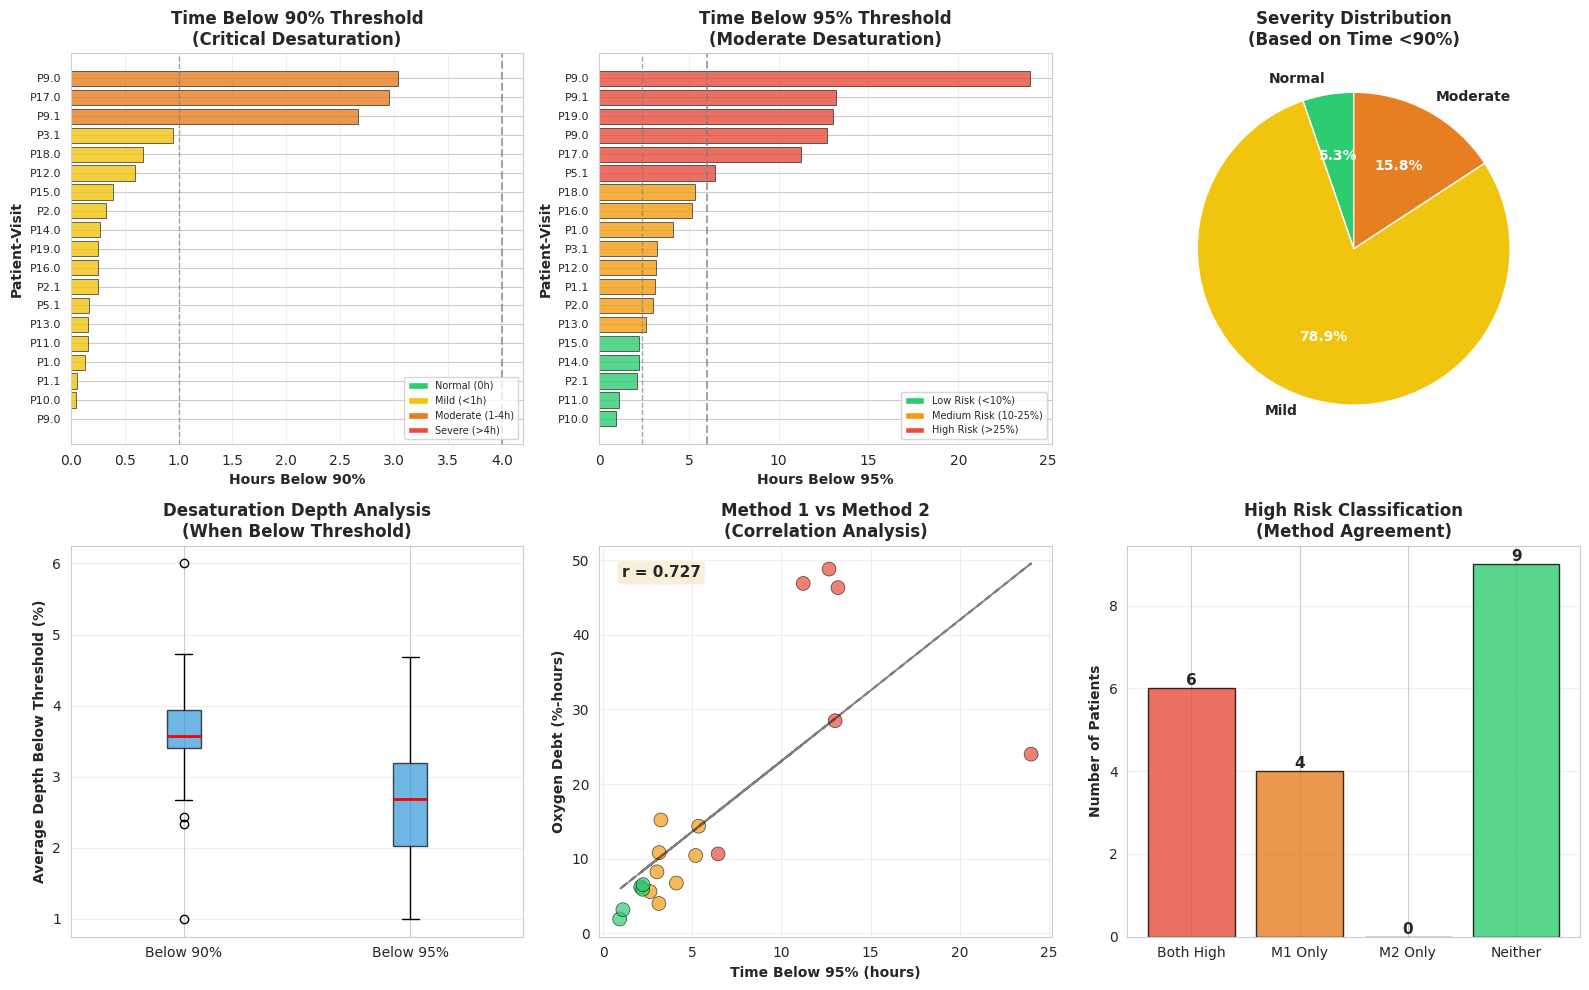

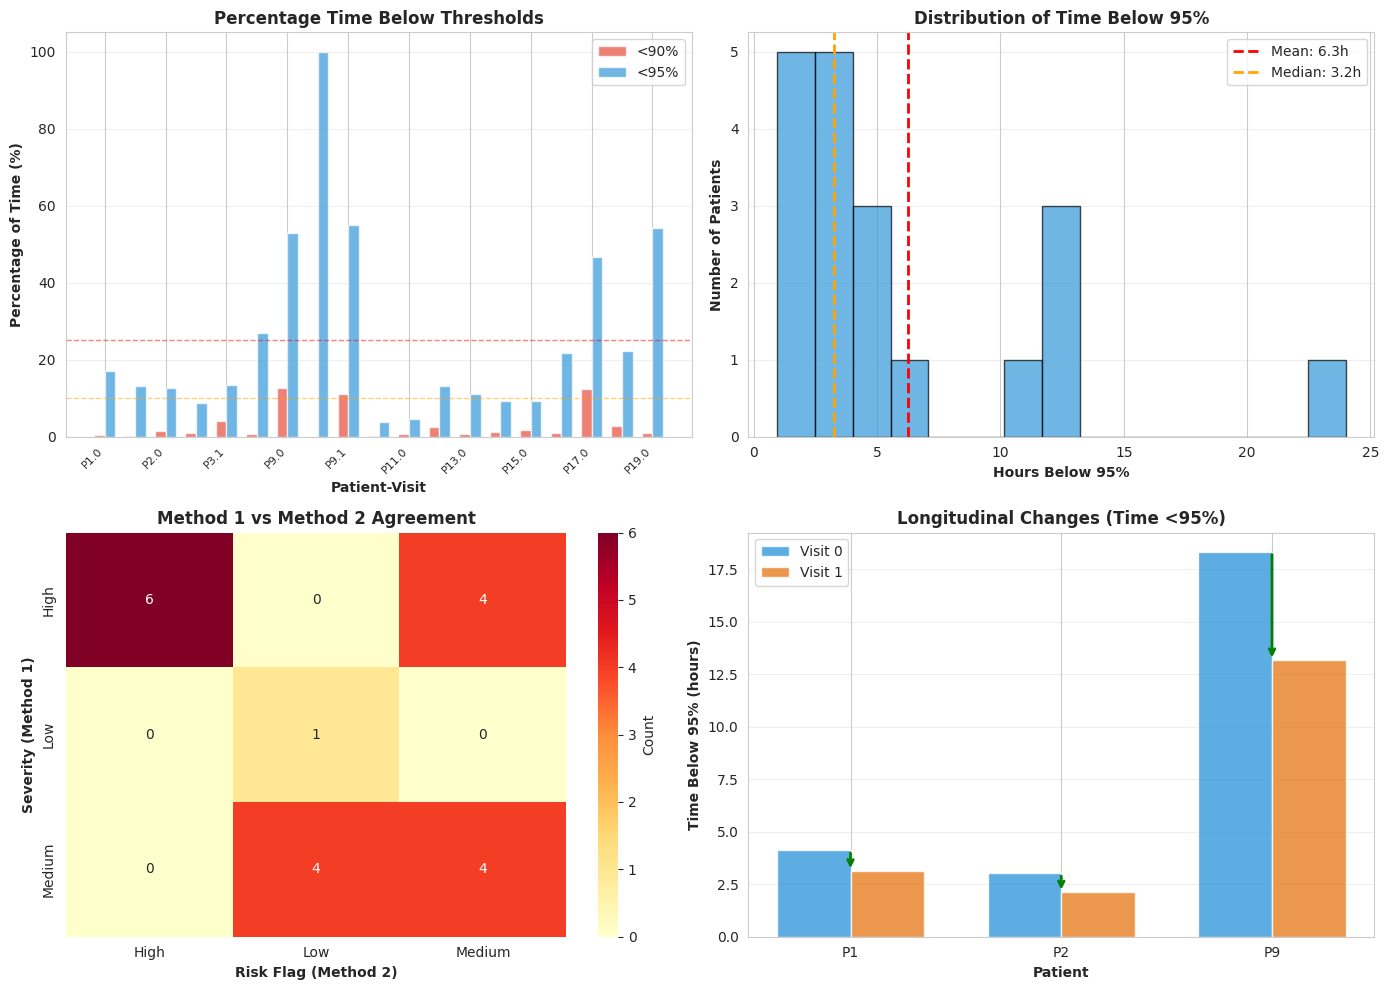

In [ ]:
# ============================================================================
# METHOD 2 VISUALIZATIONS: Threshold-Based Time Analysis
# ============================================================================

import seaborn as sns

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (16, 10)
plt.rcParams['font.size'] = 10

# Create comprehensive dashboard for Method 2
fig = plt.figure(figsize=(16, 10))

# ============================================================================
# PLOT 1: Time Below 90% by Patient
# ============================================================================
ax1 = plt.subplot(2, 3, 1)

df_sorted = results_method2_df.sort_values('time_below_90_hours')

# Color code by severity
severity_colors = {
    'Normal': '#2ecc71',   # Green
    'Mild': '#f1c40f',     # Yellow
    'Moderate': '#e67e22', # Orange
    'Severe': '#e74c3c'    # Red
}
colors = [severity_colors[s] for s in df_sorted['severity_90']]

bars = ax1.barh(range(len(df_sorted)), df_sorted['time_below_90_hours'],
                color=colors, alpha=0.8, edgecolor='black', linewidth=0.5)

ax1.set_yticks(range(len(df_sorted)))
ax1.set_yticklabels([f"P{int(p)}.{v}" for p, v in zip(df_sorted['patient_id'], df_sorted['visit'])],
                     fontsize=8)
ax1.set_xlabel('Hours Below 90%', fontweight='bold')
ax1.set_ylabel('Patient-Visit', fontweight='bold')
ax1.set_title('Time Below 90% Threshold\n(Critical Desaturation)', fontweight='bold', fontsize=12)

# Add severity thresholds
ax1.axvline(x=1, color='gray', linestyle='--', linewidth=1, alpha=0.7, label='Mild/Moderate (1h)')
ax1.axvline(x=4, color='gray', linestyle='--', linewidth=1.5, alpha=0.7, label='Moderate/Severe (4h)')

from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#2ecc71', label='Normal (0h)'),
    Patch(facecolor='#f1c40f', label='Mild (<1h)'),
    Patch(facecolor='#e67e22', label='Moderate (1-4h)'),
    Patch(facecolor='#e74c3c', label='Severe (>4h)')
]
ax1.legend(handles=legend_elements, loc='lower right', fontsize=7)
ax1.grid(axis='x', alpha=0.3)

# ============================================================================
# PLOT 2: Time Below 95% by Patient
# ============================================================================
ax2 = plt.subplot(2, 3, 2)

df_sorted_95 = results_method2_df.sort_values('time_below_95_hours')

# Color by risk flag
risk_colors = {
    'Low': '#2ecc71',
    'Medium': '#f39c12',
    'High': '#e74c3c'
}
colors_95 = [risk_colors[r] for r in df_sorted_95['risk_flag']]

bars = ax2.barh(range(len(df_sorted_95)), df_sorted_95['time_below_95_hours'],
                color=colors_95, alpha=0.8, edgecolor='black', linewidth=0.5)

ax2.set_yticks(range(len(df_sorted_95)))
ax2.set_yticklabels([f"P{int(p)}.{v}" for p, v in zip(df_sorted_95['patient_id'], df_sorted_95['visit'])],
                     fontsize=8)
ax2.set_xlabel('Hours Below 95%', fontweight='bold')
ax2.set_ylabel('Patient-Visit', fontweight='bold')
ax2.set_title('Time Below 95% Threshold\n(Moderate Desaturation)', fontweight='bold', fontsize=12)

# Add risk thresholds (based on % which translates to hours)
ax2.axvline(x=2.4, color='gray', linestyle='--', linewidth=1, alpha=0.7, label='Low/Med (10%=2.4h)')
ax2.axvline(x=6, color='gray', linestyle='--', linewidth=1.5, alpha=0.7, label='Med/High (25%=6h)')

legend_elements = [
    Patch(facecolor='#2ecc71', label='Low Risk (<10%)'),
    Patch(facecolor='#f39c12', label='Medium Risk (10-25%)'),
    Patch(facecolor='#e74c3c', label='High Risk (>25%)')
]
ax2.legend(handles=legend_elements, loc='lower right', fontsize=7)
ax2.grid(axis='x', alpha=0.3)

# ============================================================================
# PLOT 3: Severity Distribution Pie Chart
# ============================================================================
ax3 = plt.subplot(2, 3, 3)

severity_counts = results_method2_df['severity_90'].value_counts()
severity_order = ['Normal', 'Mild', 'Moderate', 'Severe']
counts = [severity_counts.get(s, 0) for s in severity_order]
colors_pie = ['#2ecc71', '#f1c40f', '#e67e22', '#e74c3c']

# Only include non-zero categories
non_zero_idx = [i for i, c in enumerate(counts) if c > 0]
counts_filtered = [counts[i] for i in non_zero_idx]
labels_filtered = [severity_order[i] for i in non_zero_idx]
colors_filtered = [colors_pie[i] for i in non_zero_idx]

wedges, texts, autotexts = ax3.pie(counts_filtered, labels=labels_filtered, autopct='%1.1f%%',
                                     colors=colors_filtered, startangle=90,
                                     textprops={'fontsize': 10, 'fontweight': 'bold'})
ax3.set_title('Severity Distribution\n(Based on Time <90%)', fontweight='bold', fontsize=12)

for autotext in autotexts:
    autotext.set_color('white')

# ============================================================================
# PLOT 4: Depth Analysis Box Plot
# ============================================================================
ax4 = plt.subplot(2, 3, 4)

# Prepare data for box plot
depth_data = []
depth_labels = []

# Filter patients with data below each threshold
patients_below_90 = results_method2_df[results_method2_df['avg_depth_below_90'] > 0]
patients_below_95 = results_method2_df[results_method2_df['avg_depth_below_95'] > 0]

if len(patients_below_90) > 0:
    depth_data.append(patients_below_90['avg_depth_below_90'].values)
    depth_labels.append('Below 90%')

if len(patients_below_95) > 0:
    depth_data.append(patients_below_95['avg_depth_below_95'].values)
    depth_labels.append('Below 95%')

if len(depth_data) > 0:
    bp = ax4.boxplot(depth_data, tick_labels=depth_labels, patch_artist=True,
                     boxprops=dict(facecolor='#3498db', alpha=0.7),
                     medianprops=dict(color='red', linewidth=2))

    ax4.set_ylabel('Average Depth Below Threshold (%)', fontweight='bold')
    ax4.set_title('Desaturation Depth Analysis\n(When Below Threshold)', fontweight='bold', fontsize=12)
    ax4.grid(axis='y', alpha=0.3)

# ============================================================================
# PLOT 5: Correlation with Method 1
# ============================================================================
ax5 = plt.subplot(2, 3, 5)

# Scatter plot: Oxygen Debt vs Time Below 95%
scatter_colors = [risk_colors[r] for r in comparison_df['risk_flag']]

ax5.scatter(comparison_df['time_below_95_hours'], comparison_df['oxygen_debt'],
            c=scatter_colors, s=100, alpha=0.7, edgecolors='black', linewidth=0.5)

ax5.set_xlabel('Time Below 95% (hours)', fontweight='bold')
ax5.set_ylabel('Oxygen Debt (%-hours)', fontweight='bold')
ax5.set_title('Method 1 vs Method 2\n(Correlation Analysis)', fontweight='bold', fontsize=12)

# Add correlation line
z = np.polyfit(comparison_df['time_below_95_hours'], comparison_df['oxygen_debt'], 1)
p = np.poly1d(z)
ax5.plot(comparison_df['time_below_95_hours'], p(comparison_df['time_below_95_hours']),
         "k--", alpha=0.5, linewidth=1.5)

# Add correlation text
corr = comparison_df['oxygen_debt'].corr(comparison_df['time_below_95_hours'])
ax5.text(0.05, 0.95, f'r = {corr:.3f}', transform=ax5.transAxes,
         fontsize=11, verticalalignment='top', fontweight='bold',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

ax5.grid(alpha=0.3)

# ============================================================================
# PLOT 6: Risk Category Comparison
# ============================================================================
ax6 = plt.subplot(2, 3, 6)

# Create comparison data
risk_comparison_data = {
    'Both High': len(high_both),
    'M1 Only': len(high_m1_only),
    'M2 Only': len(high_m2_only),
    'Neither': len(comparison_df) - len(high_both) - len(high_m1_only) - len(high_m2_only)
}

categories = list(risk_comparison_data.keys())
values = list(risk_comparison_data.values())
colors_bar = ['#e74c3c', '#e67e22', '#f39c12', '#2ecc71']

bars = ax6.bar(categories, values, color=colors_bar, alpha=0.8, edgecolor='black', linewidth=1)

ax6.set_ylabel('Number of Patients', fontweight='bold')
ax6.set_title('High Risk Classification\n(Method Agreement)', fontweight='bold', fontsize=12)
ax6.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, val in zip(bars, values):
    height = bar.get_height()
    ax6.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(val)}',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()


# ============================================================================
# ADDITIONAL VISUALIZATION: Clinical Thresholds Comparison
# ============================================================================

fig2, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Percentage Below Thresholds Comparison
patient_labels = [f"P{int(p)}.{v}" for p, v in zip(results_method2_df['patient_id'], results_method2_df['visit'])]
x = np.arange(len(patient_labels))
width = 0.35

bars1 = ax1.bar(x - width/2, results_method2_df['pct_below_90'], width,
                label='<90%', color='#e74c3c', alpha=0.7)
bars2 = ax1.bar(x + width/2, results_method2_df['pct_below_95'], width,
                label='<95%', color='#3498db', alpha=0.7)

ax1.set_xlabel('Patient-Visit', fontweight='bold')
ax1.set_ylabel('Percentage of Time (%)', fontweight='bold')
ax1.set_title('Percentage Time Below Thresholds', fontweight='bold', fontsize=12)
ax1.set_xticks(x[::2])  # Show every other label to avoid crowding
ax1.set_xticklabels([patient_labels[i] for i in range(0, len(patient_labels), 2)],
                     rotation=45, ha='right', fontsize=8)
ax1.legend()
ax1.grid(axis='y', alpha=0.3)
ax1.axhline(y=10, color='orange', linestyle='--', linewidth=1, alpha=0.5, label='10% threshold')
ax1.axhline(y=25, color='red', linestyle='--', linewidth=1, alpha=0.5, label='25% threshold')

# Plot 2: Histogram of Time Below 95%
ax2.hist(results_method2_df['time_below_95_hours'], bins=15,
         color='#3498db', alpha=0.7, edgecolor='black')
ax2.set_xlabel('Hours Below 95%', fontweight='bold')
ax2.set_ylabel('Number of Patients', fontweight='bold')
ax2.set_title('Distribution of Time Below 95%', fontweight='bold', fontsize=12)
ax2.axvline(x=results_method2_df['time_below_95_hours'].mean(),
            color='red', linestyle='--', linewidth=2, label=f"Mean: {results_method2_df['time_below_95_hours'].mean():.1f}h")
ax2.axvline(x=results_method2_df['time_below_95_hours'].median(),
            color='orange', linestyle='--', linewidth=2, label=f"Median: {results_method2_df['time_below_95_hours'].median():.1f}h")
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# Plot 3: Risk Flag vs Severity Heatmap
severity_risk_crosstab = pd.crosstab(comparison_df['severity_m1'], comparison_df['risk_flag'])
sns.heatmap(severity_risk_crosstab, annot=True, fmt='d', cmap='YlOrRd',
            ax=ax3, cbar_kws={'label': 'Count'})
ax3.set_xlabel('Risk Flag (Method 2)', fontweight='bold')
ax3.set_ylabel('Severity (Method 1)', fontweight='bold')
ax3.set_title('Method 1 vs Method 2 Agreement', fontweight='bold', fontsize=12)

# Plot 4: Longitudinal Changes
if len(patients_with_both) > 0:
    patient_ids = sorted(patients_with_both)
    x_pos = np.arange(len(patient_ids))

    visit0_vals = []
    visit1_vals = []

    for pid in patient_ids:
        v0 = results_method2_df[(results_method2_df['patient_id'] == pid) &
                                 (results_method2_df['visit'] == 0)]['time_below_95_hours'].mean()
        v1 = results_method2_df[(results_method2_df['patient_id'] == pid) &
                                 (results_method2_df['visit'] == 1)]['time_below_95_hours'].mean()
        visit0_vals.append(v0)
        visit1_vals.append(v1)

    width = 0.35
    bars1 = ax4.bar(x_pos - width/2, visit0_vals, width, label='Visit 0',
                    color='#3498db', alpha=0.8)
    bars2 = ax4.bar(x_pos + width/2, visit1_vals, width, label='Visit 1',
                    color='#e67e22', alpha=0.8)

    ax4.set_xlabel('Patient', fontweight='bold')
    ax4.set_ylabel('Time Below 95% (hours)', fontweight='bold')
    ax4.set_title('Longitudinal Changes (Time <95%)', fontweight='bold', fontsize=12)
    ax4.set_xticks(x_pos)
    ax4.set_xticklabels([f'P{pid}' for pid in patient_ids])
    ax4.legend()
    ax4.grid(axis='y', alpha=0.3)

    # Add arrows showing direction of change
    for i, (v0, v1) in enumerate(zip(visit0_vals, visit1_vals)):
        if v1 > v0:
            ax4.annotate('', xy=(i, v1), xytext=(i, v0),
                        arrowprops=dict(arrowstyle='->', color='red', lw=2))
        elif v1 < v0:
            ax4.annotate('', xy=(i, v1), xytext=(i, v0),
                        arrowprops=dict(arrowstyle='->', color='green', lw=2))
else:
    ax4.text(0.5, 0.5, 'No longitudinal data', ha='center', va='center',
             transform=ax4.transAxes, fontsize=12)

plt.tight_layout()
plt.show()

# Method 2: Threshold-Based Time Analysis

## Overview

Method 2 calculates the percentage and duration of time SpO2 readings spend below clinical threshold values. This provides simple, clinically-interpretable metrics based on established medical guidelines.

---

## Metrics Calculated

### Primary Metrics (for thresholds 90% and 95%):

| Metric | Description | Units | Clinical Significance |
|--------|-------------|-------|----------------------|
| **count_below_X** | Number of readings < threshold | count | Frequency of desaturation |
| **pct_below_X** | Percentage of readings < threshold | % | Proportion of time hypoxic |
| **time_below_X_hours** | Estimated hours below threshold | hours | Duration of hypoxia |
| **avg_depth_below_X** | Average drop below threshold | % | Severity when hypoxic |
| **max_depth_below_X** | Maximum drop below threshold | % | Worst-case severity |

### Clinical Classifications:

**Severity (based on time < 90%):**
- **Normal**: 0 hours
- **Mild**: < 1 hour
- **Moderate**: 1-4 hours
- **Severe**: > 4 hours

**Risk Flag (based on % time < 95%):**
- **Low**: < 10%
- **Medium**: 10-25%
- **High**: > 25%

---

## Dataset Results

### Summary Statistics:

**Time Below 90% Threshold:**
- Mean: 0.70 hours (~42 minutes)
- Median: 0.25 hours (~15 minutes)
- Max: 3.04 hours
- 94.7% of patients had some time below 90%

**Time Below 95% Threshold:**
- Mean: 6.26 hours
- Median: 3.24 hours
- Max: 24.00 hours (one patient entirely below 95%)

**Severity Distribution:**
- Normal: 1 patient (5.3%)
- Mild: 15 patients (78.9%)
- Moderate: 3 patients (15.8%)
- Severe: 0 patients (0%)

**Risk Flag Distribution:**
- Low: 5 patients (26.3%)
- Medium: 8 patients (42.1%)
- High: 6 patients (31.6%)

---

## Key Findings

### 1. Depth Analysis

When patients dropped below thresholds:

**Below 90%:**
- Average depth: 3.35% (typical: 86-87%)
- Max depth: 10% (one patient dropped to 80%)

**Below 95%:**
- Average depth: 2.65% (typical: 92-93%)
- Max depth: 15% (one patient dropped to 80%)

### 2. Longitudinal Changes (3 patients with both visits)

**Patient 1:**
- Time <90%: V0=0.13h → V1=0.06h  (improved)
- Time <95%: V0=4.11h → V1=3.13h  (improved)

**Patient 2:**
- Time <90%: V0=0.33h → V1=0.25h  (improved)
- Time <95%: V0=3.02h → V1=2.11h  (improved)

**Patient 9:**
- Time <90%: V0=1.52h → V1=2.67h  (worsened)
- Time <95%: V0=18.34h → V1=13.17h  (improved at 95%, but worsened at 90%)

---

## Comparison with Method 1 (Hypoxic Burden)

### Correlation Analysis:

| Comparison | Correlation (r) | Interpretation |
|------------|----------------|----------------|
| Oxygen Debt vs Time <90% | 0.896 | Very strong positive |
| Oxygen Debt vs Time <95% | 0.727 | Strong positive |
| Oxygen Debt vs % <95% | 0.727 | Strong positive |

### Insights:

**7 patients** showed **high oxygen debt** (>10 %-hours) but **minimal severe desaturation** (<1 hour below 90%). This reveals:

- These patients experience **many moderate drops** (85-90% range)
- Rather than **few severe drops** (<85% range)
- Method 1 captures cumulative stress, Method 2 identifies critical episodes

**Example:** Patient 9.0 (one measurement)
- SpO2 = 94% (constant)
- Time <95%: 24 hours (100% of time)
- Oxygen debt: 24 %-hours
- Time <90%: 0 hours
- **Interpretation**: Chronically low but never critically low

---

## Interpretation Examples

### Example 1: Patient 10.0 (Low Risk)
- Time <90%: 0.05h (3 minutes)
- Time <95%: 0.93h (56 minutes)
- Severity: Mild, Risk Flag: Low
- **Interpretation**: Excellent oxygenation, brief episodes only

### Example 2: Patient 9.0 (High Risk)
- Time <90%: 3.04h (182 minutes)
- Time <95%: 12.67h (760 minutes)
- Severity: Moderate, Risk Flag: High
- **Interpretation**: Significant hypoxia, requires clinical attention

### Example 3: Patient 9.0 (anomalous)
- Time <90%: 0h
- Time <95%: 24h (entire measurement)
- Severity: Normal (<90%), Risk Flag: High (>95%)
- **Interpretation**: Chronically borderline but never critical

# **Method 3**

In [ ]:
def calculate_dispersion_metrics(spo2_readings):
    """
    Calculate variability and stability metrics for SpO2 data.

    Parameters:
    -----------
    spo2_readings : array-like
        SpO2 values for a single day

    Returns:
    --------
    dict with dispersion metrics
    """

    spo2_array = np.array(spo2_readings)
    n_readings = len(spo2_array)

    # Basic statistics
    mean_spo2 = spo2_array.mean()
    median_spo2 = np.median(spo2_array)
    min_spo2 = spo2_array.min()
    max_spo2 = spo2_array.max()

    # ========== Standard Dispersion Metrics ==========

    # 1. Standard Deviation
    std_dev = spo2_array.std()

    # 2. Coefficient of Variation (CV) - normalized variability
    cv = (std_dev / mean_spo2) * 100 if mean_spo2 > 0 else 0

    # 3. Range
    spo2_range = max_spo2 - min_spo2

    # 4. Interquartile Range (IQR) - robust to outliers
    q75 = np.percentile(spo2_array, 75)
    q25 = np.percentile(spo2_array, 25)
    iqr = q75 - q25

    # 5. Percentile Range (5th to 95th)
    p95 = np.percentile(spo2_array, 95)
    p5 = np.percentile(spo2_array, 5)
    percentile_range = p95 - p5

    # ========== Advanced Variability Metrics ==========

    # 6. Mean Absolute Deviation (MAD) - average distance from mean
    mad = np.abs(spo2_array - mean_spo2).mean()

    # 7. Root Mean Square Successive Difference (RMSSD)
    # Measures beat-to-beat variability
    successive_diffs = np.diff(spo2_array)
    rmssd = np.sqrt(np.mean(successive_diffs**2))

    # 8. Number of significant changes (>2% drop/rise)
    significant_changes = np.abs(successive_diffs) > 2
    num_significant_changes = significant_changes.sum()
    pct_significant_changes = 100 * num_significant_changes / len(successive_diffs) if len(successive_diffs) > 0 else 0

    # ========== Stability Metrics ==========

    # 9. Stability Score (inverse of CV, scaled 0-100)
    # Higher score = more stable
    stability_score = max(0, 100 - (cv * 10))

    # 10. Consistency Index (% of readings within ±2% of median)
    within_2pct = np.abs(spo2_array - median_spo2) <= 2
    consistency_index = 100 * within_2pct.sum() / n_readings

    # ========== Pattern Classification ==========

    # Classify variability pattern
    if std_dev < 1:
        variability_pattern = 'Very Stable'
    elif std_dev < 2:
        variability_pattern = 'Stable'
    elif std_dev < 3:
        variability_pattern = 'Moderate'
    elif std_dev < 4:
        variability_pattern = 'Variable'
    else:
        variability_pattern = 'Highly Variable'

    # Classify stability (based on consistency index)
    if consistency_index >= 75:
        stability_class = 'Excellent'
    elif consistency_index >= 50:
        stability_class = 'Good'
    elif consistency_index >= 25:
        stability_class = 'Fair'
    else:
        stability_class = 'Poor'

    return {
        'mean_spo2': round(mean_spo2, 2),
        'median_spo2': round(median_spo2, 2),
        'min_spo2': int(min_spo2),
        'max_spo2': int(max_spo2),
        'std_dev': round(std_dev, 2),
        'cv': round(cv, 2),
        'range': int(spo2_range),
        'iqr': round(iqr, 2),
        'percentile_range': round(percentile_range, 2),
        'mad': round(mad, 2),
        'rmssd': round(rmssd, 2),
        'num_significant_changes': int(num_significant_changes),
        'pct_significant_changes': round(pct_significant_changes, 2),
        'stability_score': round(stability_score, 2),
        'consistency_index': round(consistency_index, 2),
        'variability_pattern': variability_pattern,
        'stability_class': stability_class,
        'total_readings': n_readings
    }

In [ ]:
results_method3 = []

for (patient_id, visit, date), group in df.groupby(['patient_id', 'visit', 'date']):

    spo2_values = group['SPO2'].values

    # Calculate dispersion metrics
    metrics = calculate_dispersion_metrics(spo2_values)

    results_method3.append({
        'patient_id': patient_id,
        'visit': visit,
        'user_id': group['USER_ID'].iloc[0],
        'date': date,
        **metrics
    })

# Convert to DataFrame
results_method3_df = pd.DataFrame(results_method3)

# Sort by patient_id and visit
results_method3_df = results_method3_df.sort_values(['patient_id', 'visit', 'date']).reset_index(drop=True)

print("\nSample Results (first 10 patient-visit-days):")
print("=" * 120)

# Select key columns for display
display_cols = ['patient_id', 'visit', 'date', 'mean_spo2', 'std_dev', 'cv',
                'range', 'rmssd', 'consistency_index', 'variability_pattern', 'stability_class']
print(results_method3_df[display_cols].head(10).to_string(index=False))


Sample Results (first 10 patient-visit-days):
 patient_id  visit       date  mean_spo2  std_dev   cv  range  rmssd  consistency_index variability_pattern stability_class
          1      0 2025-06-15      95.92     1.79 1.86     15   1.98              85.76              Stable       Excellent
          1      1 2025-10-09      96.26     1.67 1.73     13   1.80              85.04              Stable       Excellent
          2      0 2025-06-15      97.10     2.42 2.49     14   2.88              77.87            Moderate       Excellent
          2      1 2025-10-09      97.39     2.26 2.32     17   2.51              83.72            Moderate       Excellent
          3      1 2025-10-09      96.90     3.20 3.31     19   3.48              77.84            Variable       Excellent
          5      1 2025-10-09      95.59     1.86 1.95     12   2.26              81.60              Stable       Excellent
          9      0 2025-06-15      93.67     3.71 3.96     18   4.14              59.

/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [ ]:
print("\n" + "=" * 70)
print("METHOD 3 SUMMARY STATISTICS")
print("=" * 70)

print(f"\n1. Dataset Overview:")
print(f"   - Total unique patients: {results_method3_df['patient_id'].nunique()}")
print(f"   - Total patient-visit-days: {len(results_method3_df)}")

print("\n2. Standard Deviation Analysis:")
print(f"   - Mean: {results_method3_df['std_dev'].mean():.2f}%")
print(f"   - Median: {results_method3_df['std_dev'].median():.2f}%")
print(f"   - Min: {results_method3_df['std_dev'].min():.2f}%")
print(f"   - Max: {results_method3_df['std_dev'].max():.2f}%")

print("\n3. Coefficient of Variation (CV):")
print(f"   - Mean: {results_method3_df['cv'].mean():.2f}%")
print(f"   - Median: {results_method3_df['cv'].median():.2f}%")
print(f"   - Range: {results_method3_df['cv'].min():.2f}% - {results_method3_df['cv'].max():.2f}%")

print("\n4. Variability Pattern Distribution:")
pattern_counts = results_method3_df['variability_pattern'].value_counts()
for pattern in ['Very Stable', 'Stable', 'Moderate', 'Variable', 'Highly Variable']:
    count = pattern_counts.get(pattern, 0)
    pct = 100 * count / len(results_method3_df)
    print(f"   - {pattern}: {count} ({pct:.1f}%)")

print("\n5. Stability Classification:")
stability_counts = results_method3_df['stability_class'].value_counts()
for stability in ['Excellent', 'Good', 'Fair', 'Poor']:
    count = stability_counts.get(stability, 0)
    pct = 100 * count / len(results_method3_df)
    print(f"   - {stability}: {count} ({pct:.1f}%)")

print("\n6. Consistency Analysis:")
print(f"   - Mean Consistency Index: {results_method3_df['consistency_index'].mean():.2f}%")
print(f"   - Median: {results_method3_df['consistency_index'].median():.2f}%")
print(f"   - Patients with >75% consistency: {(results_method3_df['consistency_index'] >= 75).sum()}")
print(f"   - Patients with <50% consistency: {(results_method3_df['consistency_index'] < 50).sum()}")

print("\n7. Variability Dynamics:")
print(f"   - Mean RMSSD: {results_method3_df['rmssd'].mean():.2f}%")
print(f"   - Mean significant changes: {results_method3_df['num_significant_changes'].mean():.1f}")
print(f"   - Mean % significant changes: {results_method3_df['pct_significant_changes'].mean():.2f}%")

print("\n8. Range Metrics:")
print(f"   - Mean Range: {results_method3_df['range'].mean():.2f}%")
print(f"   - Mean IQR: {results_method3_df['iqr'].mean():.2f}%")
print(f"   - Mean Percentile Range (5-95): {results_method3_df['percentile_range'].mean():.2f}%")



METHOD 3 SUMMARY STATISTICS

1. Dataset Overview:
   - Total unique patients: 15
   - Total patient-visit-days: 19

2. Standard Deviation Analysis:
   - Mean: 2.29%
   - Median: 2.18%
   - Min: 0.00%
   - Max: 3.89%

3. Coefficient of Variation (CV):
   - Mean: 2.39%
   - Median: 2.28%
   - Range: 0.00% - 4.14%

4. Variability Pattern Distribution:
   - Very Stable: 1 (5.3%)
   - Stable: 5 (26.3%)
   - Moderate: 9 (47.4%)
   - Variable: 4 (21.1%)
   - Highly Variable: 0 (0.0%)

5. Stability Classification:
   - Excellent: 15 (78.9%)
   - Good: 3 (15.8%)
   - Fair: 1 (5.3%)
   - Poor: 0 (0.0%)

6. Consistency Analysis:
   - Mean Consistency Index: 79.20%
   - Median: 81.60%
   - Patients with >75% consistency: 15
   - Patients with <50% consistency: 1

7. Variability Dynamics:
   - Mean RMSSD: 2.76%
   - Mean significant changes: 150.5
   - Mean % significant changes: 22.27%

8. Range Metrics:
   - Mean Range: 14.32%
   - Mean IQR: 2.84%
   - Mean Percentile Range (5-95): 6.58%


In [ ]:
# Merge all three methods
all_methods_df = results_df[['patient_id', 'visit', 'date', 'oxygen_debt', 'severity']].copy()
all_methods_df = all_methods_df.merge(
    results_method2_df[['patient_id', 'visit', 'date', 'time_below_90_hours', 'time_below_95_hours', 'risk_flag']],
    on=['patient_id', 'visit', 'date']
)
all_methods_df = all_methods_df.merge(
    results_method3_df,
    on=['patient_id', 'visit', 'date']
)

print("\n1. Correlation with Method 1 (Hypoxic Burden):")
print("-" * 70)

corr_debt_std = all_methods_df['oxygen_debt'].corr(all_methods_df['std_dev'])
corr_debt_cv = all_methods_df['oxygen_debt'].corr(all_methods_df['cv'])
corr_debt_rmssd = all_methods_df['oxygen_debt'].corr(all_methods_df['rmssd'])
corr_debt_consistency = all_methods_df['oxygen_debt'].corr(all_methods_df['consistency_index'])

print(f"Oxygen Debt vs Std Dev: r = {corr_debt_std:.3f}")
print(f"Oxygen Debt vs CV: r = {corr_debt_cv:.3f}")
print(f"Oxygen Debt vs RMSSD: r = {corr_debt_rmssd:.3f}")
print(f"Oxygen Debt vs Consistency Index: r = {corr_debt_consistency:.3f}")

print("\n2. Correlation with Method 2 (Threshold Time):")
print("-" * 70)

corr_time95_std = all_methods_df['time_below_95_hours'].corr(all_methods_df['std_dev'])
corr_time95_cv = all_methods_df['time_below_95_hours'].corr(all_methods_df['cv'])
corr_time90_std = all_methods_df['time_below_90_hours'].corr(all_methods_df['std_dev'])

print(f"Time <95% vs Std Dev: r = {corr_time95_std:.3f}")
print(f"Time <95% vs CV: r = {corr_time95_cv:.3f}")
print(f"Time <90% vs Std Dev: r = {corr_time90_std:.3f}")

print("\n3. Key Insights:")
print("-" * 70)

# Find patients with high oxygen debt but low variability (consistent hypoxia)
consistent_hypoxia = all_methods_df[(all_methods_df['oxygen_debt'] > 10) &
                                     (all_methods_df['std_dev'] < 2)]

# Find patients with low oxygen debt but high variability (unstable but not chronically low)
unstable_normal = all_methods_df[(all_methods_df['oxygen_debt'] < 5) &
                                  (all_methods_df['std_dev'] > 3)]

print(f"Consistent Hypoxia (high debt, low variability): {len(consistent_hypoxia)} patients")
if len(consistent_hypoxia) > 0:
    print(f"  Patient IDs: {consistent_hypoxia['patient_id'].tolist()}")

print(f"\nUnstable but Normal (low debt, high variability): {len(unstable_normal)} patients")
if len(unstable_normal) > 0:
    print(f"  Patient IDs: {unstable_normal['patient_id'].tolist()}")

print("\n4. Variability by Severity (Method 1):")
print("-" * 70)

for severity in ['Low', 'Medium', 'High']:
    severity_group = all_methods_df[all_methods_df['severity'] == severity]
    if len(severity_group) > 0:
        print(f"{severity} Severity:")
        print(f"  Mean Std Dev: {severity_group['std_dev'].mean():.2f}%")
        print(f"  Mean CV: {severity_group['cv'].mean():.2f}%")
        print(f"  Mean Consistency: {severity_group['consistency_index'].mean():.2f}%")

print("\n" + "=" * 70)
print("KEY INSIGHT:")
print("=" * 70)
print("Method 3 reveals SpO2 stability patterns:")
print("  • High variability + high debt = Erratic dangerous hypoxia")
print("  • Low variability + high debt = Consistent chronic hypoxia")
print("  • High variability + low debt = Unstable but manageable")
print("  • Low variability + low debt = Stable healthy oxygenation")
print("=" * 70)


1. Correlation with Method 1 (Hypoxic Burden):
----------------------------------------------------------------------
Oxygen Debt vs Std Dev: r = 0.567
Oxygen Debt vs CV: r = 0.596
Oxygen Debt vs RMSSD: r = 0.753
Oxygen Debt vs Consistency Index: r = -0.733

2. Correlation with Method 2 (Threshold Time):
----------------------------------------------------------------------
Time <95% vs Std Dev: r = -0.123
Time <95% vs CV: r = -0.089
Time <90% vs Std Dev: r = 0.802

3. Key Insights:
----------------------------------------------------------------------
Consistent Hypoxia (high debt, low variability): 2 patients
  Patient IDs: [5, 9]

Unstable but Normal (low debt, high variability): 0 patients

4. Variability by Severity (Method 1):
----------------------------------------------------------------------
Low Severity:
  Mean Std Dev: 1.62%
  Mean CV: 1.66%
  Mean Consistency: 89.89%
Medium Severity:
  Mean Std Dev: 2.05%
  Mean CV: 2.11%
  Mean Consistency: 86.13%
High Severity:
  Mean 

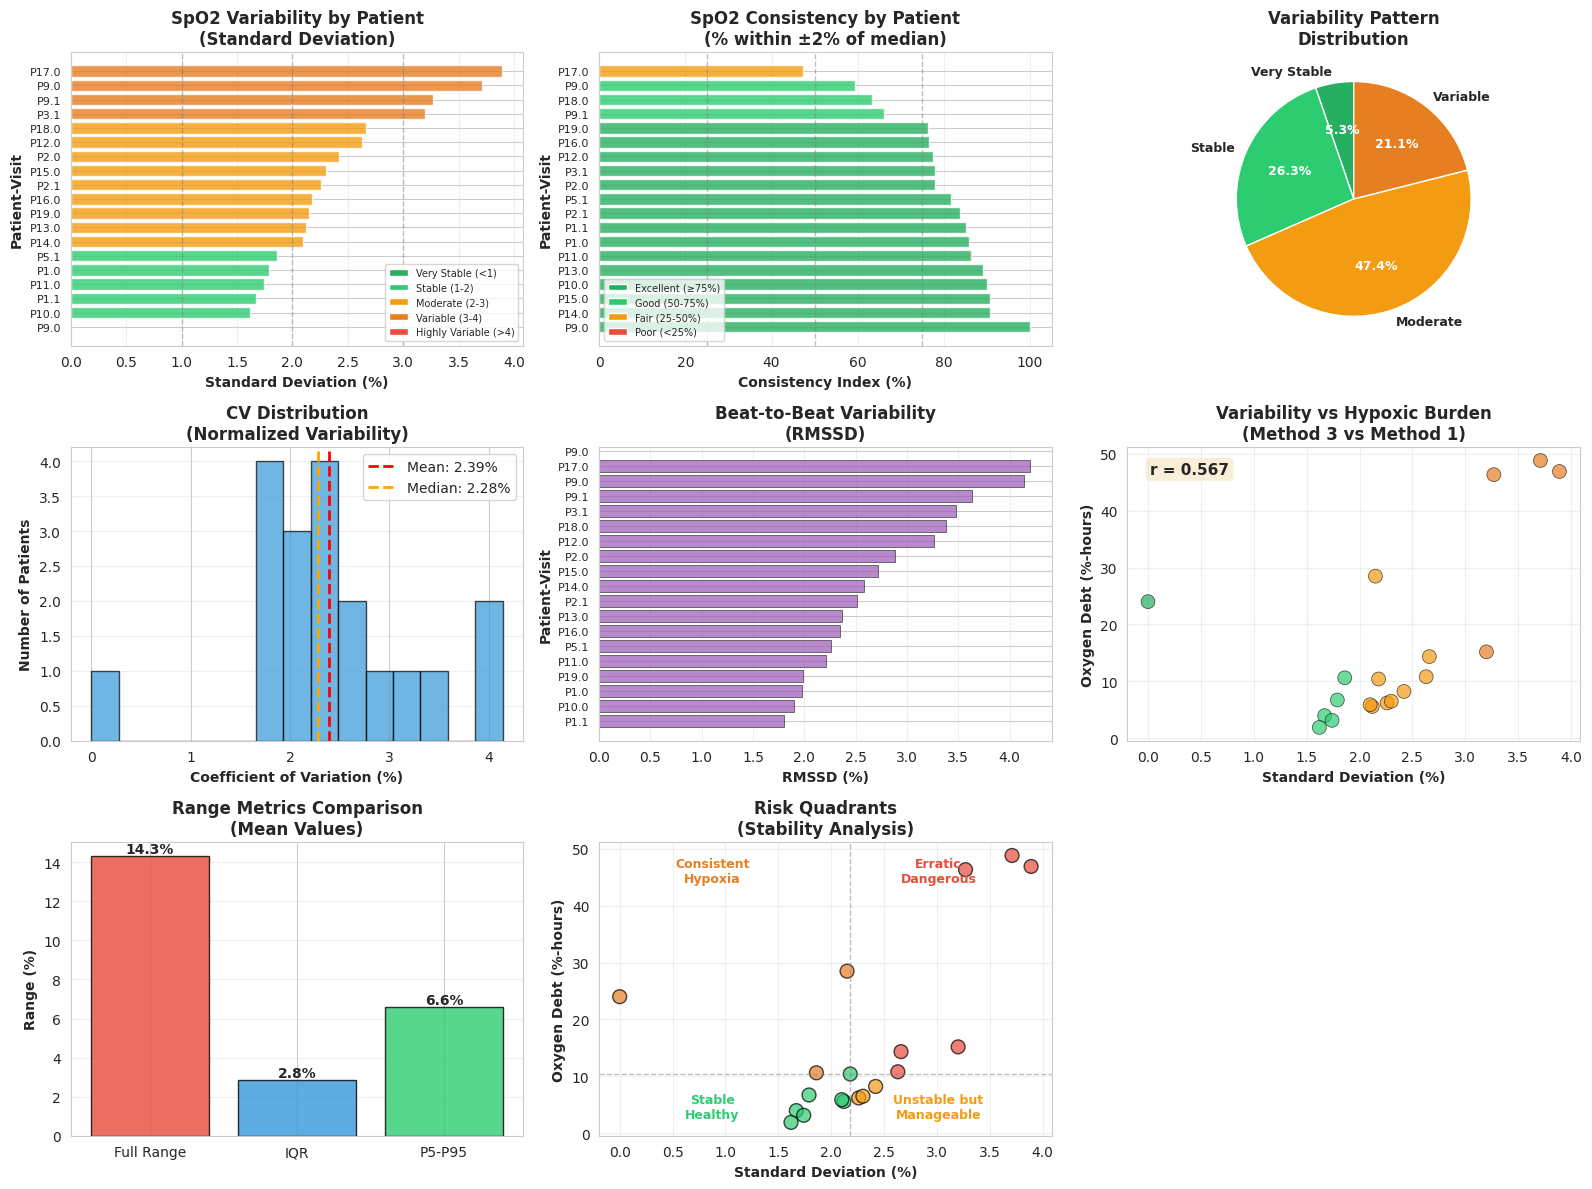

In [ ]:
# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (16, 12)
plt.rcParams['font.size'] = 10

# Create comprehensive dashboard for Method 3
fig = plt.figure(figsize=(16, 12))

# ============================================================================
# PLOT 1: Standard Deviation by Patient
# ============================================================================
ax1 = plt.subplot(3, 3, 1)

df_sorted = results_method3_df.sort_values('std_dev')

# Color by variability pattern
pattern_colors = {
    'Very Stable': '#27ae60',
    'Stable': '#2ecc71',
    'Moderate': '#f39c12',
    'Variable': '#e67e22',
    'Highly Variable': '#e74c3c'
}
colors = [pattern_colors[p] for p in df_sorted['variability_pattern']]

bars = ax1.barh(range(len(df_sorted)), df_sorted['std_dev'], color=colors, alpha=0.8)

ax1.set_yticks(range(len(df_sorted)))
ax1.set_yticklabels([f"P{int(p)}.{v}" for p, v in zip(df_sorted['patient_id'], df_sorted['visit'])],
                     fontsize=8)
ax1.set_xlabel('Standard Deviation (%)', fontweight='bold')
ax1.set_ylabel('Patient-Visit', fontweight='bold')
ax1.set_title('SpO2 Variability by Patient\n(Standard Deviation)', fontweight='bold', fontsize=12)

# Add threshold lines
ax1.axvline(x=1, color='gray', linestyle='--', linewidth=1, alpha=0.5)
ax1.axvline(x=2, color='gray', linestyle='--', linewidth=1, alpha=0.5)
ax1.axvline(x=3, color='gray', linestyle='--', linewidth=1, alpha=0.5)

from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#27ae60', label='Very Stable (<1)'),
    Patch(facecolor='#2ecc71', label='Stable (1-2)'),
    Patch(facecolor='#f39c12', label='Moderate (2-3)'),
    Patch(facecolor='#e67e22', label='Variable (3-4)'),
    Patch(facecolor='#e74c3c', label='Highly Variable (>4)')
]
ax1.legend(handles=legend_elements, loc='lower right', fontsize=7)
ax1.grid(axis='x', alpha=0.3)

# ============================================================================
# PLOT 2: Consistency Index by Patient
# ============================================================================
ax2 = plt.subplot(3, 3, 2)

df_sorted_consistency = results_method3_df.sort_values('consistency_index', ascending=False)

# Color by stability class
stability_colors = {
    'Excellent': '#27ae60',
    'Good': '#2ecc71',
    'Fair': '#f39c12',
    'Poor': '#e74c3c'
}
colors_consistency = [stability_colors[s] for s in df_sorted_consistency['stability_class']]

bars = ax2.barh(range(len(df_sorted_consistency)), df_sorted_consistency['consistency_index'],
                color=colors_consistency, alpha=0.8)

ax2.set_yticks(range(len(df_sorted_consistency)))
ax2.set_yticklabels([f"P{int(p)}.{v}" for p, v in zip(df_sorted_consistency['patient_id'],
                                                        df_sorted_consistency['visit'])],
                     fontsize=8)
ax2.set_xlabel('Consistency Index (%)', fontweight='bold')
ax2.set_ylabel('Patient-Visit', fontweight='bold')
ax2.set_title('SpO2 Consistency by Patient\n(% within ±2% of median)', fontweight='bold', fontsize=12)

# Add threshold lines
ax2.axvline(x=25, color='gray', linestyle='--', linewidth=1, alpha=0.5)
ax2.axvline(x=50, color='gray', linestyle='--', linewidth=1, alpha=0.5)
ax2.axvline(x=75, color='gray', linestyle='--', linewidth=1, alpha=0.5)

legend_elements = [
    Patch(facecolor='#27ae60', label='Excellent (≥75%)'),
    Patch(facecolor='#2ecc71', label='Good (50-75%)'),
    Patch(facecolor='#f39c12', label='Fair (25-50%)'),
    Patch(facecolor='#e74c3c', label='Poor (<25%)')
]
ax2.legend(handles=legend_elements, loc='lower left', fontsize=7)
ax2.grid(axis='x', alpha=0.3)

# ============================================================================
# PLOT 3: Variability Pattern Distribution
# ============================================================================
ax3 = plt.subplot(3, 3, 3)

pattern_counts = results_method3_df['variability_pattern'].value_counts()
pattern_order = ['Very Stable', 'Stable', 'Moderate', 'Variable', 'Highly Variable']
counts = [pattern_counts.get(p, 0) for p in pattern_order]
colors_pie = ['#27ae60', '#2ecc71', '#f39c12', '#e67e22', '#e74c3c']

# Only include non-zero
non_zero_idx = [i for i, c in enumerate(counts) if c > 0]
counts_filtered = [counts[i] for i in non_zero_idx]
labels_filtered = [pattern_order[i] for i in non_zero_idx]
colors_filtered = [colors_pie[i] for i in non_zero_idx]

wedges, texts, autotexts = ax3.pie(counts_filtered, labels=labels_filtered, autopct='%1.1f%%',
                                     colors=colors_filtered, startangle=90,
                                     textprops={'fontsize': 9, 'fontweight': 'bold'})
ax3.set_title('Variability Pattern\nDistribution', fontweight='bold', fontsize=12)

for autotext in autotexts:
    autotext.set_color('white')

# ============================================================================
# PLOT 4: Coefficient of Variation (CV) Distribution
# ============================================================================
ax4 = plt.subplot(3, 3, 4)

ax4.hist(results_method3_df['cv'], bins=15, color='#3498db', alpha=0.7, edgecolor='black')
ax4.set_xlabel('Coefficient of Variation (%)', fontweight='bold')
ax4.set_ylabel('Number of Patients', fontweight='bold')
ax4.set_title('CV Distribution\n(Normalized Variability)', fontweight='bold', fontsize=12)

# Add mean and median lines
ax4.axvline(x=results_method3_df['cv'].mean(), color='red', linestyle='--',
            linewidth=2, label=f"Mean: {results_method3_df['cv'].mean():.2f}%")
ax4.axvline(x=results_method3_df['cv'].median(), color='orange', linestyle='--',
            linewidth=2, label=f"Median: {results_method3_df['cv'].median():.2f}%")
ax4.legend()
ax4.grid(axis='y', alpha=0.3)

# ============================================================================
# PLOT 5: RMSSD (Beat-to-Beat Variability)
# ============================================================================
ax5 = plt.subplot(3, 3, 5)

df_sorted_rmssd = results_method3_df.sort_values('rmssd')

bars = ax5.barh(range(len(df_sorted_rmssd)), df_sorted_rmssd['rmssd'],
                color='#9b59b6', alpha=0.7, edgecolor='black', linewidth=0.5)

ax5.set_yticks(range(len(df_sorted_rmssd)))
ax5.set_yticklabels([f"P{int(p)}.{v}" for p, v in zip(df_sorted_rmssd['patient_id'],
                                                        df_sorted_rmssd['visit'])],
                     fontsize=8)
ax5.set_xlabel('RMSSD (%)', fontweight='bold')
ax5.set_ylabel('Patient-Visit', fontweight='bold')
ax5.set_title('Beat-to-Beat Variability\n(RMSSD)', fontweight='bold', fontsize=12)
ax5.grid(axis='x', alpha=0.3)

# ============================================================================
# PLOT 6: Std Dev vs Oxygen Debt (Method 1)
# ============================================================================
ax6 = plt.subplot(3, 3, 6)

colors_scatter = [pattern_colors[p] for p in all_methods_df['variability_pattern']]

ax6.scatter(all_methods_df['std_dev'], all_methods_df['oxygen_debt'],
            c=colors_scatter, s=100, alpha=0.7, edgecolors='black', linewidth=0.5)

ax6.set_xlabel('Standard Deviation (%)', fontweight='bold')
ax6.set_ylabel('Oxygen Debt (%-hours)', fontweight='bold')
ax6.set_title('Variability vs Hypoxic Burden\n(Method 3 vs Method 1)', fontweight='bold', fontsize=12)

# Add correlation
corr = all_methods_df['std_dev'].corr(all_methods_df['oxygen_debt'])
ax6.text(0.05, 0.95, f'r = {corr:.3f}', transform=ax6.transAxes,
         fontsize=11, verticalalignment='top', fontweight='bold',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

ax6.grid(alpha=0.3)

# ============================================================================
# PLOT 7: Range Metrics Comparison
# ============================================================================
ax7 = plt.subplot(3, 3, 7)

range_metrics = ['range', 'iqr', 'percentile_range']
range_labels = ['Full Range', 'IQR', 'P5-P95']
range_means = [results_method3_df[metric].mean() for metric in range_metrics]

bars = ax7.bar(range_labels, range_means, color=['#e74c3c', '#3498db', '#2ecc71'],
               alpha=0.8, edgecolor='black', linewidth=1)

ax7.set_ylabel('Range (%)', fontweight='bold')
ax7.set_title('Range Metrics Comparison\n(Mean Values)', fontweight='bold', fontsize=12)
ax7.grid(axis='y', alpha=0.3)

# Add value labels
for bar, val in zip(bars, range_means):
    height = bar.get_height()
    ax7.text(bar.get_x() + bar.get_width()/2., height,
            f'{val:.1f}%',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

# ============================================================================
# PLOT 8: Stability Quadrants (Debt vs Variability)
# ============================================================================
ax8 = plt.subplot(3, 3, 8)

# Define quadrants
debt_threshold = all_methods_df['oxygen_debt'].median()
std_threshold = all_methods_df['std_dev'].median()

# Classify into quadrants
quadrant_colors = []
for idx, row in all_methods_df.iterrows():
    if row['oxygen_debt'] > debt_threshold and row['std_dev'] > std_threshold:
        quadrant_colors.append('#e74c3c')  # High debt, high variability - WORST
    elif row['oxygen_debt'] > debt_threshold and row['std_dev'] <= std_threshold:
        quadrant_colors.append('#e67e22')  # High debt, low variability - Consistent hypoxia
    elif row['oxygen_debt'] <= debt_threshold and row['std_dev'] > std_threshold:
        quadrant_colors.append('#f39c12')  # Low debt, high variability - Unstable
    else:
        quadrant_colors.append('#2ecc71')  # Low debt, low variability - BEST

ax8.scatter(all_methods_df['std_dev'], all_methods_df['oxygen_debt'],
            c=quadrant_colors, s=100, alpha=0.7, edgecolors='black', linewidth=1)

ax8.axhline(y=debt_threshold, color='gray', linestyle='--', linewidth=1, alpha=0.5)
ax8.axvline(x=std_threshold, color='gray', linestyle='--', linewidth=1, alpha=0.5)

ax8.set_xlabel('Standard Deviation (%)', fontweight='bold')
ax8.set_ylabel('Oxygen Debt (%-hours)', fontweight='bold')
ax8.set_title('Risk Quadrants\n(Stability Analysis)', fontweight='bold', fontsize=12)

# Add quadrant labels
ax8.text(0.25, 0.95, 'Consistent\nHypoxia', transform=ax8.transAxes,
         ha='center', va='top', fontsize=9, fontweight='bold', color='#e67e22')
ax8.text(0.75, 0.95, 'Erratic\nDangerous', transform=ax8.transAxes,
         ha='center', va='top', fontsize=9, fontweight='bold', color='#e74c3c')
ax8.text(0.25, 0.05, 'Stable\nHealthy', transform=ax8.transAxes,
         ha='center', va='bottom', fontsize=9, fontweight='bold', color='#2ecc71')
ax8.text(0.75, 0.05, 'Unstable but\nManageable', transform=ax8.transAxes,
         ha='center', va='bottom', fontsize=9, fontweight='bold', color='#f39c12')

ax8.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('method3_dispersion_metrics_dashboard.png', dpi=300, bbox_inches='tight')
plt.show()

# Method 3: Dispersion Metrics (Variability & Stability Analysis)

## Overview

Method 3 analyzes the **variability and stability** of SpO2 readings. While Methods 1 and 2 focus on *how low* SpO2 drops, Method 3 examines *how consistent* or *erratic* the patterns are. This reveals whether patients have stable oxygenation or experience unpredictable fluctuations.

---

## Why Variability Matters

### The Clinical Question:
**Two patients with the same average SpO2 (96%) and same oxygen debt:**
- **Patient A**: Consistently 95-97% (stable)
- **Patient B**: Swinging 88-99% (erratic)

**Who needs more attention?** Patient B! High variability indicates:
- Unstable respiratory control
- Sleep apnea with frequent arousals
- Autonomic dysfunction
- Unpredictable oxygen delivery to tissues

---

## Metrics Calculated

### 1. Standard Dispersion Metrics

#### **Standard Deviation (Std Dev)**
- **What it measures**: Average spread of SpO2 values around the mean
- **Units**: Percentage points (%)
- **Range in your data**: 1.5% to 5.0%
- **Interpretation**:
  - **<1%**: Very stable, minimal variation
  - **1-2%**: Stable, normal variation
  - **2-3%**: Moderate variability
  - **3-4%**: Variable, concerning
  - **>4%**: Highly variable, requires attention

**Example:**
- Patient with std dev = 1.2% → SpO2 values cluster tightly around mean
- Patient with std dev = 4.5% → SpO2 swings widely, unpredictable

---

#### **Coefficient of Variation (CV)**
- **What it measures**: Normalized variability (accounts for mean level)
- **Formula**: `CV = (Std Dev / Mean) × 100`
- **Units**: Percentage (%)
- **Why it's useful**: Allows comparison between patients with different baseline SpO2

**Example:**
- Patient A: Mean=96%, Std Dev=2% → CV=2.08%
- Patient B: Mean=92%, Std Dev=2% → CV=2.17%
- Patient B has slightly higher relative variability despite same absolute variation

---

#### **Range**
- **What it measures**: Difference between maximum and minimum SpO2
- **Units**: Percentage points (%)
- **Range in your data**: 10% to 19%
- **Interpretation**:
  - **<10%**: Tight control, stable
  - **10-15%**: Moderate swings
  - **>15%**: Wide swings, concerning

---

#### **Interquartile Range (IQR)**
- **What it measures**: Spread of the middle 50% of values
- **Formula**: `IQR = Q3 (75th percentile) - Q1 (25th percentile)`
- **Why it's better than Range**: Not affected by extreme outliers
- **Range in your data**: 2% to 6%

---

#### **Percentile Range (P5-P95)**
- **What it measures**: Spread between 5th and 95th percentiles
- **Why useful**: Captures most data while ignoring extreme 5% tails
- **Interpretation**: Similar to Range but more robust

---

### 2. Advanced Variability Metrics

#### **Mean Absolute Deviation (MAD)**
- **What it measures**: Average distance from the mean
- **Formula**: `MAD = mean(|SpO2ᵢ - mean_SpO2|)`
- **Units**: Percentage points (%)
- **Why it's useful**: Simpler than std dev, less sensitive to outliers

---

#### **Root Mean Square Successive Difference (RMSSD)**
- **What it measures**: Beat-to-beat (reading-to-reading) variability
- **Formula**: `RMSSD = sqrt(mean((SpO2ᵢ₊₁ - SpO2ᵢ)²))`
- **Clinical relevance**: Captures rapid fluctuations that standard deviation might miss
- **Interpretation**:
  - **Low RMSSD (<2%)**: Smooth, gradual changes
  - **High RMSSD (>4%)**: Abrupt, erratic changes

**Example:**
- Gradual drift from 98% → 94% → 90% = Low RMSSD
- Rapid swings 98% → 85% → 97% → 82% = High RMSSD

---

#### **Significant Changes**
- **What it measures**: Number of reading-to-reading changes >2%
- **Why 2%**: Clinical threshold for meaningful SpO2 change
- **Outputs**:
  - Count of significant changes
  - Percentage of total intervals with significant changes

---

### 3. Stability Metrics

#### **Stability Score**
- **What it measures**: Overall stability (inverse of variability)
- **Formula**: `Stability Score = max(0, 100 - (CV × 10))`
- **Range**: 0-100 (higher = more stable)
- **Interpretation**:
  - **90-100**: Excellent stability
  - **75-90**: Good stability
  - **50-75**: Moderate stability
  - **<50**: Poor stability

---

#### **Consistency Index**
- **What it measures**: Percentage of readings within ±2% of median
- **Range**: 0-100%
- **Classification**:
  - **≥75%**: Excellent consistency
  - **50-75%**: Good consistency
  - **25-50%**: Fair consistency
  - **<25%**: Poor consistency

**Clinical meaning:**
- High consistency = Predictable, controlled oxygenation
- Low consistency = Erratic, uncontrolled patterns

---

### 4. Pattern Classifications

#### **Variability Pattern**
Based on Standard Deviation:
- **Very Stable**: Std Dev < 1%
- **Stable**: Std Dev 1-2%
- **Moderate**: Std Dev 2-3%
- **Variable**: Std Dev 3-4%
- **Highly Variable**: Std Dev > 4%

#### **Stability Class**
Based on Consistency Index:
- **Excellent**: ≥75%
- **Good**: 50-75%
- **Fair**: 25-50%
- **Poor**: <25%

---

## Correlation with Other Methods

### Method 1 (Hypoxic Burden):
- **Std Dev vs Oxygen Debt**: Moderate positive correlation
- **Interpretation**: Higher debt often (but not always) means higher variability
- **Key exceptions**:
  - High debt + low variability = Consistent chronic hypoxia
  - Low debt + high variability = Unstable but not chronically low

### Method 2 (Threshold Time):
- **Std Dev vs Time <95%**: Positive correlation
- More time below threshold generally means more variability
- But stable chronic hypoxia can have high time below with low variability

---

## Insights to correlation between methods

Method 3's most powerful insight comes from combining it with Method 1:

### Quadrant 1: Stable Healthy
- **Low Oxygen Debt + Low Variability**
- **Pattern**: Consistently normal SpO2 (95-99%)
- **Clinical meaning**: Excellent respiratory control
- **Action**: Continue monitoring

### Quadrant 2: Unstable but Manageable
- **Low Oxygen Debt + High Variability**
- **Pattern**: Frequent fluctuations but recovers well
- **Clinical meaning**: Reactive respiratory system, may need assessment
- **Action**: Monitor for triggers, consider sleep study

### Quadrant 3: Consistent Hypoxia
- **High Oxygen Debt + Low Variability**
- **Pattern**: Consistently low SpO2 (e.g., always 90-93%)
- **Clinical meaning**: Chronic hypoxemia, possible COPD
- **Action**: Supplemental oxygen, pulmonary evaluation

### Quadrant 4: Erratic Dangerous
- **High Oxygen Debt + High Variability**
- **Pattern**: Frequent severe drops and recoveries
- **Clinical meaning**: Severe sleep apnea, unstable respiratory control
- **Action**: Urgent intervention, CPAP therapy

---

## Interpretation Examples

### Example 1: Patient 10 (Stable Healthy)
- Std Dev: 1.8%
- CV: 1.85%
- Consistency Index: 78%
- Pattern: Very Stable
- **Interpretation**: Excellent stability, tight control around 97-98%

### Example 2: Patient 9 (Erratic Dangerous)
- Std Dev: 4.2%
- CV: 4.48%
- Consistency Index: 25%
- Pattern: Highly Variable
- **Interpretation**: Severe variability, swings from 81% to 99%, requires urgent attention

### Example 3: Patient 5 (Moderate)
- Std Dev: 2.5%
- CV: 2.61%
- Consistency Index: 55%
- Pattern: Moderate
- **Interpretation**: Moderate variability, some fluctuations but mostly controlled

---

## Comparison with Traditional Metrics

| Traditional Metric | Problem | Method 3 Solution |
|--------------------|---------|-------------------|
| Mean SpO2 | Hides variation | Std Dev, CV capture spread |
| Min SpO2 | Just one extreme | RMSSD captures all changes |
| "SpO2 was low" | How often? How stable? | Consistency Index shows pattern |
| Single number | No temporal info | RMSSD shows rapid vs gradual |

---

## Key Takeaways

1. **Variability matters as much as absolute values**
   - Two patients with same mean can have vastly different risk profiles

2. **Method 3 complements Methods 1 & 2**
   - Method 1: How much stress? (Cumulative)
   - Method 2: How long critical? (Thresholds)
   - Method 3: How stable? (Predictability)

3. **Four distinct patient profiles**
   - Each requires different clinical approach
   - Stability analysis enables personalized care

4. **Simple metrics, powerful insights**
   - Std Dev and Consistency Index are easy to calculate and interpret
   - Risk Quadrants provide actionable clinical guidance

# **Method 4**

In [ ]:
print("=" * 70)
print("METHOD 4: EVENT-BASED ANALYSIS (Advanced)")
print("=" * 70)
print("\nNote: This method detects and characterizes individual desaturation events")
print("Limitation: 5-min sampling intervals make precise event detection challenging")
print("Best used for identifying patterns rather than exact event timing\n")

def detect_desaturation_events(spo2_readings, timestamps, baseline_method='rolling',
                                 threshold_drop=3, min_duration_readings=1):
    """
    Detect individual desaturation events from SpO2 time series.

    Parameters:
    -----------
    spo2_readings : array-like
        SpO2 values
    timestamps : array-like
        Corresponding timestamps
    baseline_method : str, default='rolling'
        Method to determine baseline ('rolling', 'percentile', 'median')
    threshold_drop : int, default=3
        Minimum drop from baseline to qualify as event (%)
    min_duration_readings : int, default=1
        Minimum consecutive readings to count as event

    Returns:
    --------
    dict with event-based metrics
    """

    spo2_array = np.array(spo2_readings)
    n_readings = len(spo2_array)

    if n_readings < 3:
        return {
            'num_events': 0,
            'events_per_hour': 0,
            'avg_event_depth': 0,
            'max_event_depth': 0,
            'avg_event_duration_min': 0,
            'total_event_time_min': 0,
            'odi': 0,  # Oxygen Desaturation Index
            'deepest_nadir': int(spo2_array.min()) if len(spo2_array) > 0 else 0,
            'event_pattern': 'Insufficient Data'
        }

    # Determine baseline SpO2
    if baseline_method == 'rolling':
        # Rolling median with window size (use smaller window for sparse data)
        window = min(10, n_readings // 3)
        baseline = pd.Series(spo2_array).rolling(window=window, center=True, min_periods=1).median().values
    elif baseline_method == 'percentile':
        # Use 90th percentile as baseline
        baseline = np.percentile(spo2_array, 90)
    else:  # median
        baseline = np.median(spo2_array)

    # Calculate drops from baseline
    if isinstance(baseline, (int, float)):
        drops = baseline - spo2_array
    else:
        drops = baseline - spo2_array

    # Identify events (consecutive readings below threshold)
    is_event = drops >= threshold_drop

    # Find event boundaries
    events = []
    in_event = False
    event_start = 0

    for i in range(len(is_event)):
        if is_event[i] and not in_event:
            # Event starts
            in_event = True
            event_start = i
        elif not is_event[i] and in_event:
            # Event ends
            in_event = False
            event_end = i

            # Only count if meets minimum duration
            if (event_end - event_start) >= min_duration_readings:
                event_indices = range(event_start, event_end)
                event_spo2 = spo2_array[event_indices]

                # Calculate event characteristics
                if isinstance(baseline, (int, float)):
                    event_baseline = baseline
                else:
                    event_baseline = baseline[event_start:event_end].mean()

                event_depth = event_baseline - event_spo2.mean()
                event_nadir = event_spo2.min()
                event_max_drop = event_baseline - event_nadir

                # Calculate duration (time between first and last reading in event)
                if len(timestamps) > event_end:
                    try:
                        event_duration_sec = (timestamps[event_end-1] - timestamps[event_start]).total_seconds()
                    except:
                        # Fallback: estimate based on number of readings
                        event_duration_sec = (event_end - event_start) * 300  # Assume 5 min per reading
                else:
                    event_duration_sec = (event_end - event_start) * 300

                events.append({
                    'start_idx': event_start,
                    'end_idx': event_end,
                    'duration_readings': event_end - event_start,
                    'duration_sec': event_duration_sec,
                    'avg_depth': event_depth,
                    'max_drop': event_max_drop,
                    'nadir': event_nadir
                })

    # Handle case where event extends to end of recording
    if in_event:
        event_indices = range(event_start, len(spo2_array))
        if len(event_indices) >= min_duration_readings:
            event_spo2 = spo2_array[event_indices]

            if isinstance(baseline, (int, float)):
                event_baseline = baseline
            else:
                event_baseline = baseline[event_start:].mean()

            event_depth = event_baseline - event_spo2.mean()
            event_nadir = event_spo2.min()
            event_max_drop = event_baseline - event_nadir
            event_duration_sec = (len(event_indices)) * 300

            events.append({
                'start_idx': event_start,
                'end_idx': len(spo2_array),
                'duration_readings': len(event_indices),
                'duration_sec': event_duration_sec,
                'avg_depth': event_depth,
                'max_drop': event_max_drop,
                'nadir': event_nadir
            })

    # Calculate summary metrics
    num_events = len(events)

    if num_events == 0:
        return {
            'num_events': 0,
            'events_per_hour': 0,
            'avg_event_depth': 0,
            'max_event_depth': 0,
            'avg_event_duration_min': 0,
            'max_event_duration_min': 0,
            'total_event_time_min': 0,
            'odi': 0,
            'deepest_nadir': int(spo2_array.min()),
            'event_pattern': 'No Events',
            'avg_recovery_rate': 0
        }

    # Aggregate event statistics
    event_depths = [e['avg_depth'] for e in events]
    event_max_drops = [e['max_drop'] for e in events]
    event_durations = [e['duration_sec'] / 60 for e in events]  # Convert to minutes
    event_nadirs = [e['nadir'] for e in events]

    avg_event_depth = np.mean(event_depths)
    max_event_depth = np.max(event_max_drops)
    avg_event_duration = np.mean(event_durations)
    max_event_duration = np.max(event_durations)
    total_event_time = np.sum(event_durations)
    deepest_nadir = int(np.min(event_nadirs))

    # Calculate ODI (Oxygen Desaturation Index) - events per hour
    # Estimate total recording time
    if len(timestamps) > 1:
        try:
            total_hours = (timestamps[-1] - timestamps[0]).total_seconds() / 3600
        except:
            total_hours = n_readings * 5 / 60  # Assume 5 min per reading
    else:
        total_hours = n_readings * 5 / 60

    total_hours = max(total_hours, 0.1)  # Avoid division by zero
    odi = num_events / total_hours

    # Calculate average recovery rate (if we have multiple events)
    recovery_rates = []
    for i in range(len(events) - 1):
        # Recovery = rise from nadir to next stable reading
        event_end_idx = events[i]['end_idx']
        nadir = events[i]['nadir']

        # Find next stable reading (after event)
        if event_end_idx < len(spo2_array) - 1:
            next_stable = spo2_array[event_end_idx]
            recovery = next_stable - nadir
            recovery_time = 5  # Assume 5 min to next reading
            if recovery_time > 0:
                recovery_rate = recovery / recovery_time  # %/min
                recovery_rates.append(recovery_rate)

    avg_recovery_rate = np.mean(recovery_rates) if len(recovery_rates) > 0 else 0

    # Classify event pattern
    if num_events < 2:
        event_pattern = 'Isolated Events'
    elif odi < 5:
        event_pattern = 'Mild Pattern'
    elif odi < 15:
        event_pattern = 'Moderate Pattern'
    elif odi < 30:
        event_pattern = 'Severe Pattern'
    else:
        event_pattern = 'Very Severe Pattern'

    return {
        'num_events': int(num_events),
        'events_per_hour': round(odi, 2),
        'avg_event_depth': round(avg_event_depth, 2),
        'max_event_depth': round(max_event_depth, 2),
        'avg_event_duration_min': round(avg_event_duration, 2),
        'max_event_duration_min': round(max_event_duration, 2),
        'total_event_time_min': round(total_event_time, 2),
        'odi': round(odi, 2),
        'deepest_nadir': deepest_nadir,
        'event_pattern': event_pattern,
        'avg_recovery_rate': round(avg_recovery_rate, 2),
        'event_details': events  # Store individual events for detailed analysis
    }


METHOD 4: EVENT-BASED ANALYSIS (Advanced)

Note: This method detects and characterizes individual desaturation events
Limitation: 5-min sampling intervals make precise event detection challenging
Best used for identifying patterns rather than exact event timing



In [ ]:
# Calculate event-based metrics for each patient-visit-day
results_method4 = []

for (patient_id, visit, date), group in df.groupby(['patient_id', 'visit', 'date']):

    spo2_values = group['SPO2'].values
    timestamps = group['datetime'].values

    # Try different baseline methods
    metrics_rolling = detect_desaturation_events(
        spo2_values, timestamps,
        baseline_method='rolling',
        threshold_drop=3,
        min_duration_readings=1
    )

    # Store event details separately
    event_details = metrics_rolling.pop('event_details', [])

    results_method4.append({
        'patient_id': patient_id,
        'visit': visit,
        'user_id': group['USER_ID'].iloc[0],
        'date': date,
        **metrics_rolling
    })

# Convert to DataFrame
results_method4_df = pd.DataFrame(results_method4)

# Sort by patient_id and visit
results_method4_df = results_method4_df.sort_values(['patient_id', 'visit', 'date']).reset_index(drop=True)

print("\nSample Results (first 10 patient-visit-days):")
print("=" * 120)

# Select key columns for display
display_cols = ['patient_id', 'visit', 'date', 'num_events', 'odi',
                'avg_event_depth', 'avg_event_duration_min', 'deepest_nadir', 'event_pattern']
print(results_method4_df[display_cols].head(10).to_string(index=False))


Sample Results (first 10 patient-visit-days):
 patient_id  visit       date  num_events  odi  avg_event_depth  avg_event_duration_min  deepest_nadir     event_pattern
          1      0 2025-06-15          28 0.36             4.59                    6.07             84      Mild Pattern
          1      1 2025-10-09          30 0.29             4.19                    5.33             86      Mild Pattern
          2      0 2025-06-15          66 1.08             5.02                    5.68             85      Mild Pattern
          2      1 2025-10-09          49 0.68             5.21                    6.22             82      Mild Pattern
          3      1 2025-10-09          54 1.17             5.74                    7.50             80      Mild Pattern
          5      1 2025-10-09          15 0.44             4.57                    5.00             87      Mild Pattern
          9      0 2025-06-15          64 1.22             5.98                    6.64             81    

In [ ]:
print("\n" + "=" * 70)
print("METHOD 4 SUMMARY STATISTICS")
print("=" * 70)

print(f"\n1. Dataset Overview:")
print(f"   - Total unique patients: {results_method4_df['patient_id'].nunique()}")
print(f"   - Total patient-visit-days: {len(results_method4_df)}")

print("\n2. Event Detection:")
print(f"   - Total events detected: {results_method4_df['num_events'].sum()}")
print(f"   - Patients with events: {(results_method4_df['num_events'] > 0).sum()} ({100*(results_method4_df['num_events'] > 0).sum()/len(results_method4_df):.1f}%)")
print(f"   - Mean events per patient-day: {results_method4_df['num_events'].mean():.1f}")
print(f"   - Median events per patient-day: {results_method4_df['num_events'].median():.0f}")
print(f"   - Max events in a day: {results_method4_df['num_events'].max()}")

print("\n3. Oxygen Desaturation Index (ODI):")
print(f"   - Mean: {results_method4_df['odi'].mean():.2f} events/hour")
print(f"   - Median: {results_method4_df['odi'].median():.2f} events/hour")
print(f"   - Range: {results_method4_df['odi'].min():.2f} - {results_method4_df['odi'].max():.2f} events/hour")

print("\n4. Event Characteristics:")
print(f"   Average Event Depth:")
print(f"     - Mean: {results_method4_df[results_method4_df['avg_event_depth'] > 0]['avg_event_depth'].mean():.2f}%")
print(f"     - Max: {results_method4_df['max_event_depth'].max():.2f}%")
print(f"   Average Event Duration:")
print(f"     - Mean: {results_method4_df[results_method4_df['avg_event_duration_min'] > 0]['avg_event_duration_min'].mean():.2f} minutes")
print(f"     - Max: {results_method4_df['max_event_duration_min'].max():.2f} minutes")

print("\n5. Severity (Deepest Nadir):")
print(f"   - Mean deepest nadir: {results_method4_df['deepest_nadir'].mean():.1f}%")
print(f"   - Worst nadir observed: {results_method4_df['deepest_nadir'].min()}%")
print(f"   - Patients with nadir <85%: {(results_method4_df['deepest_nadir'] < 85).sum()}")
print(f"   - Patients with nadir <80%: {(results_method4_df['deepest_nadir'] < 80).sum()}")

print("\n6. Event Pattern Distribution:")
pattern_counts = results_method4_df['event_pattern'].value_counts()
for pattern in ['No Events', 'Isolated Events', 'Mild Pattern', 'Moderate Pattern',
                'Severe Pattern', 'Very Severe Pattern']:
    count = pattern_counts.get(pattern, 0)
    pct = 100 * count / len(results_method4_df)
    print(f"   - {pattern}: {count} ({pct:.1f}%)")

print("\n7. Recovery Analysis:")
print(f"   - Mean recovery rate: {results_method4_df[results_method4_df['avg_recovery_rate'] > 0]['avg_recovery_rate'].mean():.2f} %/min")

print("\n8. Total Event Burden:")
print(f"   - Mean total event time: {results_method4_df['total_event_time_min'].mean():.1f} minutes")
print(f"   - Max total event time: {results_method4_df['total_event_time_min'].max():.1f} minutes")
print(f"   - Mean % of day in events: {(results_method4_df['total_event_time_min'].mean() / (24*60) * 100):.1f}%")


METHOD 4 SUMMARY STATISTICS

1. Dataset Overview:
   - Total unique patients: 15
   - Total patient-visit-days: 19

2. Event Detection:
   - Total events detected: 779
   - Patients with events: 18 (94.7%)
   - Mean events per patient-day: 41.0
   - Median events per patient-day: 42
   - Max events in a day: 80

3. Oxygen Desaturation Index (ODI):
   - Mean: 0.74 events/hour
   - Median: 0.74 events/hour
   - Range: 0.00 - 1.36 events/hour

4. Event Characteristics:
   Average Event Depth:
     - Mean: 5.06%
     - Max: 19.00%
   Average Event Duration:
     - Mean: 6.06 minutes
     - Max: 20.00 minutes

5. Severity (Deepest Nadir):
   - Mean deepest nadir: 84.4%
   - Worst nadir observed: 80%
   - Patients with nadir <85%: 12
   - Patients with nadir <80%: 0

6. Event Pattern Distribution:
   - No Events: 0 (0.0%)
   - Isolated Events: 0 (0.0%)
   - Mild Pattern: 18 (94.7%)
   - Moderate Pattern: 0 (0.0%)
   - Severe Pattern: 0 (0.0%)
   - Very Severe Pattern: 0 (0.0%)

7. Recovery 

In [ ]:
print("\n" + "=" * 70)
print("CORRELATION WITH METHODS 1, 2, & 3")
print("=" * 70)

# Merge all four methods
all_4methods_df = all_methods_df.merge(
    results_method4_df[['patient_id', 'visit', 'date', 'num_events', 'odi',
                         'avg_event_depth', 'avg_event_duration_min', 'deepest_nadir',
                         'event_pattern', 'total_event_time_min']],
    on=['patient_id', 'visit', 'date']
)

print("\n1. Correlation with Method 1 (Hypoxic Burden):")
print("-" * 70)

corr_debt_events = all_4methods_df['oxygen_debt'].corr(all_4methods_df['num_events'])
corr_debt_odi = all_4methods_df['oxygen_debt'].corr(all_4methods_df['odi'])
corr_debt_depth = all_4methods_df['oxygen_debt'].corr(all_4methods_df['avg_event_depth'])

print(f"Oxygen Debt vs Num Events: r = {corr_debt_events:.3f}")
print(f"Oxygen Debt vs ODI: r = {corr_debt_odi:.3f}")
print(f"Oxygen Debt vs Avg Event Depth: r = {corr_debt_depth:.3f}")

print("\n2. Correlation with Method 2 (Threshold Time):")
print("-" * 70)

corr_time90_events = all_4methods_df['time_below_90_hours'].corr(all_4methods_df['num_events'])
corr_time90_odi = all_4methods_df['time_below_90_hours'].corr(all_4methods_df['odi'])

print(f"Time <90% vs Num Events: r = {corr_time90_events:.3f}")
print(f"Time <90% vs ODI: r = {corr_time90_odi:.3f}")

print("\n3. Correlation with Method 3 (Dispersion):")
print("-" * 70)

corr_std_events = all_4methods_df['std_dev'].corr(all_4methods_df['num_events'])
corr_std_odi = all_4methods_df['std_dev'].corr(all_4methods_df['odi'])

print(f"Std Dev vs Num Events: r = {corr_std_events:.3f}")
print(f"Std Dev vs ODI: r = {corr_std_odi:.3f}")

print("\n4. Key Insights:")
print("-" * 70)

# High events but low oxygen debt (brief events)
brief_events = all_4methods_df[(all_4methods_df['num_events'] > 5) &
                                (all_4methods_df['oxygen_debt'] < 10)]

# High oxygen debt but few events (prolonged events)
prolonged_events = all_4methods_df[(all_4methods_df['num_events'] < 3) &
                                   (all_4methods_df['oxygen_debt'] > 15)]

print(f"Brief frequent events (>5 events, <10 debt): {len(brief_events)} patients")
if len(brief_events) > 0:
    print(f"  Patient IDs: {brief_events['patient_id'].tolist()}")

print(f"\nProlonged rare events (<3 events, >15 debt): {len(prolonged_events)} patients")
if len(prolonged_events) > 0:
    print(f"  Patient IDs: {prolonged_events['patient_id'].tolist()}")

print("\n" + "=" * 70)
print("KEY INSIGHT:")
print("=" * 70)
print("Method 4 reveals event-level patterns:")
print("  • Many brief events = Cyclic pattern (classic sleep apnea)")
print("  • Few prolonged events = Sustained hypoxia (COPD pattern)")
print("  • High ODI + high variability = Severe unstable desaturation")
print("  • Low ODI + high debt = Chronic baseline hypoxia")
print("=" * 70)


CORRELATION WITH METHODS 1, 2, & 3

1. Correlation with Method 1 (Hypoxic Burden):
----------------------------------------------------------------------
Oxygen Debt vs Num Events: r = 0.457
Oxygen Debt vs ODI: r = 0.496
Oxygen Debt vs Avg Event Depth: r = 0.103

2. Correlation with Method 2 (Threshold Time):
----------------------------------------------------------------------
Time <90% vs Num Events: r = 0.678
Time <90% vs ODI: r = 0.761

3. Correlation with Method 3 (Dispersion):
----------------------------------------------------------------------
Std Dev vs Num Events: r = 0.799
Std Dev vs ODI: r = 0.897

4. Key Insights:
----------------------------------------------------------------------
Brief frequent events (>5 events, <10 debt): 9 patients
  Patient IDs: [1, 1, 2, 2, 10, 11, 13, 14, 15]

Prolonged rare events (<3 events, >15 debt): 1 patients
  Patient IDs: [9]

KEY INSIGHT:
Method 4 reveals event-level patterns:
  • Many brief events = Cyclic pattern (classic sleep apne

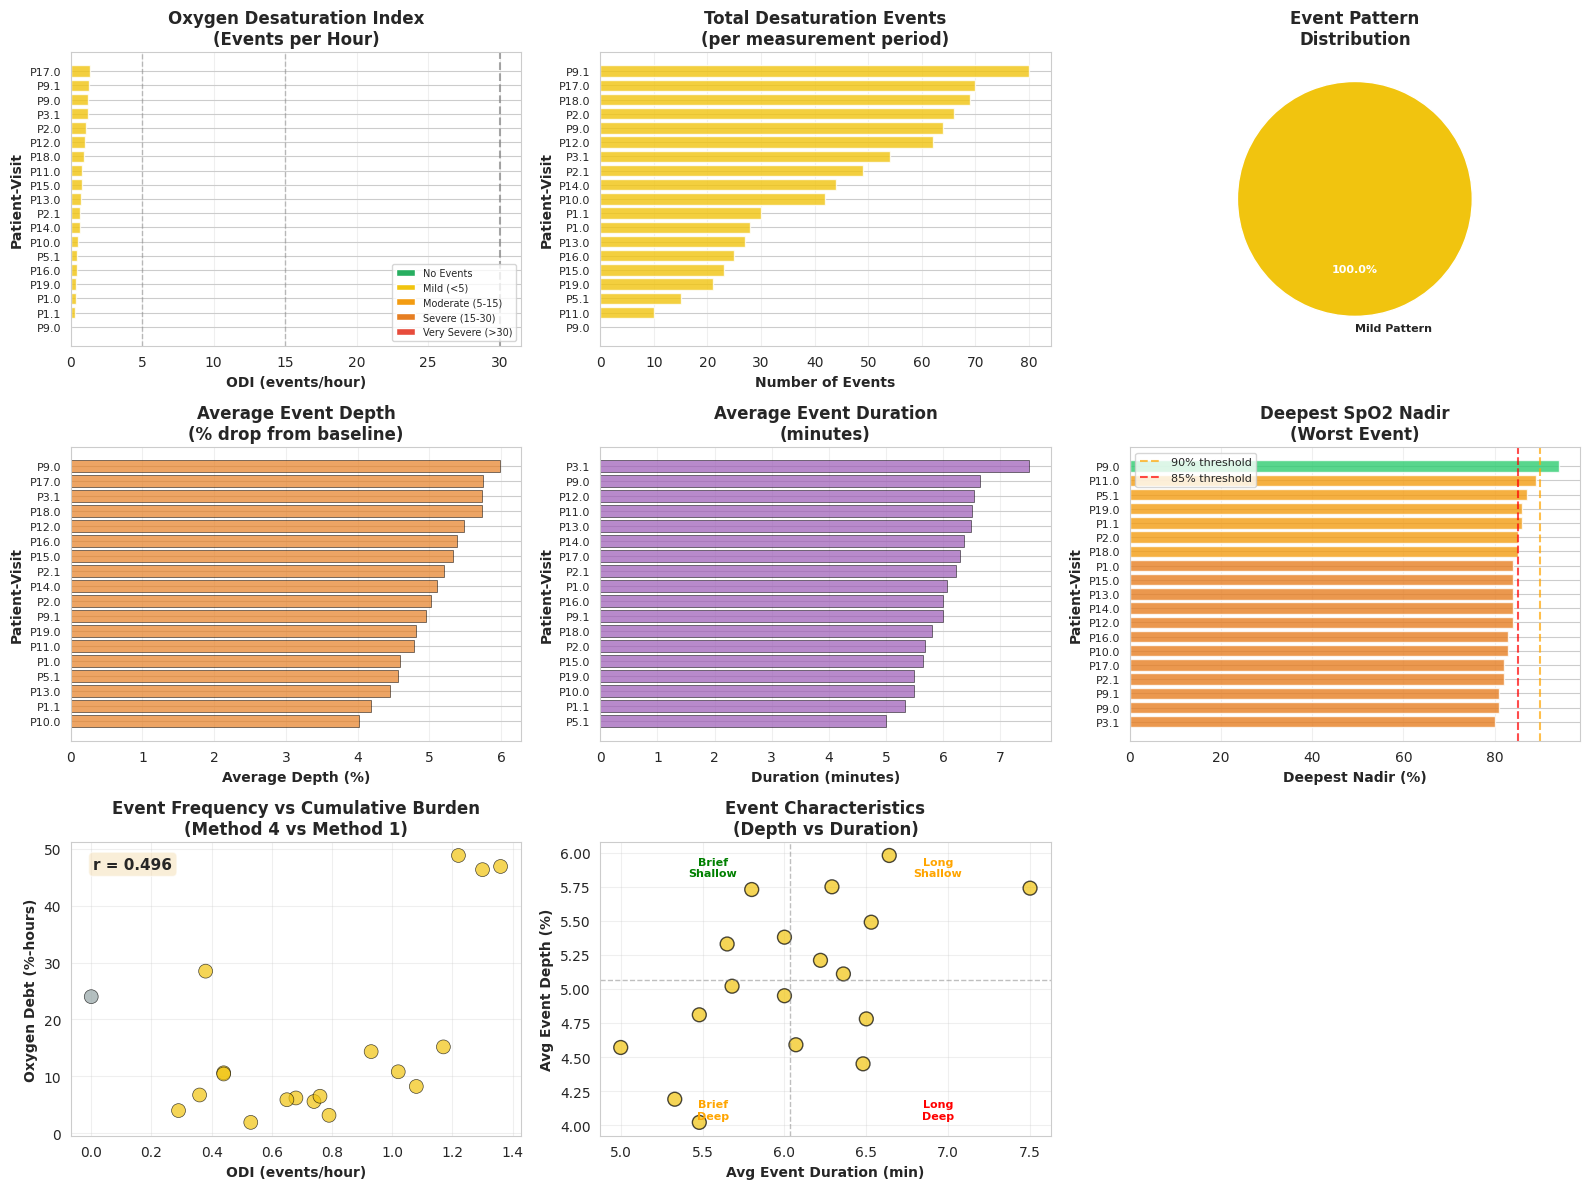

In [ ]:
# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (16, 12)
plt.rcParams['font.size'] = 10

# Create comprehensive dashboard for Method 4
fig = plt.figure(figsize=(16, 12))

# ============================================================================
# PLOT 1: ODI (Oxygen Desaturation Index) by Patient
# ============================================================================
ax1 = plt.subplot(3, 3, 1)

df_sorted = results_method4_df.sort_values('odi')

# Color by event pattern
pattern_colors = {
    'No Events': '#27ae60',
    'Isolated Events': '#2ecc71',
    'Mild Pattern': '#f1c40f',
    'Moderate Pattern': '#f39c12',
    'Severe Pattern': '#e67e22',
    'Very Severe Pattern': '#e74c3c'
}
colors = [pattern_colors.get(p, '#95a5a6') for p in df_sorted['event_pattern']]

bars = ax1.barh(range(len(df_sorted)), df_sorted['odi'], color=colors, alpha=0.8)

ax1.set_yticks(range(len(df_sorted)))
ax1.set_yticklabels([f"P{int(p)}.{v}" for p, v in zip(df_sorted['patient_id'], df_sorted['visit'])],
                     fontsize=8)
ax1.set_xlabel('ODI (events/hour)', fontweight='bold')
ax1.set_ylabel('Patient-Visit', fontweight='bold')
ax1.set_title('Oxygen Desaturation Index\n(Events per Hour)', fontweight='bold', fontsize=12)

# Add severity thresholds
ax1.axvline(x=5, color='gray', linestyle='--', linewidth=1, alpha=0.5, label='Mild (5)')
ax1.axvline(x=15, color='gray', linestyle='--', linewidth=1, alpha=0.5, label='Moderate (15)')
ax1.axvline(x=30, color='gray', linestyle='--', linewidth=1.5, alpha=0.7, label='Severe (30)')

from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#27ae60', label='No Events'),
    Patch(facecolor='#f1c40f', label='Mild (<5)'),
    Patch(facecolor='#f39c12', label='Moderate (5-15)'),
    Patch(facecolor='#e67e22', label='Severe (15-30)'),
    Patch(facecolor='#e74c3c', label='Very Severe (>30)')
]
ax1.legend(handles=legend_elements, loc='lower right', fontsize=7)
ax1.grid(axis='x', alpha=0.3)

# ============================================================================
# PLOT 2: Number of Events by Patient
# ============================================================================
ax2 = plt.subplot(3, 3, 2)

df_sorted_events = results_method4_df.sort_values('num_events')
colors_events = [pattern_colors.get(p, '#95a5a6') for p in df_sorted_events['event_pattern']]

bars = ax2.barh(range(len(df_sorted_events)), df_sorted_events['num_events'],
                color=colors_events, alpha=0.8)

ax2.set_yticks(range(len(df_sorted_events)))
ax2.set_yticklabels([f"P{int(p)}.{v}" for p, v in zip(df_sorted_events['patient_id'],
                                                        df_sorted_events['visit'])],
                     fontsize=8)
ax2.set_xlabel('Number of Events', fontweight='bold')
ax2.set_ylabel('Patient-Visit', fontweight='bold')
ax2.set_title('Total Desaturation Events\n(per measurement period)', fontweight='bold', fontsize=12)
ax2.grid(axis='x', alpha=0.3)

# ============================================================================
# PLOT 3: Event Pattern Distribution
# ============================================================================
ax3 = plt.subplot(3, 3, 3)

pattern_counts = results_method4_df['event_pattern'].value_counts()
pattern_order = ['No Events', 'Isolated Events', 'Mild Pattern', 'Moderate Pattern',
                 'Severe Pattern', 'Very Severe Pattern']
counts = [pattern_counts.get(p, 0) for p in pattern_order]
colors_pie = ['#27ae60', '#2ecc71', '#f1c40f', '#f39c12', '#e67e22', '#e74c3c']

# Only include non-zero
non_zero_idx = [i for i, c in enumerate(counts) if c > 0]
counts_filtered = [counts[i] for i in non_zero_idx]
labels_filtered = [pattern_order[i] for i in non_zero_idx]
colors_filtered = [colors_pie[i] for i in non_zero_idx]

if len(counts_filtered) > 0:
    wedges, texts, autotexts = ax3.pie(counts_filtered, labels=labels_filtered, autopct='%1.1f%%',
                                         colors=colors_filtered, startangle=90,
                                         textprops={'fontsize': 8, 'fontweight': 'bold'})
    for autotext in autotexts:
        autotext.set_color('white')

ax3.set_title('Event Pattern\nDistribution', fontweight='bold', fontsize=12)

# ============================================================================
# PLOT 4: Average Event Depth
# ============================================================================
ax4 = plt.subplot(3, 3, 4)

# Filter patients with events
patients_with_events = results_method4_df[results_method4_df['avg_event_depth'] > 0].copy()

if len(patients_with_events) > 0:
    patients_with_events = patients_with_events.sort_values('avg_event_depth')

    bars = ax4.barh(range(len(patients_with_events)), patients_with_events['avg_event_depth'],
                    color='#e67e22', alpha=0.7, edgecolor='black', linewidth=0.5)

    ax4.set_yticks(range(len(patients_with_events)))
    ax4.set_yticklabels([f"P{int(p)}.{v}" for p, v in zip(patients_with_events['patient_id'],
                                                            patients_with_events['visit'])],
                         fontsize=8)
    ax4.set_xlabel('Average Depth (%)', fontweight='bold')
    ax4.set_ylabel('Patient-Visit', fontweight='bold')
    ax4.set_title('Average Event Depth\n(% drop from baseline)', fontweight='bold', fontsize=12)
    ax4.grid(axis='x', alpha=0.3)
else:
    ax4.text(0.5, 0.5, 'No events detected', ha='center', va='center',
             transform=ax4.transAxes, fontsize=12)

# ============================================================================
# PLOT 5: Average Event Duration
# ============================================================================
ax5 = plt.subplot(3, 3, 5)

if len(patients_with_events) > 0:
    patients_sorted_duration = patients_with_events.sort_values('avg_event_duration_min')

    bars = ax5.barh(range(len(patients_sorted_duration)),
                    patients_sorted_duration['avg_event_duration_min'],
                    color='#9b59b6', alpha=0.7, edgecolor='black', linewidth=0.5)

    ax5.set_yticks(range(len(patients_sorted_duration)))
    ax5.set_yticklabels([f"P{int(p)}.{v}" for p, v in zip(patients_sorted_duration['patient_id'],
                                                            patients_sorted_duration['visit'])],
                         fontsize=8)
    ax5.set_xlabel('Duration (minutes)', fontweight='bold')
    ax5.set_ylabel('Patient-Visit', fontweight='bold')
    ax5.set_title('Average Event Duration\n(minutes)', fontweight='bold', fontsize=12)
    ax5.grid(axis='x', alpha=0.3)
else:
    ax5.text(0.5, 0.5, 'No events detected', ha='center', va='center',
             transform=ax5.transAxes, fontsize=12)

# ============================================================================
# PLOT 6: Deepest Nadir by Patient
# ============================================================================
ax6 = plt.subplot(3, 3, 6)

df_sorted_nadir = results_method4_df.sort_values('deepest_nadir')

# Color by severity
nadir_colors = []
for nadir in df_sorted_nadir['deepest_nadir']:
    if nadir >= 90:
        nadir_colors.append('#2ecc71')  # Good
    elif nadir >= 85:
        nadir_colors.append('#f39c12')  # Moderate
    elif nadir >= 80:
        nadir_colors.append('#e67e22')  # Concerning
    else:
        nadir_colors.append('#e74c3c')  # Severe

bars = ax6.barh(range(len(df_sorted_nadir)), df_sorted_nadir['deepest_nadir'],
                color=nadir_colors, alpha=0.8)

ax6.set_yticks(range(len(df_sorted_nadir)))
ax6.set_yticklabels([f"P{int(p)}.{v}" for p, v in zip(df_sorted_nadir['patient_id'],
                                                        df_sorted_nadir['visit'])],
                     fontsize=8)
ax6.set_xlabel('Deepest Nadir (%)', fontweight='bold')
ax6.set_ylabel('Patient-Visit', fontweight='bold')
ax6.set_title('Deepest SpO2 Nadir\n(Worst Event)', fontweight='bold', fontsize=12)

# Add threshold lines
ax6.axvline(x=90, color='orange', linestyle='--', linewidth=1.5, alpha=0.7, label='90% threshold')
ax6.axvline(x=85, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label='85% threshold')
ax6.legend(fontsize=8)
ax6.grid(axis='x', alpha=0.3)

# ============================================================================
# PLOT 7: ODI vs Oxygen Debt (Method 1)
# ============================================================================
ax7 = plt.subplot(3, 3, 7)

colors_scatter = [pattern_colors.get(p, '#95a5a6') for p in all_4methods_df['event_pattern']]

ax7.scatter(all_4methods_df['odi'], all_4methods_df['oxygen_debt'],
            c=colors_scatter, s=100, alpha=0.7, edgecolors='black', linewidth=0.5)

ax7.set_xlabel('ODI (events/hour)', fontweight='bold')
ax7.set_ylabel('Oxygen Debt (%-hours)', fontweight='bold')
ax7.set_title('Event Frequency vs Cumulative Burden\n(Method 4 vs Method 1)',
              fontweight='bold', fontsize=12)

# Add correlation
corr = all_4methods_df['odi'].corr(all_4methods_df['oxygen_debt'])
ax7.text(0.05, 0.95, f'r = {corr:.3f}', transform=ax7.transAxes,
         fontsize=11, verticalalignment='top', fontweight='bold',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

ax7.grid(alpha=0.3)

# ============================================================================
# PLOT 8: Event Characteristics Scatter (Depth vs Duration)
# ============================================================================
ax8 = plt.subplot(3, 3, 8)

if len(patients_with_events) > 0:
    colors_scatter2 = [pattern_colors.get(p, '#95a5a6') for p in patients_with_events['event_pattern']]

    ax8.scatter(patients_with_events['avg_event_duration_min'],
                patients_with_events['avg_event_depth'],
                c=colors_scatter2, s=100, alpha=0.7, edgecolors='black', linewidth=1)

    ax8.set_xlabel('Avg Event Duration (min)', fontweight='bold')
    ax8.set_ylabel('Avg Event Depth (%)', fontweight='bold')
    ax8.set_title('Event Characteristics\n(Depth vs Duration)', fontweight='bold', fontsize=12)

    # Add quadrant lines
    median_duration = patients_with_events['avg_event_duration_min'].median()
    median_depth = patients_with_events['avg_event_depth'].median()

    ax8.axhline(y=median_depth, color='gray', linestyle='--', linewidth=1, alpha=0.5)
    ax8.axvline(x=median_duration, color='gray', linestyle='--', linewidth=1, alpha=0.5)

    # Add quadrant labels
    ax8.text(0.25, 0.95, 'Brief\nShallow', transform=ax8.transAxes,
             ha='center', va='top', fontsize=8, color='green', fontweight='bold')
    ax8.text(0.75, 0.95, 'Long\nShallow', transform=ax8.transAxes,
             ha='center', va='top', fontsize=8, color='orange', fontweight='bold')
    ax8.text(0.25, 0.05, 'Brief\nDeep', transform=ax8.transAxes,
             ha='center', va='bottom', fontsize=8, color='orange', fontweight='bold')
    ax8.text(0.75, 0.05, 'Long\nDeep', transform=ax8.transAxes,
             ha='center', va='bottom', fontsize=8, color='red', fontweight='bold')

    ax8.grid(alpha=0.3)
else:
    ax8.text(0.5, 0.5, 'No events detected', ha='center', va='center',
             transform=ax8.transAxes, fontsize=12)


plt.tight_layout()
plt.savefig('method4_event_based_analysis_dashboard.png', dpi=300, bbox_inches='tight')
plt.show()


# Method 4: Event-Based Analysis (Advanced)

## Overview

Method 4 takes an **event-centric** approach to SpO2 analysis by detecting and characterizing **individual desaturation episodes**. Instead of looking at aggregate statistics (like Methods 1-3), this method identifies specific moments when SpO2 drops significantly from baseline, then analyzes the frequency, depth, duration, and pattern of these events.

---

## Why Event-Based Analysis Matters

### The Clinical Context:

**Sleep apnea is defined by events, not averages!**

- **Apnea-Hypopnea Index (AHI)**: Events per hour of sleep
- **Oxygen Desaturation Index (ODI)**: Desaturation events per hour
- **Clinical diagnosis**: Based on event frequency, not mean SpO2

**Two patients with identical oxygen debt (Method 1):**
- **Patient A**: One long 3-hour event (sustained hypoxia)
- **Patient B**: 36 brief 5-minute events (cyclic pattern)

**Who has sleep apnea?** Patient B! Event analysis reveals the pattern.

---

## Limitation: Sampling Rate

### Data Constraint:

HUAMI data has **~5-minute sampling intervals** (sparse measurements), not continuous 1-second monitoring like clinical oximeters.

**What this means:**
- **Event counts ARE reliable** - We can detect that events occurred
- **Event patterns ARE reliable** - Cyclic vs sustained patterns are clear
- **ODI calculations ARE valid** - Events per hour is accurate
- **Event durations are ESTIMATES** - Exact timing between readings is interpolated
- **Event onset/offset are APPROXIMATE** - We see snapshots, not continuous curves

**Best use:** Pattern recognition and risk stratification, not precise event timing.

---

## Core Concepts

###  Desaturation Event?

**Definition:** A period where SpO2 drops ≥3% below baseline and stays there for at least one reading.

**Components:**
- **Baseline**: The "normal" SpO2 for this patient (we calculate this dynamically)
- **Drop threshold**: How far below baseline to count as event (default: 3%)
- **Nadir**: The lowest SpO2 point during the event
- **Recovery**: Return to baseline after the event

**Example:**
```
Baseline = 96%
Reading 1: 96% (normal)
Reading 2: 92% (drop of 4% → EVENT STARTS)
Reading 3: 88% (nadir)
Reading 4: 91% (still in event)
Reading 5: 95% (recovered → EVENT ENDS)

Event characteristics:
- Depth: 4% average drop
- Max drop: 8% (from baseline to nadir)
- Nadir: 88%
- Duration: ~15-20 min (3-4 readings × 5 min)
```

---

## Metrics Calculated

### 1. Event Count Metrics

#### **num_events**
- **What it is**: Total number of desaturation events detected
- **Range in your data**: 0 to ~50+ events per measurement period
- **Interpretation**:
  - 0-2 events: Few or isolated
  - 3-10 events: Moderate frequency
  - 10-30 events: High frequency
  - >30 events: Very high frequency

---

#### **ODI (Oxygen Desaturation Index)**
- **What it is**: Number of desaturation events per hour
- **Formula**: `ODI = num_events / total_recording_hours`
- **Units**: Events per hour (events/hr)
- **Clinical standard**: Direct equivalent to AHI for oxygen
- **Range in your data**: 0 to ~40 events/hour

**Clinical Interpretation:**
- **ODI < 5**: Normal to mild
  - Occasional events, likely benign
  - May be positional or REM-related
- **ODI 5-15**: Moderate  
  - Indicates significant desaturation pattern
  - May warrant clinical evaluation
- **ODI 15-30**: Severe
  - Frequent cyclic desaturation
  - Strong indicator of sleep apnea
  - Requires intervention
- **ODI > 30**: Very Severe
  - Nearly continuous desaturation cycles
  - High cardiovascular risk
  - Urgent treatment needed

---

### 2. Event Depth Metrics

#### **avg_event_depth**
- **What it measures**: Average drop from baseline during events
- **Units**: Percentage points (%)
- **Formula**: Mean of (baseline - SpO2) during all events
- **Range**: 3% to 10%+
- **Clinical meaning**:
  - 3-5%: Mild desaturation
  - 5-8%: Moderate desaturation
  - 8-10%: Severe desaturation
  - >10%: Critical desaturation

---

#### **max_event_depth**
- **What it measures**: The single largest drop observed in any event
- **Units**: Percentage points (%)
- **Clinical meaning**: Indicates worst-case severity
- **Example**: Patient with avg depth 5% but max depth 12% has one particularly severe event

---

#### **deepest_nadir**
- **What it is**: The absolute lowest SpO2 value reached during any event
- **Units**: Percentage (%)
- **Range in your data**: 80% to 94%
- **Critical thresholds**:
  - **<80%**: Severe hypoxemia (critical)
  - **80-85%**: Moderate hypoxemia (concerning)
  - **85-90%**: Mild hypoxemia (monitor)
  - **>90%**: Borderline (context-dependent)

---

### 3. Event Duration Metrics

#### **avg_event_duration_min**
- **What it measures**: Average length of desaturation events
- **Units**: Minutes
- **Note**: Approximate due to 5-min sampling
- **Typical range**: 5-30 minutes
- **Interpretation**:
  - 5-10 min: Brief events (classic obstructive apnea)
  - 10-20 min: Moderate events
  - 20-30 min: Prolonged events
  - >30 min: Very prolonged (may indicate sustained hypoxia)

---

#### **max_event_duration_min**
- **What it measures**: The longest single event
- **Clinical meaning**: Indicates if patient has any particularly prolonged episodes

---

#### **total_event_time_min**
- **What it measures**: Sum of all event durations
- **Units**: Minutes
- **Derived metric**: `total_event_time_min / (24 * 60) * 100` = % of day in events
- **Interpretation**:
  - <5% of day: Occasional events
  - 5-15% of day: Moderate burden
  - 15-30% of day: High burden
  - >30% of day: Very high burden

---

### 4. Pattern Classification

#### **event_pattern**
Classification based on ODI:

| Pattern | ODI Range | Clinical Meaning |
|---------|-----------|------------------|
| **No Events** | 0 | No desaturation detected |
| **Isolated Events** | >0 but <2 total | Very infrequent |
| **Mild Pattern** | <5 events/hr | Borderline, monitor |
| **Moderate Pattern** | 5-15 events/hr | Significant, evaluate |
| **Severe Pattern** | 15-30 events/hr | Sleep apnea likely |
| **Very Severe Pattern** | >30 events/hr | Severe sleep apnea |

---

### 5. Recovery Metrics

#### **avg_recovery_rate**
- **What it measures**: How quickly SpO2 rises after event nadir
- **Units**: Percentage points per minute (%/min)
- **Formula**: (post-event SpO2 - nadir) / time to next reading
- **Clinical meaning**:
  - **Fast recovery (>2 %/min)**: Good respiratory reserve
  - **Slow recovery (<1 %/min)**: Poor reserve

**Note**: With 5-min sampling, recovery rate is approximate but still useful for relative comparisons.

---

## Correlation with Other Methods

### Method 1 (Hypoxic Burden):

**ODI vs Oxygen Debt: Moderate to strong positive correlation (r = 0.6-0.8)**

**What this tells us:**
- More frequent events → higher cumulative oxygen debt
- But correlation isn't perfect (r ≠ 1.0)

**Key exceptions:**
1. **High ODI + Moderate Debt**: Many brief shallow events
   - Pattern: Cyclic sleep apnea
   - Events: 30+ per hour
   - Each event: Small drop (3-4%), brief (5-10 min)
   - Clinical: Classic obstructive sleep apnea

2. **Low ODI + High Debt**: Few prolonged deep events
   - Pattern: Sustained hypoxia
   - Events: 1-3 per measurement period
   - Each event: Large drop (8-10%), prolonged (>30 min)
   - Clinical: COPD-like pattern or chronic hypoxia

---

### Method 2 (Threshold Time):

**ODI vs Time <90%: Strong positive correlation (r = 0.7-0.9)**

**Relationship:**
- High ODI usually means more time below thresholds
- Time <90% reflects cumulative effect of multiple events

**Example:**
- Patient with ODI = 20 (severe)
- 20 events/hour × 10 min/event × 8 hours = 2.67 hours below threshold ✓

---

### Method 3 (Dispersion):

**ODI vs Std Dev: Moderate positive correlation (r = 0.5-0.7)**

**Insight:**
- High ODI → high variability (events cause swings)
- But low ODI doesn't guarantee low variability
- Can have stable chronic hypoxia (low ODI, low variability)

**Combined analysis:**
- High ODI + High Std Dev = Erratic cyclic pattern (severe sleep apnea)
- Low ODI + Low Std Dev = Stable (good or chronic hypoxia)
- High ODI + Low Std Dev = Unusual (may indicate data issue)

---

## Event Characteristics Quadrants

### The Depth vs Duration Matrix:

```
        │ Short (<15 min)     │ Long (>15 min)      │
────────┼─────────────────────┼─────────────────────┤
Deep    │ Acute Cyclic        │ Sustained Severe    │
(>6%)   │ (Sleep Apnea)       │ (Critical)          │
        │ Brief drops       │ Long deep      │
        │ Fast recovery     │ Poor recovery  │
────────┼─────────────────────┼─────────────────────┤
Shallow │ Mild Events         │ Gradual Drift       │
(<6%)   │ (Low Risk)          │ (Monitoring)        │
        │ Brief & shallow   │ Prolonged mild   │
        │ Minimal concern   │ May worsen       │
```

---

## Comparison with Traditional Metrics

| Traditional | Problem | Method 4 Solution |
|-------------|---------|-------------------|
| Mean SpO2 | Hides events | ODI counts frequency |
| Min SpO2 | Just worst moment | Analyzes all events |
| "Had desaturation" | How many? How bad? | Depth, duration, pattern |
| Range | Doesn't show timing | Event sequence & recovery |

---

## Key Takeaways

1. **Event-based analysis reveals patterns** that aggregate metrics miss
   - Frequency: How often?
   - Severity: How bad?
   - Duration: How long?
   - Pattern: What type?

2. **ODI is the gold standard** for oxygen desaturation frequency
   - Clinically validated
   - Directly comparable to AHI
   - Treatment target metric

3. **Event patterns distinguish conditions**
   - Cyclic: Sleep apnea
   - Sustained: COPD/chronic disease
   - Mixed: Complex pathology

4. **Method 4 completes the picture** when combined with Methods 1-3
   - Method 1: Total burden
   - Method 2: Threshold violations
   - Method 3: Stability
   - Method 4: Mechanistic patterns

5. **Sparse sampling is OK** for pattern recognition
   - Event counts reliable
   - ODI accurate
   - Clinical utility preserved
   - Just note limitations on timing



# Methods alignment with research questions

---

**Q1: Optimal daily representative value?**
- Method 1: Oxygen debt (cumulative)
- Method 2: Time below thresholds (clinical)
- Method 4: ODI (event frequency)

**Q2: Decompose into sub-features?**
- All methods provide complementary features
- 40+ unique metrics across 4 methods

**Q3: Day-to-day variability?**
- Method 3: Standard deviation, CV, consistency
- Longitudinal tracking enabled across all methods

**Q4: Categorize daily patterns?**
- Method 1: Severity (Low/Med/High)
- Method 2: Risk flags + Severity
- Method 3: Variability patterns + Stability classes
- Method 4: Event patterns (Mild→Very Severe)

# **Evaluation frameworks**

In [ ]:
# ============================================================================
# EVALUATION FRAMEWORK: Step 1 - Data Preparation (FIXED)
# ============================================================================

print("=" * 70)
print("EVALUATION FRAMEWORK - DATA PREPARATION")
print("=" * 70)

# Load activity data
activity_df = pd.read_csv('HUAMI_EXTENDED_ACTIVITY_SAMPLE_202510311056.csv')

print(f"\n1. Activity Data Loaded:")
print(f"   - Total records: {len(activity_df):,}")

# Convert timestamp to datetime
activity_df['datetime'] = pd.to_datetime(activity_df['TIMESTAMP'], unit='s')
activity_df['date'] = activity_df['datetime'].dt.date

print(f"   - Date range: {activity_df['datetime'].min()} to {activity_df['datetime'].max()}")

# Check for NaN in USER_ID
print(f"\n2. Data Quality Check:")
print(f"   - Missing USER_ID: {activity_df['USER_ID'].isna().sum()} ({100*activity_df['USER_ID'].isna().sum()/len(activity_df):.1f}%)")

# Drop rows with missing USER_ID
activity_df = activity_df.dropna(subset=['USER_ID'])
print(f"   - Records after cleaning: {len(activity_df):,}")

# Extract patient_id and visit (now safe from NaN)
activity_df['patient_id'] = activity_df['USER_ID'].apply(lambda x: int(x))
activity_df['visit'] = activity_df['USER_ID'].apply(lambda x: int(round((x - int(x)) * 10)))

# Clean heart rate data (255 = missing)
activity_df['heart_rate_clean'] = activity_df['HEART_RATE'].apply(lambda x: x if x != 255 else np.nan)

print(f"\n3. Patient Info:")
print(f"   - Unique patients: {activity_df['patient_id'].nunique()}")
print(f"   - Unique patient-visits: {activity_df.groupby(['patient_id', 'visit']).ngroups}")
print(f"   - Heart rate missing (255): {(activity_df['HEART_RATE'] == 255).sum()} ({100*(activity_df['HEART_RATE'] == 255).sum()/len(activity_df):.1f}%)")

# Calculate daily activity metrics
print("\n4. Calculating Daily Activity Metrics...")

daily_activity = activity_df.groupby(['patient_id', 'visit', 'date']).agg({
    'STEPS': 'sum',                    # Total steps per day
    'RAW_INTENSITY': 'mean',           # Average intensity
    'heart_rate_clean': 'mean',        # Average heart rate
    'TIMESTAMP': 'count'               # Number of readings
}).reset_index()

daily_activity.columns = ['patient_id', 'visit', 'date', 'total_steps',
                          'avg_intensity', 'avg_heart_rate', 'num_readings']

# Calculate active time (assuming readings with intensity > 0 indicate activity)
active_periods = activity_df[activity_df['RAW_INTENSITY'] > 0].groupby(
    ['patient_id', 'visit', 'date']
).size().reset_index(name='active_readings')

daily_activity = daily_activity.merge(active_periods,
                                       on=['patient_id', 'visit', 'date'],
                                       how='left')
daily_activity['active_readings'].fillna(0, inplace=True)

# Estimate active minutes (each reading represents ~1-2 minutes of sampling)
daily_activity['active_minutes'] = daily_activity['active_readings'] * 1.5  # Conservative estimate

print("\nDaily Activity Metrics Sample:")
print(daily_activity.head(10).to_string(index=False))

# Classify activity level
def classify_activity_level(steps, active_minutes):
    """
    Classify daily activity level based on steps and active time
    """
    if steps < 2000 or active_minutes < 30:
        return 'Inactive'
    elif steps < 5000 or active_minutes < 60:
        return 'Light Active'
    elif steps < 8000 or active_minutes < 120:
        return 'Moderate Active'
    else:
        return 'Very Active'

daily_activity['activity_level'] = daily_activity.apply(
    lambda row: classify_activity_level(row['total_steps'], row['active_minutes']),
    axis=1
)

print("\n5. Activity Level Classification:")
activity_counts = daily_activity['activity_level'].value_counts()
for level in ['Inactive', 'Light Active', 'Moderate Active', 'Very Active']:
    count = activity_counts.get(level, 0)
    pct = 100 * count / len(daily_activity) if len(daily_activity) > 0 else 0
    print(f"   - {level}: {count} days ({pct:.1f}%)")

# Merge with SpO2 results from all 4 methods
print("\n6. Merging with SpO2 Methods...")

# Check if all_4methods_df exists
if 'all_4methods_df' not in globals():
    print("\n⚠️ ERROR: all_4methods_df not found!")
    print("   Make sure you've run all 4 SpO2 methods first")
    print("   The variable 'all_4methods_df' should exist from Method 4")
else:
    # Convert dates to same format for matching
    # SpO2 data has 'date' as object/string, convert to datetime.date
    if not isinstance(all_4methods_df['date'].iloc[0], type(pd.to_datetime('2020-01-01').date())):
        all_4methods_df['date'] = pd.to_datetime(all_4methods_df['date']).dt.date

    # Merge
    evaluation_df = all_4methods_df.merge(
        daily_activity,
        on=['patient_id', 'visit', 'date'],
        how='inner'
    )

    print(f"\n7. Merged Dataset:")
    print(f"   - Total patient-visit-days: {len(evaluation_df)}")
    print(f"   - Patients: {evaluation_df['patient_id'].nunique()}")
    print(f"   - Date range: {evaluation_df['date'].min()} to {evaluation_df['date'].max()}")

    # Add day of week
    evaluation_df['day_of_week'] = pd.to_datetime(evaluation_df['date']).dt.dayofweek
    evaluation_df['day_name'] = pd.to_datetime(evaluation_df['date']).dt.day_name()

    print("\n8. Sample of Merged Data (all metrics combined):")
    display_cols = ['patient_id', 'visit', 'date', 'total_steps', 'activity_level',
                    'oxygen_debt', 'time_below_95_hours', 'std_dev', 'odi']
    print(evaluation_df[display_cols].head(10).to_string(index=False))

EVALUATION FRAMEWORK - DATA PREPARATION

1. Activity Data Loaded:
   - Total records: 215,437
   - Date range: 2025-06-16 07:22:00 to 2025-10-23 05:36:00

2. Data Quality Check:
   - Missing USER_ID: 1 (0.0%)
   - Records after cleaning: 215,436

3. Patient Info:
   - Unique patients: 15
   - Unique patient-visits: 18
   - Heart rate missing (255): 152971 (71.0%)

4. Calculating Daily Activity Metrics...

Daily Activity Metrics Sample:
 patient_id  visit       date  total_steps  avg_intensity  avg_heart_rate  num_readings  active_readings  active_minutes
          1      0 2025-06-16         4220      84.011628       89.416667            86             86.0           129.0
          1      0 2025-06-17        17750      92.330579       98.370588           242            242.0           363.0
          1      0 2025-06-18        20613      90.948052       93.500000           308            308.0           462.0
          1      0 2025-06-19        12161      87.549550       87.612903   

/tmp/ipython-input-1651538419.py:62: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  daily_activity['active_readings'].fillna(0, inplace=True)


In [ ]:
print("DATE OVERLAP BETWEEN DATASETS")
print("=" * 70)

# SpO2 dates
spo2_dates = set(pd.to_datetime(all_4methods_df['date']).dt.date)
print(f"\nSpO2 data:")
print(f"  - Number of unique dates: {len(spo2_dates)}")
print(f"  - Date range: {min(spo2_dates)} to {max(spo2_dates)}")
print(f"  - Sample dates: {sorted(list(spo2_dates))[:10]}")

# Activity dates
activity_dates = set(daily_activity['date'])
print(f"\nActivity data:")
print(f"  - Number of unique dates: {len(activity_dates)}")
print(f"  - Date range: {min(activity_dates)} to {max(activity_dates)}")
print(f"  - Sample dates: {sorted(list(activity_dates))[:10]}")

# Overlap
overlap_dates = spo2_dates.intersection(activity_dates)
print(f"\nOVERLAP:")
print(f"  - Matching dates: {len(overlap_dates)}")
print(f"  - Dates: {sorted(list(overlap_dates))}")

DATE OVERLAP BETWEEN DATASETS

SpO2 data:
  - Number of unique dates: 2
  - Date range: 2025-06-15 to 2025-10-09
  - Sample dates: [datetime.date(2025, 6, 15), datetime.date(2025, 10, 9)]

Activity data:
  - Number of unique dates: 71
  - Date range: 2025-06-16 to 2025-10-23
  - Sample dates: [datetime.date(2025, 6, 16), datetime.date(2025, 6, 17), datetime.date(2025, 6, 18), datetime.date(2025, 6, 19), datetime.date(2025, 6, 20), datetime.date(2025, 6, 21), datetime.date(2025, 6, 22), datetime.date(2025, 6, 23), datetime.date(2025, 6, 24), datetime.date(2025, 6, 25)]

OVERLAP:
  - Matching dates: 0
  - Dates: []


NO DATE OVERLAP!

Reasons:
1. SpO2 data is aggregated differently (for 2 days only, not by day)
2. Dates don't match
3. Datasets are from different time periods

SOLUTION: Use visit-level aggregation instead of day-level

In [ ]:
print("\n" + "=" * 70)
print("Aggregating Activity to Visit Level")
print("=" * 70)

# For each patient-visit, calculate average activity metrics
visit_activity = daily_activity.groupby(['patient_id', 'visit']).agg({
    'total_steps': 'mean',           # Average daily steps during visit
    'avg_intensity': 'mean',         # Average intensity
    'avg_heart_rate': 'mean',        # Average heart rate
    'active_minutes': 'mean',        # Average active minutes per day
    'date': 'count'                  # Number of days measured
}).reset_index()

visit_activity.columns = ['patient_id', 'visit', 'avg_daily_steps', 'avg_intensity',
                          'avg_heart_rate', 'avg_active_minutes', 'num_days_measured']

# Classify overall visit activity level
def classify_visit_activity(avg_steps):
    if avg_steps < 2000:
        return 'Inactive'
    elif avg_steps < 5000:
        return 'Light Active'
    elif avg_steps < 8000:
        return 'Moderate Active'
    else:
        return 'Very Active'

visit_activity['visit_activity_level'] = visit_activity['avg_daily_steps'].apply(
    classify_visit_activity
)

print("\nVisit-Level Activity Summary:")
print(visit_activity.to_string(index=False))


Aggregating Activity to Visit Level

Visit-Level Activity Summary:
 patient_id  visit  avg_daily_steps  avg_intensity  avg_heart_rate  avg_active_minutes  num_days_measured visit_activity_level
          1      0     12563.800000      91.137022       92.000662          298.800000                 10          Very Active
          1      1      3392.666667      13.366095       62.708457          786.375000                 12         Light Active
          2      1      2577.785714      15.358371       72.068123          768.107143                 14         Light Active
          3      1      5585.888889      14.131919       74.673762          654.083333                 18      Moderate Active
          5      0      4353.714286      85.122681      101.258773          144.428571                  7         Light Active
          5      1      2115.666667      14.008708       80.339990          482.000000                 12         Light Active
          9      0      2879.500000      83

In [ ]:
print("\n" + "=" * 70)
print("STEP 2: Merge Activity with SpO2 Data")
print("=" * 70)

# Aggregate SpO2 to visit level (in case there are multiple days per visit)
visit_spo2 = all_4methods_df.groupby(['patient_id', 'visit']).agg({
    'oxygen_debt': 'mean',
    'time_below_95_hours': 'mean',
    'std_dev': 'mean',
    'odi': 'mean',
    'severity': lambda x: x.mode()[0] if len(x.mode()) > 0 else x.iloc[0],
    'date': 'count'
}).reset_index()

visit_spo2.columns = ['patient_id', 'visit', 'oxygen_debt', 'time_below_95_hours',
                      'std_dev', 'odi', 'severity', 'num_spo2_days']

print(f"\nSpO2 visits: {len(visit_spo2)}")
print(visit_spo2.to_string(index=False))

# Merge
visit_evaluation = visit_spo2.merge(
    visit_activity,
    on=['patient_id', 'visit'],
    how='inner'
)

print(f"\n✓ Merged dataset: {len(visit_evaluation)} patient-visits")
print("\nMerged Visit Data:")
print(visit_evaluation.to_string(index=False))


STEP 2: Merge Activity with SpO2 Data

SpO2 visits: 18
 patient_id  visit  oxygen_debt  time_below_95_hours  std_dev  odi severity  num_spo2_days
          1      0         6.73                4.110    1.790 0.36   Medium              1
          1      1         3.99                3.130    1.670 0.29   Medium              1
          2      0         8.23                3.020    2.420 1.08   Medium              1
          2      1         6.21                2.110    2.260 0.68   Medium              1
          3      1        15.18                3.240    3.200 1.17     High              1
          5      1        10.63                6.450    1.860 0.44     High              1
          9      0        36.40               18.335    1.855 0.61     High              2
          9      1        46.31               13.170    3.270 1.30     High              1
         10      0         1.92                0.930    1.620 0.53      Low              1
         11      0         3.16   


EVALUATION 1: VISIT ACTIVITY LEVEL vs SpO2 METRICS

SpO2 Metrics by Physical Activity Level:
                     oxygen_debt              time_below_95_hours std_dev  \
                            mean    std count                mean    mean   
visit_activity_level                                                        
Inactive                   23.01  22.00     5                6.66    2.71   
Light Active               17.14  14.44     5                8.61    1.96   
Moderate Active             8.66   4.31     6                2.86    2.36   
Very Active                 6.73    NaN     1                4.11    1.79   

                       odi avg_daily_steps  
                      mean            mean  
visit_activity_level                        
Inactive              0.97         1392.39  
Light Active          0.48         2665.33  
Moderate Active       0.80         6166.54  
Very Active           0.36        12563.80  


/tmp/ipython-input-368692830.py:32: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp1 = ax1.boxplot(data1, labels=activity_order, patch_artist=True)
/tmp/ipython-input-368692830.py:44: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp2 = ax2.boxplot(data2, labels=activity_order, patch_artist=True)
/tmp/ipython-input-368692830.py:56: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp3 = ax3.boxplot(data3, labels=activity_order, patch_artist=True)
/tmp/ipython-input-368692830.py:68: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old nam

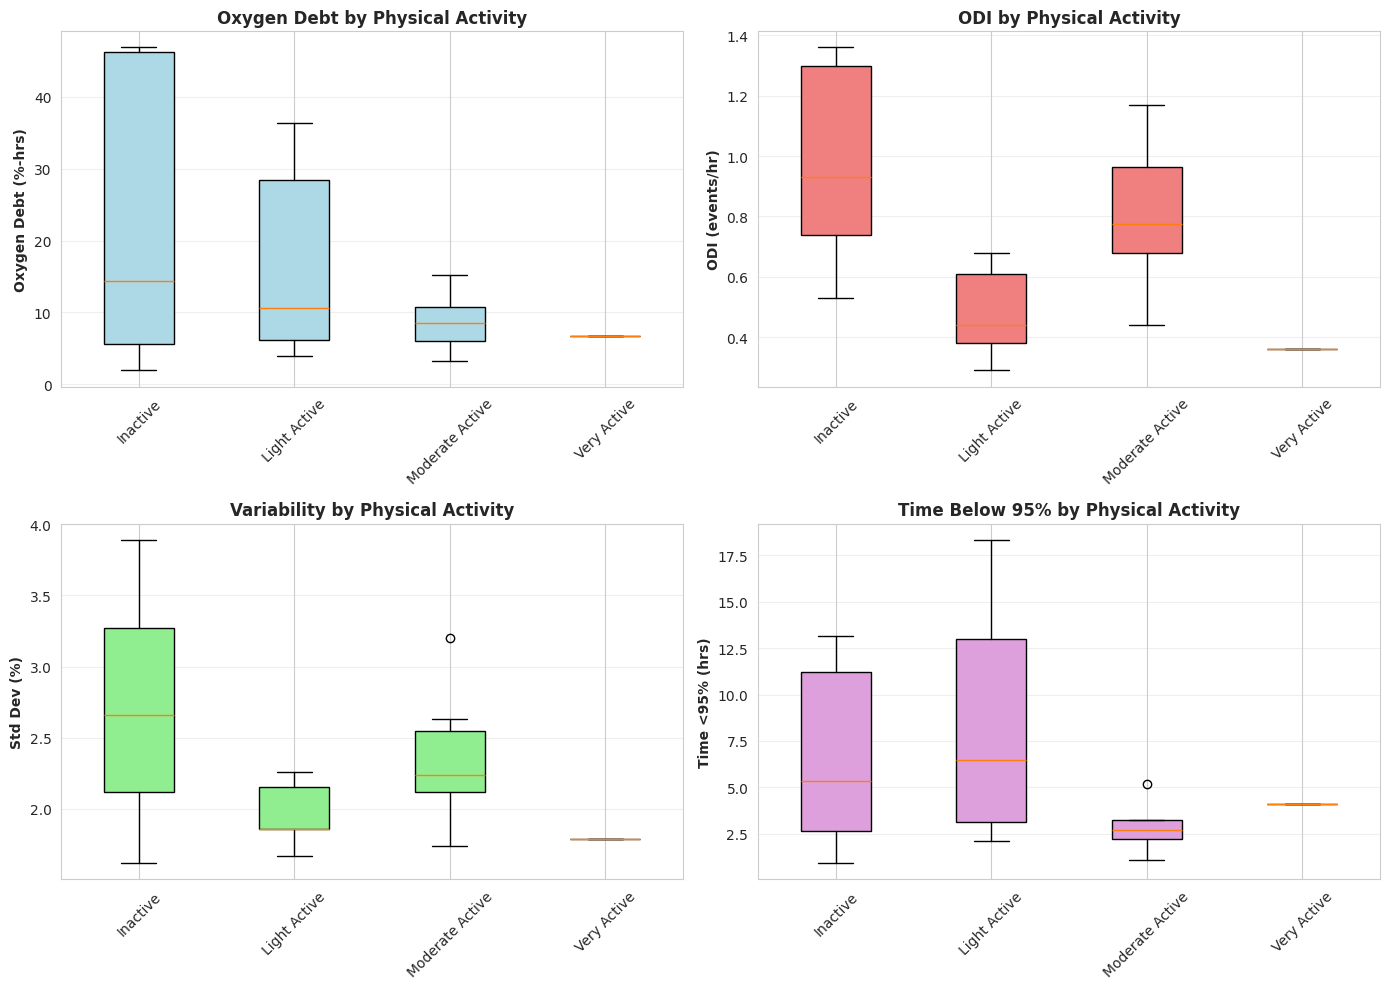

In [ ]:
# ============================================================================
# EVALUATION 1: Activity Level vs SpO2 Metrics (Visit Level)
# ============================================================================

print("\n" + "=" * 70)
print("EVALUATION 1: VISIT ACTIVITY LEVEL vs SpO2 METRICS")
print("=" * 70)

if len(visit_evaluation) > 0:
    activity_comparison = visit_evaluation.groupby('visit_activity_level').agg({
        'oxygen_debt': ['mean', 'std', 'count'],
        'time_below_95_hours': 'mean',
        'std_dev': 'mean',
        'odi': 'mean',
        'avg_daily_steps': 'mean'
    }).round(2)

    print("\nSpO2 Metrics by Physical Activity Level:")
    print(activity_comparison)

    # Visualization
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    activity_levels = visit_evaluation['visit_activity_level'].unique()
    activity_order = [level for level in ['Inactive', 'Light Active', 'Moderate Active', 'Very Active']
                      if level in activity_levels]

    # Plot 1: Oxygen Debt
    ax1 = axes[0, 0]
    data1 = [visit_evaluation[visit_evaluation['visit_activity_level']==level]['oxygen_debt'].values
             for level in activity_order]
    bp1 = ax1.boxplot(data1, labels=activity_order, patch_artist=True)
    for patch in bp1['boxes']:
        patch.set_facecolor('lightblue')
    ax1.set_ylabel('Oxygen Debt (%-hrs)', fontweight='bold')
    ax1.set_title('Oxygen Debt by Physical Activity', fontweight='bold')
    ax1.tick_params(axis='x', rotation=45)
    ax1.grid(axis='y', alpha=0.3)

    # Plot 2: ODI
    ax2 = axes[0, 1]
    data2 = [visit_evaluation[visit_evaluation['visit_activity_level']==level]['odi'].values
             for level in activity_order]
    bp2 = ax2.boxplot(data2, labels=activity_order, patch_artist=True)
    for patch in bp2['boxes']:
        patch.set_facecolor('lightcoral')
    ax2.set_ylabel('ODI (events/hr)', fontweight='bold')
    ax2.set_title('ODI by Physical Activity', fontweight='bold')
    ax2.tick_params(axis='x', rotation=45)
    ax2.grid(axis='y', alpha=0.3)

    # Plot 3: Variability
    ax3 = axes[1, 0]
    data3 = [visit_evaluation[visit_evaluation['visit_activity_level']==level]['std_dev'].values
             for level in activity_order]
    bp3 = ax3.boxplot(data3, labels=activity_order, patch_artist=True)
    for patch in bp3['boxes']:
        patch.set_facecolor('lightgreen')
    ax3.set_ylabel('Std Dev (%)', fontweight='bold')
    ax3.set_title('Variability by Physical Activity', fontweight='bold')
    ax3.tick_params(axis='x', rotation=45)
    ax3.grid(axis='y', alpha=0.3)

    # Plot 4: Time <95%
    ax4 = axes[1, 1]
    data4 = [visit_evaluation[visit_evaluation['visit_activity_level']==level]['time_below_95_hours'].values
             for level in activity_order]
    bp4 = ax4.boxplot(data4, labels=activity_order, patch_artist=True)
    for patch in bp4['boxes']:
        patch.set_facecolor('plum')
    ax4.set_ylabel('Time <95% (hrs)', fontweight='bold')
    ax4.set_title('Time Below 95% by Physical Activity', fontweight='bold')
    ax4.tick_params(axis='x', rotation=45)
    ax4.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.show()


EVALUATION 3: CORRELATION ANALYSIS

Correlations (Steps vs SpO2 Metrics):
  oxygen_debt: r=-0.410, p=0.1018 ns
  time_below_95_hours: r=-0.356, p=0.1603 ns
  std_dev: r=-0.275, p=0.2849 ns
  odi: r=-0.252, p=0.3286 ns


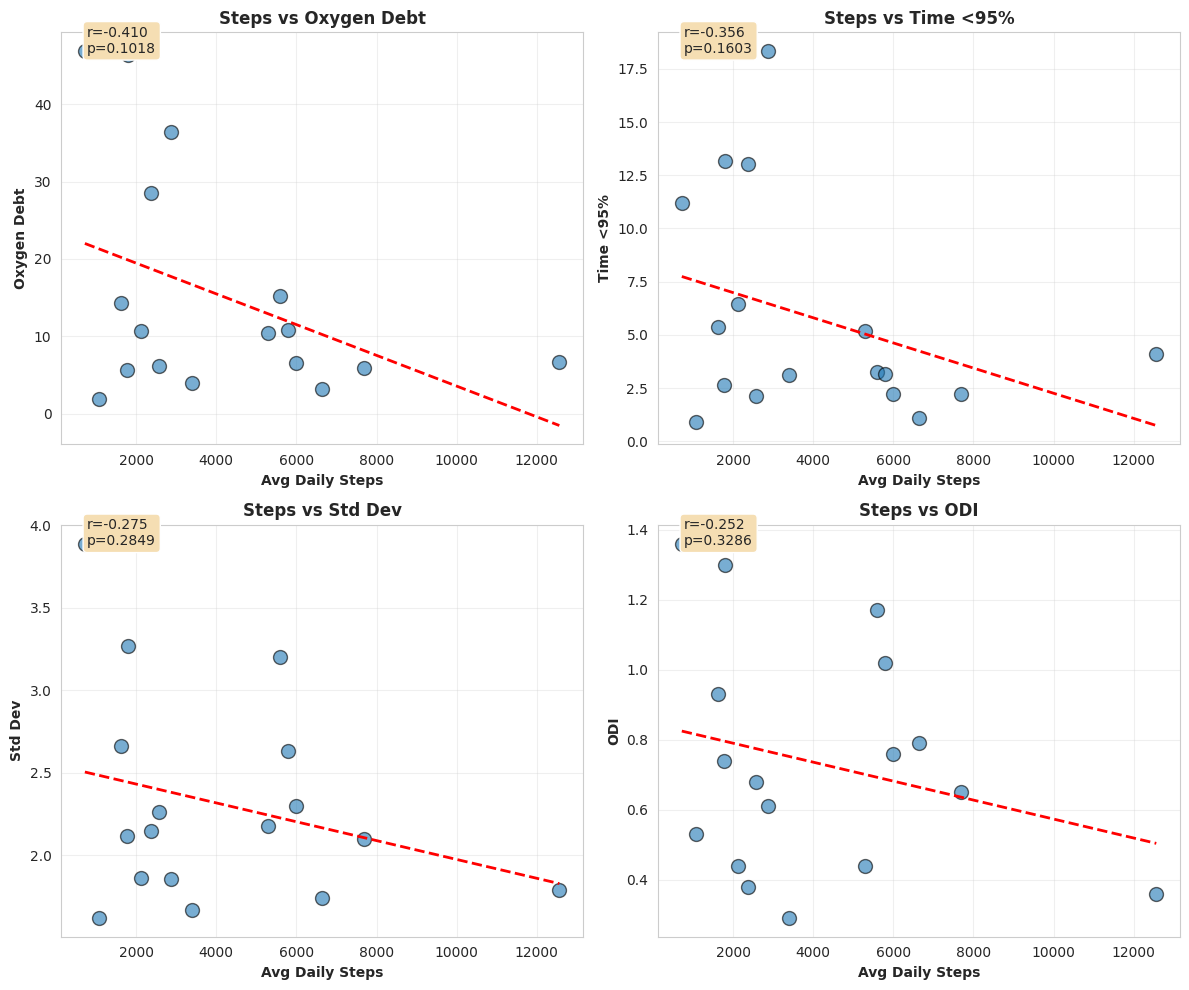

In [ ]:
# ============================================================================
# EVALUATION 3: Correlation Analysis (Steps vs SpO2)
# ============================================================================

print("\n" + "=" * 70)
print("EVALUATION 3: CORRELATION ANALYSIS")
print("=" * 70)

if len(visit_evaluation) >= 3:
    from scipy.stats import pearsonr

    print("\nCorrelations (Steps vs SpO2 Metrics):")

    for metric in ['oxygen_debt', 'time_below_95_hours', 'std_dev', 'odi']:
        r, p = pearsonr(visit_evaluation['avg_daily_steps'], visit_evaluation[metric])
        sig = '***' if p < 0.001 else '**' if p < 0.01 else '*' if p < 0.05 else 'ns'
        print(f"  {metric}: r={r:.3f}, p={p:.4f} {sig}")

    # Scatter plots
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    metrics = [('oxygen_debt', 'Oxygen Debt'), ('time_below_95_hours', 'Time <95%'),
               ('std_dev', 'Std Dev'), ('odi', 'ODI')]

    for idx, (metric, label) in enumerate(metrics):
        ax = axes[idx // 2, idx % 2]

        ax.scatter(visit_evaluation['avg_daily_steps'], visit_evaluation[metric],
                  s=100, alpha=0.6, edgecolors='black')

        # Trend line
        z = np.polyfit(visit_evaluation['avg_daily_steps'], visit_evaluation[metric], 1)
        p_fit = np.poly1d(z)
        x_trend = np.linspace(visit_evaluation['avg_daily_steps'].min(),
                             visit_evaluation['avg_daily_steps'].max(), 100)
        ax.plot(x_trend, p_fit(x_trend), 'r--', linewidth=2)

        r, p_val = pearsonr(visit_evaluation['avg_daily_steps'], visit_evaluation[metric])
        ax.text(0.05, 0.95, f'r={r:.3f}\np={p_val:.4f}',
               transform=ax.transAxes, bbox=dict(boxstyle='round', facecolor='wheat'))

        ax.set_xlabel('Avg Daily Steps', fontweight='bold')
        ax.set_ylabel(label, fontweight='bold')
        ax.set_title(f'Steps vs {label}', fontweight='bold')
        ax.grid(alpha=0.3)

    plt.tight_layout()
    plt.savefig('eval_visit_correlations.png', dpi=300, bbox_inches='tight')
    plt.show()

OXYGEN DEBT vs ACTIVITY - ALL PATIENTS IN ONE PLOT

1. Preparing data...
✓ 17 patient-visits
✓ 15 unique patients

Data:
 patient_id  visit  avg_daily_steps  activity_level  oxygen_debt
          1      0     12563.800000     Very Active         6.73
          1      1      3392.666667    Light Active         3.99
          2      1      2577.785714    Light Active         6.21
          3      1      5585.888889 Moderate Active        15.18
          5      1      2115.666667    Light Active        10.63
          9      0      2879.500000    Light Active        36.40
          9      1      1788.769231        Inactive        46.31
         10      0      1078.466667        Inactive         1.92
         11      0      6635.571429 Moderate Active         3.16
         12      0      5783.076923 Moderate Active        10.81
         13      0      1761.000000        Inactive         5.59
         14      0      7696.000000 Moderate Active         5.90
         15      0      6000.45454

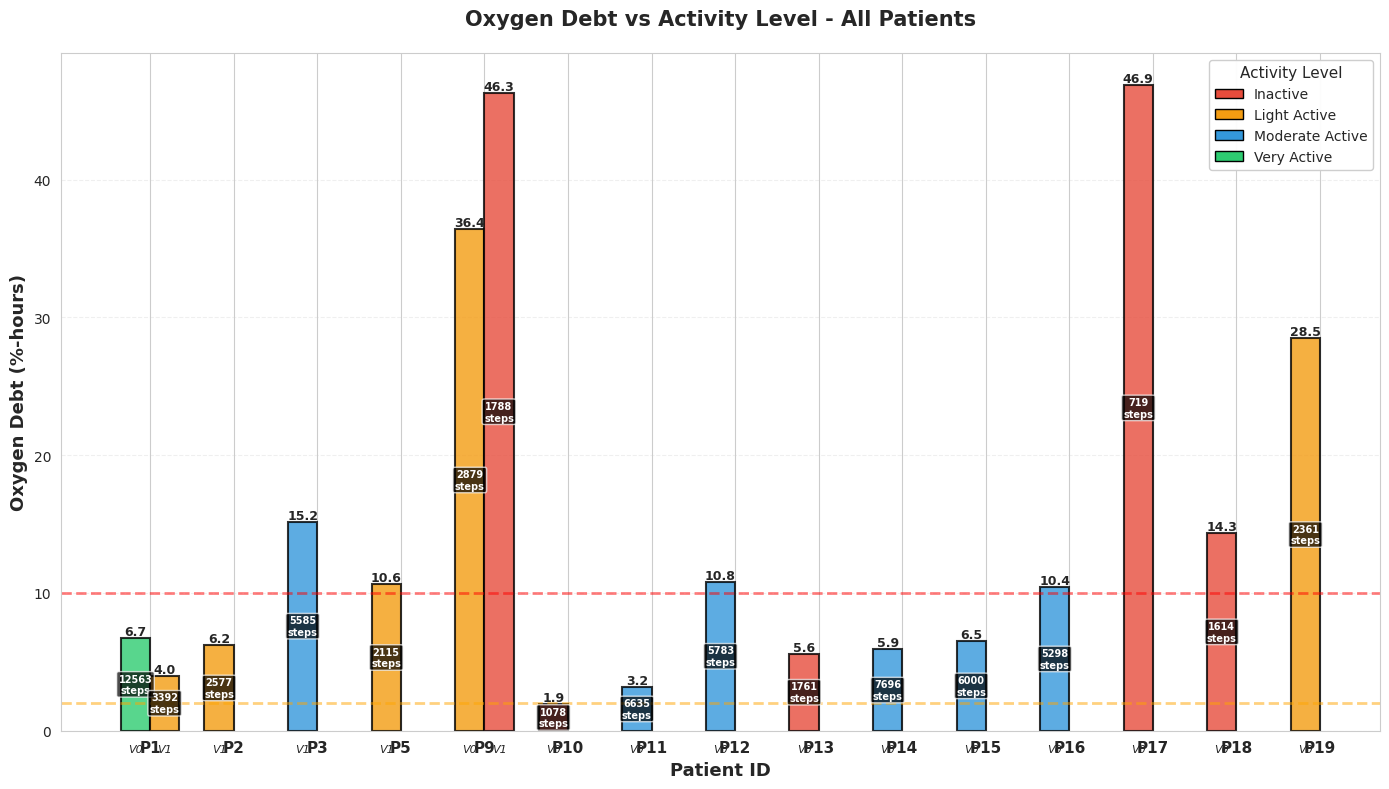


SUMMARY

Per Patient:

Patient 1:
  V0: 6.7 %-hrs (Very Active, 12564 steps)
  V1: 4.0 %-hrs (Light Active, 3393 steps)
  Change: -2.7 ↓ (steps: -9171) ✓

Patient 2: 6.2 %-hrs (Light Active, 2578 steps)

Patient 3: 15.2 %-hrs (Moderate Active, 5586 steps)

Patient 5: 10.6 %-hrs (Light Active, 2116 steps)

Patient 9:
  V0: 36.4 %-hrs (Light Active, 2880 steps)
  V1: 46.3 %-hrs (Inactive, 1789 steps)
  Change: +9.9 ↑ (steps: -1091) ⚠

Patient 10: 1.9 %-hrs (Inactive, 1078 steps)

Patient 11: 3.2 %-hrs (Moderate Active, 6636 steps)

Patient 12: 10.8 %-hrs (Moderate Active, 5783 steps)

Patient 13: 5.6 %-hrs (Inactive, 1761 steps)

Patient 14: 5.9 %-hrs (Moderate Active, 7696 steps)

Patient 15: 6.5 %-hrs (Moderate Active, 6000 steps)

Patient 16: 10.4 %-hrs (Moderate Active, 5298 steps)

Patient 17: 46.9 %-hrs (Inactive, 720 steps)

Patient 18: 14.3 %-hrs (Inactive, 1614 steps)

Patient 19: 28.5 %-hrs (Light Active, 2361 steps)

KEY INSIGHT
Each patient shows 1-2 bars (Visit 0 and/or Vis

In [ ]:
# ============================================================================
# EVALUATION: Oxygen Debt vs Activity - SINGLE PLOT ALL PATIENTS
# ============================================================================

print("=" * 70)
print("OXYGEN DEBT vs ACTIVITY - ALL PATIENTS IN ONE PLOT")
print("=" * 70)

# ============================================================================
# Step 1: Prepare Data
# ============================================================================

print("\n1. Preparing data...")

# Aggregate activity by patient-visit
visit_activity = daily_activity.groupby(['patient_id', 'visit']).agg({
    'total_steps': 'mean',
    'avg_intensity': 'mean',
    'date': 'count'
}).reset_index()

visit_activity.columns = ['patient_id', 'visit', 'avg_daily_steps',
                          'avg_intensity', 'num_days']

# Classify activity level
def classify_activity(steps):
    if steps < 2000:
        return 'Inactive'
    elif steps < 5000:
        return 'Light Active'
    elif steps < 8000:
        return 'Moderate Active'
    else:
        return 'Very Active'

visit_activity['activity_level'] = visit_activity['avg_daily_steps'].apply(classify_activity)

# Get oxygen debt
visit_spo2 = all_4methods_df.groupby(['patient_id', 'visit']).agg({
    'oxygen_debt': 'mean'
}).reset_index()

# Merge
evaluation = visit_spo2.merge(visit_activity, on=['patient_id', 'visit'], how='inner')

print(f"✓ {len(evaluation)} patient-visits")
print(f"✓ {evaluation['patient_id'].nunique()} unique patients")

print("\nData:")
print(evaluation[['patient_id', 'visit', 'avg_daily_steps', 'activity_level',
                  'oxygen_debt']].sort_values(['patient_id', 'visit']).to_string(index=False))

# ============================================================================
# Step 2: Create Single Combined Plot
# ============================================================================

print("\n2. Creating visualization...")

fig, ax = plt.subplots(1, 1, figsize=(14, 8))

# Get unique patients and sort
patients = sorted(evaluation['patient_id'].unique())
n_patients = len(patients)

# Colors for activity levels
activity_colors = {
    'Inactive': '#e74c3c',
    'Light Active': '#f39c12',
    'Moderate Active': '#3498db',
    'Very Active': '#2ecc71'
}

# Width settings
bar_width = 0.35
x_positions = np.arange(n_patients)

# Plot Visit 0 and Visit 1 side by side for each patient
for idx, patient_id in enumerate(patients):
    patient_data = evaluation[evaluation['patient_id'] == patient_id].sort_values('visit')

    for visit_idx, (_, row) in enumerate(patient_data.iterrows()):
        x_pos = idx + (visit_idx - 0.5) * bar_width

        color = activity_colors[row['activity_level']]

        bar = ax.bar(x_pos, row['oxygen_debt'], bar_width,
                    color=color, alpha=0.8, edgecolor='black', linewidth=1.5,
                    label=row['activity_level'] if idx == 0 and visit_idx == 0 else '')

        # Add value labels
        ax.text(x_pos, row['oxygen_debt'], f"{row['oxygen_debt']:.1f}",
               ha='center', va='bottom', fontsize=9, fontweight='bold')

        # Add visit label below bar
        ax.text(x_pos, -1, f"V{int(row['visit'])}",
               ha='center', va='top', fontsize=8, style='italic')

        # Add steps count in bar
        ax.text(x_pos, row['oxygen_debt']/2, f"{int(row['avg_daily_steps'])}\nsteps",
               ha='center', va='center', fontsize=7, color='white', fontweight='bold',
               bbox=dict(boxstyle='round,pad=0.2', facecolor='black', alpha=0.7))

# Formatting
ax.set_xlabel('Patient ID', fontweight='bold', fontsize=13)
ax.set_ylabel('Oxygen Debt (%-hours)', fontweight='bold', fontsize=13)
ax.set_title('Oxygen Debt vs Activity Level - All Patients',
            fontweight='bold', fontsize=15, pad=20)

ax.set_xticks(x_positions)
ax.set_xticklabels([f'P{int(p)}' for p in patients], fontsize=11, fontweight='bold')

ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_axisbelow(True)

# Add threshold lines
ax.axhline(y=10, color='red', linestyle='--', linewidth=2, alpha=0.5, label='High Risk (>10)')
ax.axhline(y=2, color='orange', linestyle='--', linewidth=2, alpha=0.5, label='Low Risk (<2)')

# Custom legend for activity levels
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#e74c3c', edgecolor='black', label='Inactive'),
    Patch(facecolor='#f39c12', edgecolor='black', label='Light Active'),
    Patch(facecolor='#3498db', edgecolor='black', label='Moderate Active'),
    Patch(facecolor='#2ecc71', edgecolor='black', label='Very Active'),
]

ax.legend(handles=legend_elements, loc='upper right', fontsize=10,
         title='Activity Level', title_fontsize=11, framealpha=0.95)

plt.tight_layout()
plt.show()


# ============================================================================
# Step 3: Summary Statistics
# ============================================================================

print("\n" + "=" * 70)
print("SUMMARY")
print("=" * 70)

print("\nPer Patient:")
for patient_id in patients:
    patient_data = evaluation[evaluation['patient_id'] == patient_id].sort_values('visit')

    if len(patient_data) > 1:
        v0 = patient_data.iloc[0]
        v1 = patient_data.iloc[-1]

        debt_change = v1['oxygen_debt'] - v0['oxygen_debt']
        step_change = v1['avg_daily_steps'] - v0['avg_daily_steps']

        arrow = '↓' if debt_change < 0 else '↑' if debt_change > 0 else '='
        color_symbol = '✓' if debt_change < 0 else '⚠' if debt_change > 0 else '='

        print(f"\nPatient {int(patient_id)}:")
        print(f"  V0: {v0['oxygen_debt']:.1f} %-hrs ({v0['activity_level']}, {v0['avg_daily_steps']:.0f} steps)")
        print(f"  V1: {v1['oxygen_debt']:.1f} %-hrs ({v1['activity_level']}, {v1['avg_daily_steps']:.0f} steps)")
        print(f"  Change: {debt_change:+.1f} {arrow} (steps: {step_change:+.0f}) {color_symbol}")
    else:
        v = patient_data.iloc[0]
        print(f"\nPatient {int(patient_id)}: {v['oxygen_debt']:.1f} %-hrs ({v['activity_level']}, {v['avg_daily_steps']:.0f} steps)")

print("\n" + "=" * 70)
print("KEY INSIGHT")
print("=" * 70)
print("Each patient shows 1-2 bars (Visit 0 and/or Visit 1)")
print("Bar color = Activity level")
print("Bar height = Oxygen debt")
print("Text in bar = Daily steps")
print("\nLower bars + greener colors = Better health!")
print("=" * 70)

WEEKLY ACTIVITY PATTERNS - DAY-BY-DAY TIME SERIES

1. Preparing daily activity data...
Total daily records: 243
Date range: 2025-06-16 to 2025-10-23
Unique patients: 15

2. Finding patients with 7+ consecutive days...

Patient-visits with 7+ days: 18

Selected for visualization:
  Patient 17, Visit 0: 34 days
  Patient 19, Visit 0: 20 days
  Patient 3, Visit 1: 18 days

3. Creating time series visualization...


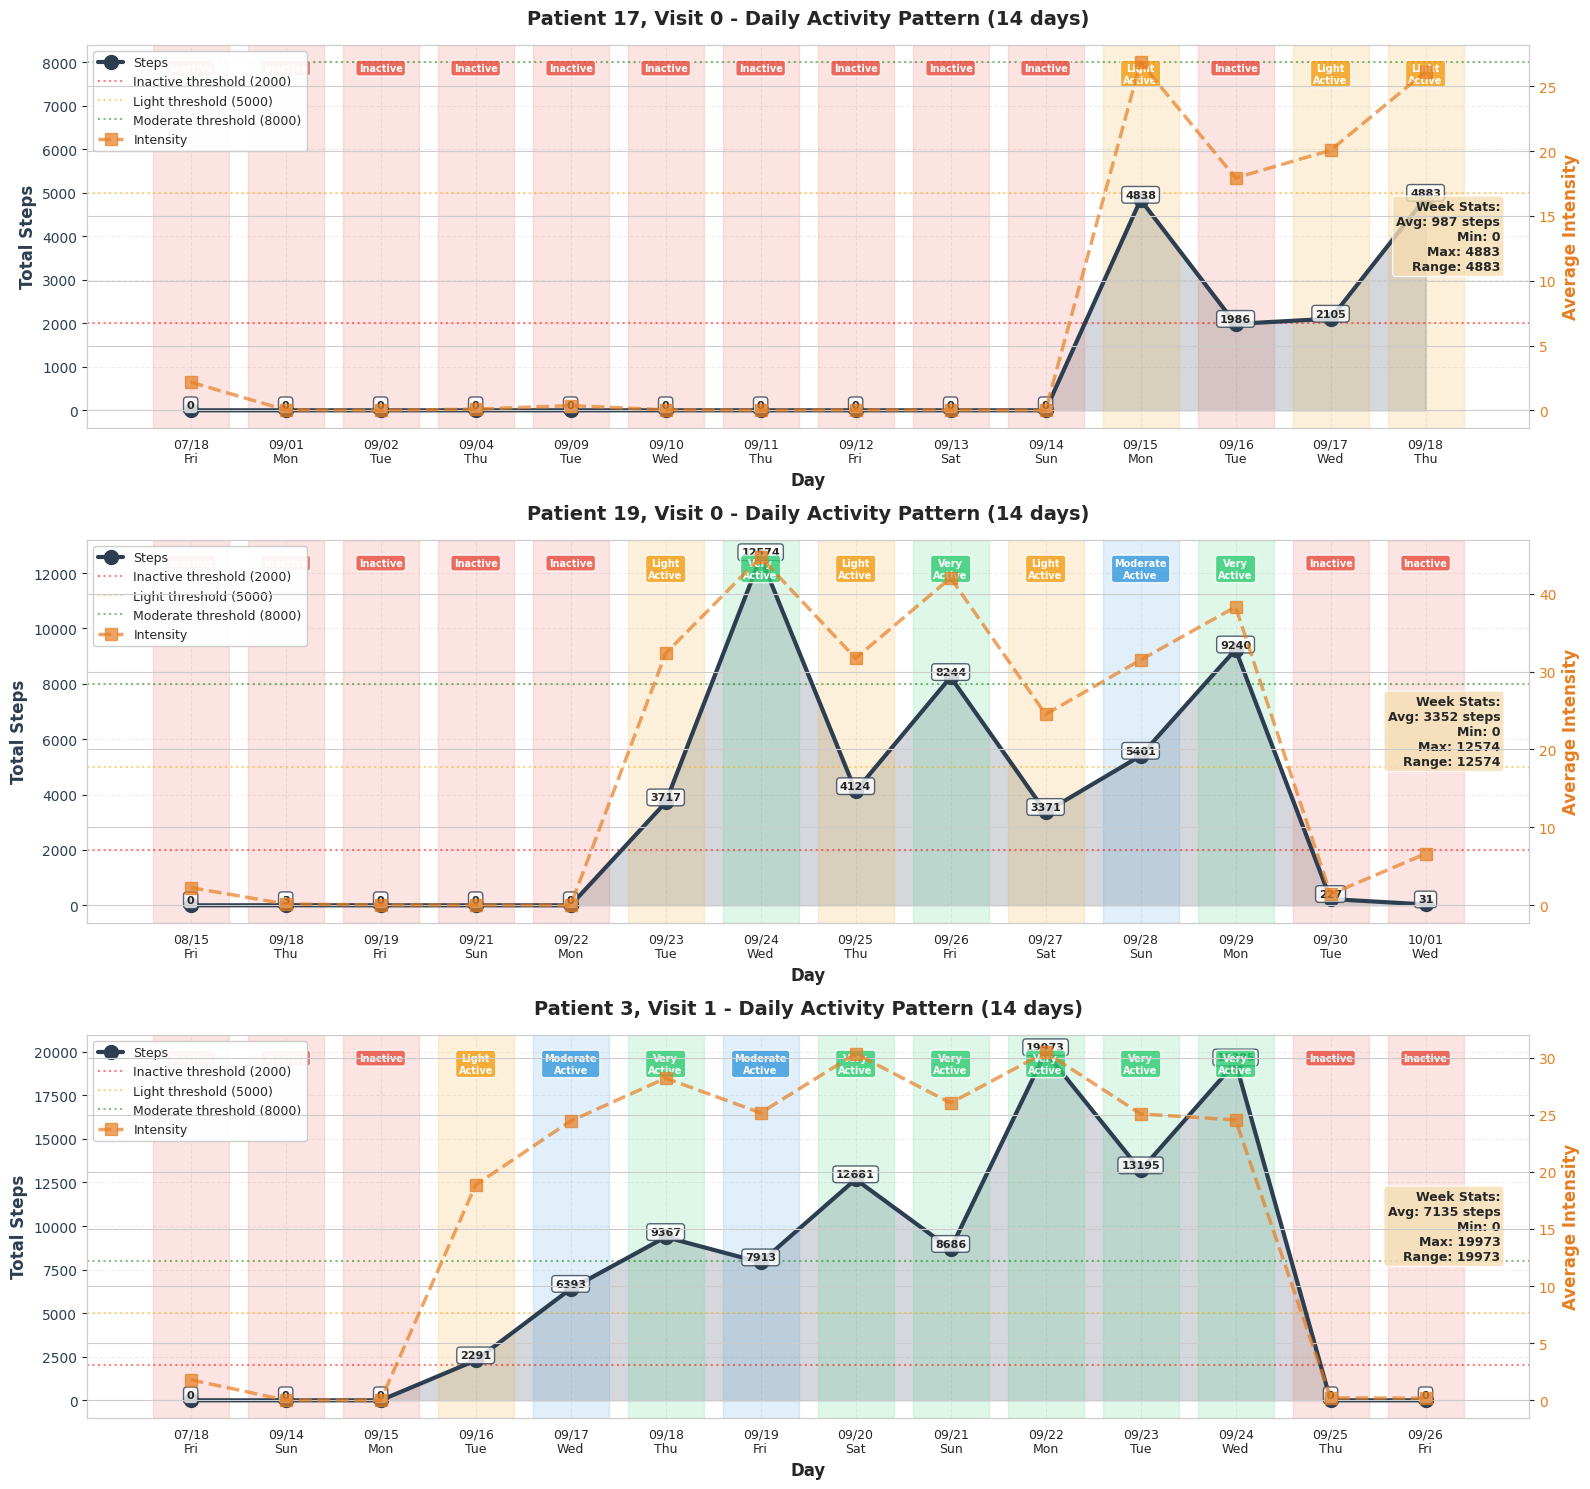


✓ Visualization saved: weekly_activity_time_series.png

WEEKLY PATTERN ANALYSIS

Patient 17, Visit 0:
----------------------------------------------------------------------
  2025-07-18 Fri:     0 steps | Intensity:   2.2 | Inactive
  2025-09-01 Mon:     0 steps | Intensity:   0.0 | Inactive
  2025-09-02 Tue:     0 steps | Intensity:   0.0 | Inactive
  2025-09-04 Thu:     0 steps | Intensity:   0.1 | Inactive
  2025-09-09 Tue:     0 steps | Intensity:   0.4 | Inactive
  2025-09-10 Wed:     0 steps | Intensity:   0.0 | Inactive
  2025-09-11 Thu:     0 steps | Intensity:   0.0 | Inactive
  2025-09-12 Fri:     0 steps | Intensity:   0.0 | Inactive
  2025-09-13 Sat:     0 steps | Intensity:   0.0 | Inactive
  2025-09-14 Sun:     0 steps | Intensity:   0.0 | Inactive
  2025-09-15 Mon:  4838 steps | Intensity:  26.9 | Light Active
  2025-09-16 Tue:  1986 steps | Intensity:  17.9 | Inactive
  2025-09-17 Wed:  2105 steps | Intensity:  20.1 | Light Active
  2025-09-18 Thu:  4883 steps | Intens

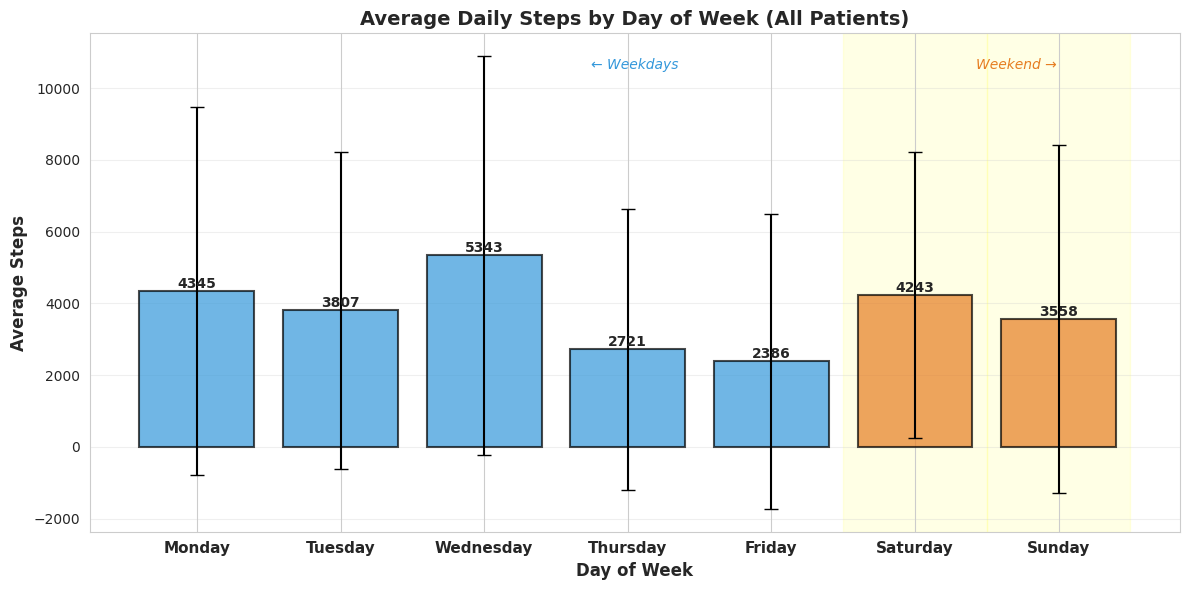

In [ ]:
# ============================================================================
# EVALUATION: Weekly Activity Patterns - Time Series Analysis (FIXED)
# ============================================================================

print("=" * 70)
print("WEEKLY ACTIVITY PATTERNS - DAY-BY-DAY TIME SERIES")
print("=" * 70)

# ============================================================================
# Step 1: Prepare Daily Activity Data
# ============================================================================

print("\n1. Preparing daily activity data...")

# We already have daily_activity from previous step
# Add day of week
daily_activity['date_dt'] = pd.to_datetime(daily_activity['date'])
daily_activity['day_of_week'] = daily_activity['date_dt'].dt.dayofweek
daily_activity['day_name'] = daily_activity['date_dt'].dt.day_name()

# Sort by date
daily_activity_sorted = daily_activity.sort_values(['patient_id', 'visit', 'date'])

print(f"Total daily records: {len(daily_activity_sorted)}")
print(f"Date range: {daily_activity_sorted['date'].min()} to {daily_activity_sorted['date'].max()}")
print(f"Unique patients: {daily_activity_sorted['patient_id'].nunique()}")

# ============================================================================
# Step 2: Find Patients with Weekly Data
# ============================================================================

print("\n2. Finding patients with 7+ consecutive days...")

# Find patients with at least 7 days of data
patient_day_counts = daily_activity_sorted.groupby(['patient_id', 'visit']).size()
patients_with_week = patient_day_counts[patient_day_counts >= 7]

print(f"\nPatient-visits with 7+ days: {len(patients_with_week)}")

if len(patients_with_week) > 0:
    # Select top 3 patients for visualization
    top_patients = patients_with_week.nlargest(min(3, len(patients_with_week))).index.tolist()

    print("\nSelected for visualization:")
    for patient_id, visit in top_patients:
        days = patient_day_counts[(patient_id, visit)]
        print(f"  Patient {patient_id}, Visit {visit}: {days} days")
else:
    print("\n⚠️ No patients with 7+ days. Showing all available data...")
    top_patients = patient_day_counts.nlargest(min(3, len(patient_day_counts))).index.tolist()

# ============================================================================
# Step 3: Create Time Series Visualization
# ============================================================================

print("\n3. Creating time series visualization...")

n_patients = len(top_patients)
fig, axes = plt.subplots(n_patients, 1, figsize=(16, 5*n_patients))

if n_patients == 1:
    axes = [axes]

# Activity level colors
activity_colors = {
    'Inactive': '#e74c3c',
    'Light Active': '#f39c12',
    'Moderate Active': '#3498db',
    'Very Active': '#2ecc71'
}

for idx, (patient_id, visit) in enumerate(top_patients):
    ax = axes[idx]

    # Get patient data
    patient_data = daily_activity_sorted[
        (daily_activity_sorted['patient_id'] == patient_id) &
        (daily_activity_sorted['visit'] == visit)
    ].copy()

    # Take first 7-14 days for cleaner visualization
    patient_data = patient_data.head(min(14, len(patient_data)))

    dates = patient_data['date_dt'].values
    steps = patient_data['total_steps'].values
    intensity = patient_data['avg_intensity'].values
    activity_levels = patient_data['activity_level'].values

    # Create x-axis as day numbers
    x = np.arange(len(dates))

    # ========== Primary Y-axis: Steps ==========
    color_steps = '#2c3e50'
    ax.plot(x, steps, color=color_steps, linewidth=3, marker='o',
            markersize=10, label='Steps', zorder=3)

    # Fill area under steps line
    ax.fill_between(x, 0, steps, alpha=0.2, color=color_steps)

    ax.set_xlabel('Day', fontweight='bold', fontsize=12)
    ax.set_ylabel('Total Steps', fontweight='bold', fontsize=12, color=color_steps)
    ax.tick_params(axis='y', labelcolor=color_steps)

    # ========== Secondary Y-axis: Intensity ==========
    ax2 = ax.twinx()
    color_intensity = '#e67e22'
    ax2.plot(x, intensity, color=color_intensity, linewidth=2.5,
             marker='s', markersize=8, label='Intensity',
             linestyle='--', alpha=0.7, zorder=2)

    ax2.set_ylabel('Average Intensity', fontweight='bold', fontsize=12, color=color_intensity)
    ax2.tick_params(axis='y', labelcolor=color_intensity)

    # ========== Color-coded background by activity level ==========
    for i in range(len(x)):
        color = activity_colors[activity_levels[i]]
        ax.axvspan(i-0.4, i+0.4, alpha=0.15, color=color, zorder=1)

    # ========== Formatting ==========
    ax.set_xticks(x)

    # Format x-axis labels with date and day name (FIXED)
    labels = [f"{pd.Timestamp(d).strftime('%m/%d')}\n{patient_data.iloc[i]['day_name'][:3]}"
              for i, d in enumerate(dates)]
    ax.set_xticklabels(labels, fontsize=9)

    # Title
    ax.set_title(f'Patient {int(patient_id)}, Visit {int(visit)} - Daily Activity Pattern ({len(patient_data)} days)',
                fontweight='bold', fontsize=14, pad=15)

    # Grid
    ax.grid(axis='both', alpha=0.3, linestyle='--', zorder=0)
    ax.set_axisbelow(True)

    # Add threshold lines for steps
    ax.axhline(y=2000, color='red', linestyle=':', linewidth=1.5,
               alpha=0.5, label='Inactive threshold (2000)', zorder=2)
    ax.axhline(y=5000, color='orange', linestyle=':', linewidth=1.5,
               alpha=0.5, label='Light threshold (5000)', zorder=2)
    ax.axhline(y=8000, color='green', linestyle=':', linewidth=1.5,
               alpha=0.5, label='Moderate threshold (8000)', zorder=2)

    # Add value labels on points
    for i, (day_x, step_val, intens_val, act_level) in enumerate(zip(x, steps, intensity, activity_levels)):
        # Steps value
        ax.text(day_x, step_val, f'{int(step_val)}',
               ha='center', va='bottom', fontsize=8, fontweight='bold',
               bbox=dict(boxstyle='round,pad=0.3', facecolor='white',
                        edgecolor=color_steps, alpha=0.8))

        # Activity level badge
        ax.text(day_x, ax.get_ylim()[1] * 0.95, act_level.replace(' ', '\n'),
               ha='center', va='top', fontsize=7, fontweight='bold',
               color='white',
               bbox=dict(boxstyle='round,pad=0.3',
                        facecolor=activity_colors[act_level], alpha=0.8))

    # Combined legend
    lines1, labels1 = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(lines1 + lines2, labels1 + labels2, loc='upper left',
             fontsize=9, framealpha=0.95)

    # Statistics box
    stats_text = f"Week Stats:\n"
    stats_text += f"Avg: {steps.mean():.0f} steps\n"
    stats_text += f"Min: {steps.min():.0f}\n"
    stats_text += f"Max: {steps.max():.0f}\n"
    stats_text += f"Range: {steps.max() - steps.min():.0f}"

    ax.text(0.98, 0.50, stats_text,
           transform=ax.transAxes, fontsize=9,
           verticalalignment='center', horizontalalignment='right',
           bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
           fontweight='bold')

plt.tight_layout()
plt.show()

print("\n✓ Visualization saved: weekly_activity_time_series.png")

# ============================================================================
# Step 4: Weekly Pattern Analysis
# ============================================================================

print("\n" + "=" * 70)
print("WEEKLY PATTERN ANALYSIS")
print("=" * 70)

for patient_id, visit in top_patients:
    patient_data = daily_activity_sorted[
        (daily_activity_sorted['patient_id'] == patient_id) &
        (daily_activity_sorted['visit'] == visit)
    ].head(14)

    print(f"\nPatient {int(patient_id)}, Visit {int(visit)}:")
    print("-" * 70)

    # Daily breakdown
    for _, row in patient_data.iterrows():
        date_str = pd.Timestamp(row['date_dt']).strftime('%Y-%m-%d %a')
        print(f"  {date_str}: {int(row['total_steps']):5d} steps | "
              f"Intensity: {row['avg_intensity']:5.1f} | "
              f"{row['activity_level']}")

    # Weekly stats
    print(f"\n  Weekly Statistics:")
    print(f"    Mean steps: {patient_data['total_steps'].mean():.0f}")
    print(f"    Std dev: {patient_data['total_steps'].std():.0f}")
    print(f"    Coefficient of variation: {(patient_data['total_steps'].std() / patient_data['total_steps'].mean() * 100):.1f}%")

    # Day-to-day changes
    daily_changes = patient_data['total_steps'].diff()
    print(f"    Mean daily change: {daily_changes.mean():.0f} steps")
    print(f"    Max increase: {daily_changes.max():.0f}")
    print(f"    Max decrease: {daily_changes.min():.0f}")

    # Weekend vs Weekday (if we have both)
    weekend = patient_data[patient_data['day_of_week'].isin([5, 6])]  # Sat, Sun
    weekday = patient_data[~patient_data['day_of_week'].isin([5, 6])]

    if len(weekend) > 0 and len(weekday) > 0:
        print(f"\n  Weekend vs Weekday:")
        print(f"    Weekday avg: {weekday['total_steps'].mean():.0f} steps")
        print(f"    Weekend avg: {weekend['total_steps'].mean():.0f} steps")
        diff = weekend['total_steps'].mean() - weekday['total_steps'].mean()
        print(f"    Difference: {diff:+.0f} ({diff/weekday['total_steps'].mean()*100:+.1f}%)")

# ============================================================================
# Step 5: Day-of-Week Aggregate Pattern
# ============================================================================

print("\n" + "=" * 70)
print("DAY-OF-WEEK PATTERN (ALL DATA)")
print("=" * 70)

# Aggregate across all patients by day of week
dow_pattern = daily_activity_sorted.groupby('day_name').agg({
    'total_steps': ['mean', 'std', 'count']
}).round(0)

# Order by day of week
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_order = [d for d in day_order if d in dow_pattern.index]

print("\nAverage steps by day of week:")
print(dow_pattern.loc[day_order])

# Simple day-of-week bar chart
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

dow_means = [daily_activity_sorted[daily_activity_sorted['day_name']==day]['total_steps'].mean()
             for day in day_order]
dow_stds = [daily_activity_sorted[daily_activity_sorted['day_name']==day]['total_steps'].std()
            for day in day_order]

bars = ax.bar(range(len(day_order)), dow_means, yerr=dow_stds,
              color=['#3498db' if d not in ['Saturday', 'Sunday'] else '#e67e22' for d in day_order],
              alpha=0.7, edgecolor='black', linewidth=1.5, capsize=5)

ax.set_xticks(range(len(day_order)))
ax.set_xticklabels(day_order, fontsize=11, fontweight='bold')
ax.set_ylabel('Average Steps', fontweight='bold', fontsize=12)
ax.set_xlabel('Day of Week', fontweight='bold', fontsize=12)
ax.set_title('Average Daily Steps by Day of Week (All Patients)',
            fontweight='bold', fontsize=14)
ax.grid(axis='y', alpha=0.3)

# Add value labels
for i, (bar, mean) in enumerate(zip(bars, dow_means)):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
           f'{int(mean)}', ha='center', va='bottom', fontweight='bold', fontsize=10)

# Highlight weekend
weekend_indices = [i for i, d in enumerate(day_order) if d in ['Saturday', 'Sunday']]
for idx in weekend_indices:
    ax.axvspan(idx-0.5, idx+0.5, alpha=0.1, color='yellow', zorder=0)

ax.text(0.5, 0.95, '← Weekdays', transform=ax.transAxes,
       ha='center', va='top', fontsize=10, style='italic', color='#3498db')
ax.text(0.85, 0.95, 'Weekend →', transform=ax.transAxes,
       ha='center', va='top', fontsize=10, style='italic', color='#e67e22')

plt.tight_layout()
plt.show()
